# Shortwave Radiation

__J. Potemra__
<br>
_February 2023_

----
This notebook focuses on shortwave radiation at the ocean surface, $Q_{S}^{Net}$.  This is the main warming component of the net surface heat flux (in most places).  It derives from the straighforward balance between incoming (downward, $Q_{S}^{Down}$) and outgoing (upward, $Q_{S}^{Up}$) radiation (see [introductory notes](heat_flux.ipynb)):

\begin{eqnarray}
Q_{S}^{Net}  & = & Q_{S}^{Down} - Q_{S}^{Up}
\end{eqnarray}

Complexities arise in deriving these two components.  The upward component is essentially the shortwave reflected by the ocean surface ($Q_{S}^{Reflect}$), which means the upward component is a function of the downward.  The downward component, on the other hand, can be separated into the incoming under clear sky conditions ($Q_{S}^{Clear}$, also referred to as __clear sky irradiance__) and that absorbed/reflected by clouds ($Q_{S}^{Cloud}$):

\begin{eqnarray}
Q_{S}^{Net} = Q_{S}^{Clear} - Q_{S}^{Cloud} - Q_{S}^{Reflect}
\end{eqnarray}

The ratio of reflected to incoming radiation is called the albedo: $\alpha = \frac{Q_{S}^{Reflect}}{Q_{S}^{Clear} - Q_{S}^{Cloud}}$.  _In-situ_ instruments, such as the moorings, typically measure $Q_{Down}$, or $Q_{S}^{Clear} - Q_{S}^{Cloud}$, and assume a value for $\alpha$ to come up with $Q_{S}^{Net}$.

<figure>
   <img src="./images/shortwave_cartoon.jpg" style="width:50%">
   <figcaption align = "center"><font color=dodgerblue>Figure 1.  Schematic of net surface shortwave radiation measured by the mooring. </font></figcaption>
</figure>
<br>

\begin{eqnarray}
\begin{aligned}
Q_{S}^{Net} & = Q_{S}^{Down} - Q_{S}^{Up} \\
            & = \left( Q_{S}^{Clear} - Q_{S}^{Cloud} \right) - Q_{S}^{Reflect} \\
Q_{S}^{Reflect} & =  \alpha \left( Q_{S}^{Clear} - Q_{S}^{Cloud} \right) \\
Q_{S}^{Net} & =  ( 1 - \alpha ) \left( Q_{S}^{Clear} - Q_{S}^{Cloud} \right) \\
          & = ( 1 - \alpha ) Q_{S}^{Obs} \\
\end{aligned}
\end{eqnarray}

Note that the buoys record the net downward shortwave radiation, but the data released via OceanSITES includes $Q_{Net}$ computed with albedo of 5 percent, thus $Q_{S}^{Net}/0.95$ should give the buoy recorded net downward shortwave ($Q_{S}^{Clear} - Q_{S}^{Cloud}$).

This notebook provides various ways to estimate the components of shortwave radiation.  This includes parameterizations for incoming shortwave radiation at the top of the atmosphere, clear sky radiance at the ocean surface, albedo and clouds.  The first part provides idealized calculations to demonstrate the dependence of these components on various things like time, location, _etc._  Comparisons are made to various (short term) observations.

In the latter part of the notebook the comparisons are extended to the long-term observations made at the Ocean Reference Stations (ORS) WHOTS, NTAS and Stratus and to the CFSv2 model sampled at the same lat/lon.  The buoys measure net downward radiation and then a constant albedo (0.05) is used to compute upward, and then the dataset provides the net.  The model also reports upward and downward (and net).  The model/obs shortwave is then compared to clear-sky estimates in an attempt to resolve cloud-related impacts.

<a id='notebook_top'></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">1. [Solar irradiance](#solar_irrad)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">1a. [Total Solar Irradiance (TSI)](#tsi)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">1b. [Solar Zenith Angle (sza)](#sza)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">1c. [Clear Sky Irradiance](#clear)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">1d. [Diffuse Horizontal Irradiance (DHI)](#dhi)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">2. [Comparison to obs](#obs_comp)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">3. [Albedo](#albedo)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">4. [Clouds](#clouds)</font><br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font size="5">5. [ORS/cfs comparison](#ors_comp)</font>

----

In [3]:
# import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import special
from scipy.io import loadmat
from datetime import datetime, timedelta
from pysolar.solar import *
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from tqdm.notebook import tqdm_notebook
%matplotlib inline

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

<a id='solar_irrad'></a>

# 1. Solar Irradiance

One of the main components of the ocean surface heat flux is shortwave radiation from the Sun ($Q_{S}$).  If it is assumed that the shortwave energy from the Sun is constant, the amount reaching the Earth at a fixed distance away (1 astronomical unit) is also constant.  This is referred to as the __solar constant__ ($I_{o}$) and is about 1,360 $W/m^2$. 

<br>

<figure>
   <img src="./images/solar-constant.jpg" style="width:75%">
   <figcaption align = "center"><font color=dodgerblue>Figure 2.  Schematic of incoming solar radiation (from http://www.greenrhinoenergy.com/solar/radiation/extraterrestrial.php). </font></figcaption>
</figure>
<br>

In [4]:
# solar constant
Io = 1360.0

The radiation from the Sun, however, is not constant.  Most noteably the Sun exhibits a near 11-year cycle (see Figure 3).  The amount of radiation reaching the Earth also changes due to changes in the Earth's orbit.  In shorter timescales this is evident annually since the Earth's orbit is not an exact circle (_i.e._ eccentricity), while on longer timescales this is due to things like obliquity and precession (as well as changes to the Earth's eccentricity).

<br>

<figure>
   <img src="./images/nn_sim_tsi_satelliteera_1400.jpg" style="width:75%">
   <figcaption align = "center"><font color=dodgerblue> Figure 3.  Varibility in the solar constant (from https://www.climate.gov/news-features/understanding-climate/climate-change-incoming-sunlight). </font></figcaption>
</figure>
<br>

<a id='tsi'></a>

## 1a.  Total Solar Irradiance (TSI) and Global Horizontal Irradiance (GHI)

While the solar constant varies due to the Sun, the amount of energy that reaches the outter atmosphere of the Earth changes due to orbital dynamics (changes in the Earth-Sun distance).  Eccentricity (orbit closer to a circle or more elliptical) results in a change of about +/- 3%.  Here I will refer to this time-varying radiation at the top of the atmosphere as the __Total Solar Irradiance__ (TSI), denoted as $Q_{o}(t)$ (sometimes called extraterrestrial radiation as well).  If changes in eccentrity are given by $E_o$, the time varying solar irradiance at the top of the atmosphere is given by $I_o E_o$.  One estimate of $E_o$ is given by https://www.intechopen.com/chapters/82468,

\begin{eqnarray}
Q_{o}(t) = I_{o} \left[ 1 + 0.034 cos(\gamma) \right]
\end{eqnarray}

where $\gamma$ is the "day angle" (day of year with respect to annual cycle, $2 \pi t  / 365.25$, where $t$ is in days).

Iqbal (1983) has a slightly different calculation:

\begin{eqnarray}
Q_{o}(t) = I_{o} \left[ 1.00011 + 0.034221 cos(\gamma) + 0.00128 sin(\gamma) + 0.000719 cos(2\gamma) + 0.000077 sin(2\gamma) \right]
\end{eqnarray}

The amount of shortwave radiation that then reaches the sea surface is some fraction of TSI (or $Q_o$) due to clouds and other atmospheric effects.  Another big influence on the shortwave radiation that impacts the sea surface is the angle at which it hits the earth surface. The irradiance on the surface is proportional to $cos(\theta_o)$ where $\theta_o$ is the solar zenith angle or the angle between the zenith and the sun. A diagram depicting this effect is shown in Figure 4.

<br>
<figure>
   <img src="./images/GHI.png" style="width:75%">
   <figcaption align = "center"><font color=dodgerblue> Figure 4.  Impact of solar angle on shortwave radiation reaching the ocean surface (from https://www.intechopen.com/chapters/82468). </font></figcaption>
</figure>
<br>

The amount of shortwave reaching the surface is reffered to as __global horiontal irradiance__ (GHI).  Another way to state this is GHI is the radiation perpendicular to the ground surface, while TSI is radiation perpendicular to the Sun, assuming no atmospheric inteference.  GHI is also what is typically measured by _in situ_ instruments and referred to as $Q_{S}^{down}$.  

GHI can be divided into two parts: direct, downward radiation or __direct normal irradiance__ (DNI), and that coming from other angles due to atmospheric reflection and scattering, __diffuse horizontal irradiance__ (DHI).  The distinction between the two is important in cases when the optical properties of the atmosphere and ocean surface need to be parameterized, for example when computing surface reflectance (albedo).  If clouds are ignored, the DNI becomes the same as "clear sky irradiance" at the ocean surface ($Q_{S}^{Clear}$; see Figure 1).  Together, the DNI and DHI can provide the total incoming shortwave radiation that reaches the ocean surface, $Q_{S}^{Down}$:

\begin{eqnarray}
Q_{S}^{down} = DNI \: cos(\theta_o) + DHI
\end{eqnarray}

Note that $Q_{S}^{Down}$ (aka GHI) is based on $\theta_o$, the solar zenith angle, which is described in the next section.  First, we compute TSI based on the two methods above itacanet.org and Iqbal (1983).  Next, we look at variability in the solar zenith angle and then compare the DHI computed from Ridley (2011) and using the [pvlib](https://pvlib-python.readthedocs.io/en/stable/) python package.  Finally, different clear sky irradiance parameterizations are invesitgated.

TSI ($Q_o$) is measured at the top of the atmosphere.  Without atmospheric interference, GHI is simply DNI $cos{\theta}$, and DNI is the same as TSI and $Q_o$. In this case GHI is also $I_o E_o cos{\theta}$.

<br>
<figure>
   <img src="./images/GHI_scheme.png" style="width:75%">
   <figcaption align = "center"><font color=dodgerblue> Figure 5.  Schematic representation of downward solar radiation (from https://www.intechopen.com/chapters/82468). </font></figcaption>
</figure>
<br>

The table below provides a cross-reference between Fernando's matlab code and the notes here.
    
| Variable                           | This notebook  | python | FSM code |
|------------------------------------|----------------|--------|----------|
| Solar constant                     | $I_o$          | Io     | Isc      |
| Eccentricity adjustment            | $E_o$          | Eo     | Eo       |
| Total solar irradiance (TSI)       | $Q_o$          | Qo     | Isc*Eo   |
| Global Horizontal Irradiance (GHI) | $Q_{S}^{down}$ | Qs     | Ii       |
| Clear-sky DNI                      | $Q_{S}^{Clear}$| Qcls   | Isc*Eo, Ho/cos(zh)|

[back to the top](#notebook_top)

In [5]:
def eccentricity(ntime,init_time,deltat,lon):
    # compute changes in TSI due to eccentricity of Earth's orbit (Solar Radiation, Iqbal, 1983)
    # input includes:
    #  1. ntime........time points to compute TSI [seconds]
    #  2. init_time....initial time of calculation [datetime]
    #  3. deltat.......resolution of calculation [seconds]
    #  4. lon..........longitude (needed for timezone offset; degrees west are negative) [degrees]
    # output:
    #  1. Eo...........total solar irradiance (TSI) or "extraterrestrial irradiance" [W/m-2]
    
    TZ = lon * 24.0 / 360.0
    time_offset = datetime.timedelta(hours=TZ,seconds=ntime*deltat)
    mtime = init_time + time_offset
    yr = mtime.year
    mo = mtime.month
    dy = mtime.day
    hr = mtime.hour
    mn = mtime.minute
    sc = mtime.second
        
    # compute day of year
    doy = mtime.timetuple().tm_yday
    if doy < 1.0:
        doy = doy + 365.0
    dn = np.floor(doy)
        
    # compute the "day angle" in radians
    da = 2*np.pi*(dn-1)/365
    Eo = 1.00011 + 0.034221*np.cos(da) + 0.00128*np.sin(da) + 0.000719*np.cos(2*da) + 0.000077*np.sin(2*da)
    return Eo

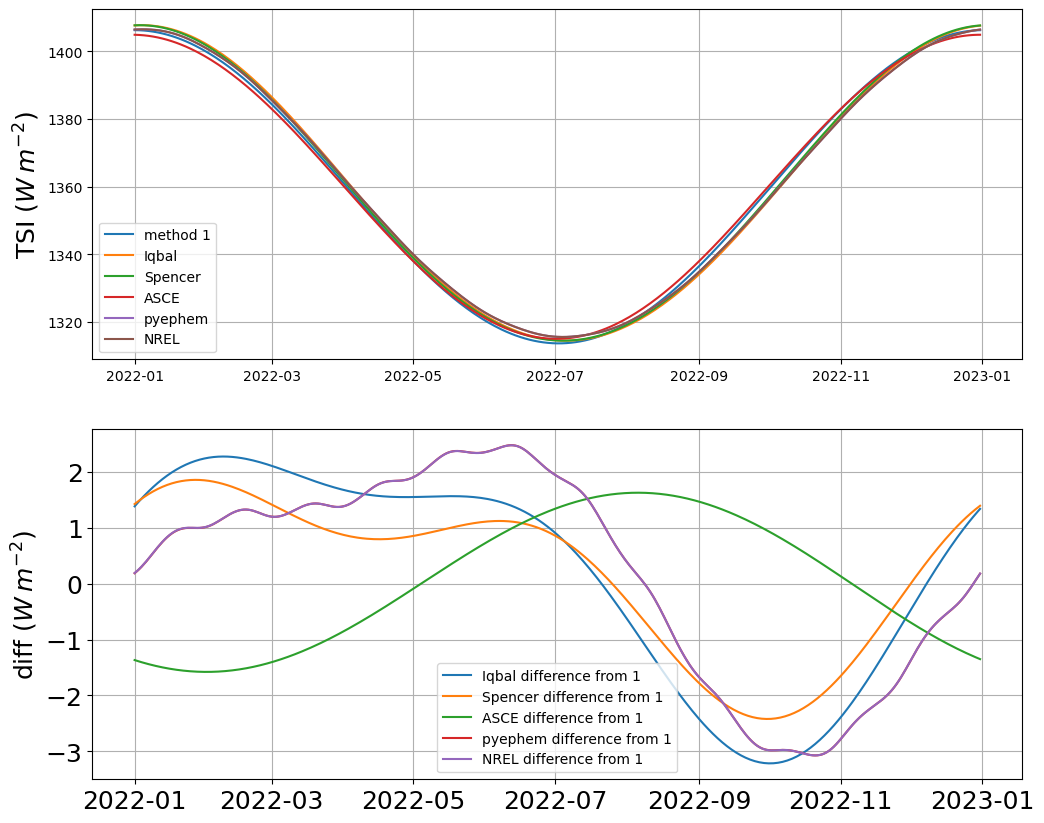

In [7]:
# Compute the TSI over a typical year using different methods


# set location and time-range (point near Hawaii, compute for 2022)
longitude = -158.0
start_date = "Jan 01 2022 01:00AM"
init_time = datetime.datetime.strptime(start_date, '%b %d %Y %I:%M%p')


# 1. First method; daily values over 365 days (NOTE independent of location)
Qo1 = [Io * ( 1.0 + 0.034 * np.cos(2.0*np.pi*day/365.25) ) for day in range(365)]

# 2. Iqbal method

#    Daily (3600 sec) synthetic data for one year
trange = 365                                 # in days
tdelta = 24 * 60 * 60                        # in seconds
n = int ( trange * 24 * 60 * 60 / tdelta )   # number of time points
Eo = [ eccentricity(i,init_time,tdelta,longitude) for i in range(n) ]
Qo2 = Io * np.array(Eo)

# 3. Various methods from pvlib
times = pd.date_range('2022-01-01', '2022-12-31', freq='1d')
Qo3 = pvlib.irradiance.get_extra_radiation(times, method='spencer',solar_constant=Io)
Qo4 = pvlib.irradiance.get_extra_radiation(times, method='asce',solar_constant=Io)
Qo5 = pvlib.irradiance.get_extra_radiation(times, method='pyephem',solar_constant=Io) 
Qo6 = pvlib.irradiance.get_extra_radiation(times, method='nrel',solar_constant=Io)

fig, ax = plt.subplots(figsize=(12,10), nrows = 2, ncols = 1)

ax[0].plot(times,Qo1, label = 'method 1')
ax[0].plot(times,Qo2, label = 'Iqbal')
ax[0].plot(Qo3, label = 'Spencer')
ax[0].plot(Qo4, label = 'ASCE')
ax[0].plot(Qo5, label = 'pyephem')
ax[0].plot(Qo6, label = 'NREL')
plt.tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('TSI ($W \: m^{-2}$)', fontsize = 18)
ax[0].grid()
ax[0].legend()

ax[1].plot( times, Qo2 - Qo1, label = 'Iqbal difference from 1')
ax[1].plot( times, Qo3 - Qo1, label = 'Spencer difference from 1')
ax[1].plot( times, Qo4 - Qo1, label = 'ASCE difference from 1')
ax[1].plot( times, Qo5 - Qo1, label = 'pyephem difference from 1')
ax[1].plot( times, Qo6 - Qo1, label = 'NREL difference from 1')
ax[1].set_ylabel('diff ($W \: m^{-2}$)', fontsize = 18)
ax[1].grid()
ax[1].legend()

plt.savefig('./output/tsi_eccen.png',format='png',facecolor='white')

<a id='sza'></a>

## 1b.  Solar Zenith Angle (SZA)

As noted above, the solar radiation reaching the ocean surface depends, among other things, on the solar zenith angle shown schematically in Figure 6 below.

<figure>
   <img src="./images/solar-angles.jpg" style="width:50%">
   <figcaption align = "center"><font color=dodgerblue>Figure 6.  Schematic of solar angles (from __need cite here__). </font></figcaption>
</figure>
<br>

The solar zenith angle ($\theta_o$ alternately $sza$) is a function of time and location.  The dependence on time and latitude might be obvious (seasonal and latitudinal changes in daylight hours for example).  Longitudinal dependence is more an artifact (usually) of converting between universal time (UTC) and local time.  For example, peak shortwave radiation usually occurs near noon locally, but this would correspond to a different UTC time depending on location.  We include this dependence here as most _in situ_ observations are measured in UTC time.

[back to the top](#notebook_top)

In [8]:
def sza(n,init_time,deltat,lat,lon):
    # This function computes the solar zenith angle (sza) over a
    # range of times.  The computed sza is based on time and latitude.
    # The function takes as input:
    #  1. n............time index to compute sza
    #  2. init_time....the starting time (in datetime format)
    #  3. deltat.......time resolution (in seconds)
    #  4. latitude.....latitude in degrees (negative for SH)
    #  5. longitude....longitude in degrees (negative for WH)
    # and provides as output:
    #  1. zh...........zenith angle (radians)
    #  2. st...........solar time ()
    #  3. tc...........hour of the day (midnight=0)
    #
    # NOTE:  the input should be in UTC, and this is converted to
    #   local time using the longitude to get the proper local
    #   time-of-day
    
    # time offset due to local timezone
    TZ = lon * 24.0 / 360.0
    time_offset = datetime.timedelta(hours=TZ,seconds=n*deltat)
    
    # Find time as year, month, day, hour, minute, second
    mtime = init_time + time_offset
    year = mtime.year
    mon = mtime.month
    day = mtime.day
    hour = mtime.hour
    minu = mtime.minute
    sec = mtime.second

    # compute solar declination
    fi = 23.44                                       # Tropic of Cancer latitude (deg)
    ty = 173.0                                       # day of summer solstice
    dyy = 365.25                                     # average number of days per year
    td = mtime.timetuple().tm_yday + ( TZ / 24.0  )  # day of year
    decl = fi * np.cos( 2.0 * np.pi * ( td - ty ) / dyy )
    
    # calculate solar time, hour of the day from midnight
    stdmerid = 15.0 * TZ
    locmerid = lon
    x = 360.0 * ( td - 81.0 ) / dyy
    x = x * np.pi / 180.0
    eot = 9.87 * np.sin(2*x) - 7.53 * np.cos(x) - 1.5 * np.sin(x)
    tc = ( locmerid - stdmerid ) * 4 + eot
    loctime = hour + minu / 60.0 + sec / 3600.0
    st = loctime + tc / 60.0
    if st < 0.0:
        st = 24.0 + st
    
    # calculate solar zenith angle
    lat_r = lat * np.pi / 180.0
    decl_r = decl * np.pi / 180.0
    t0 = 12
    a = np.sin( lat_r ) * np.sin( decl_r )
    b = np.pi / 180.0 * ( 180.0 * ( st - t0 ) / t0 )
    c = np.cos( lat_r ) * np.cos( decl_r ) * np.cos( b )
    zh = np.arccos( a + c )
    
    return zh, st, tc

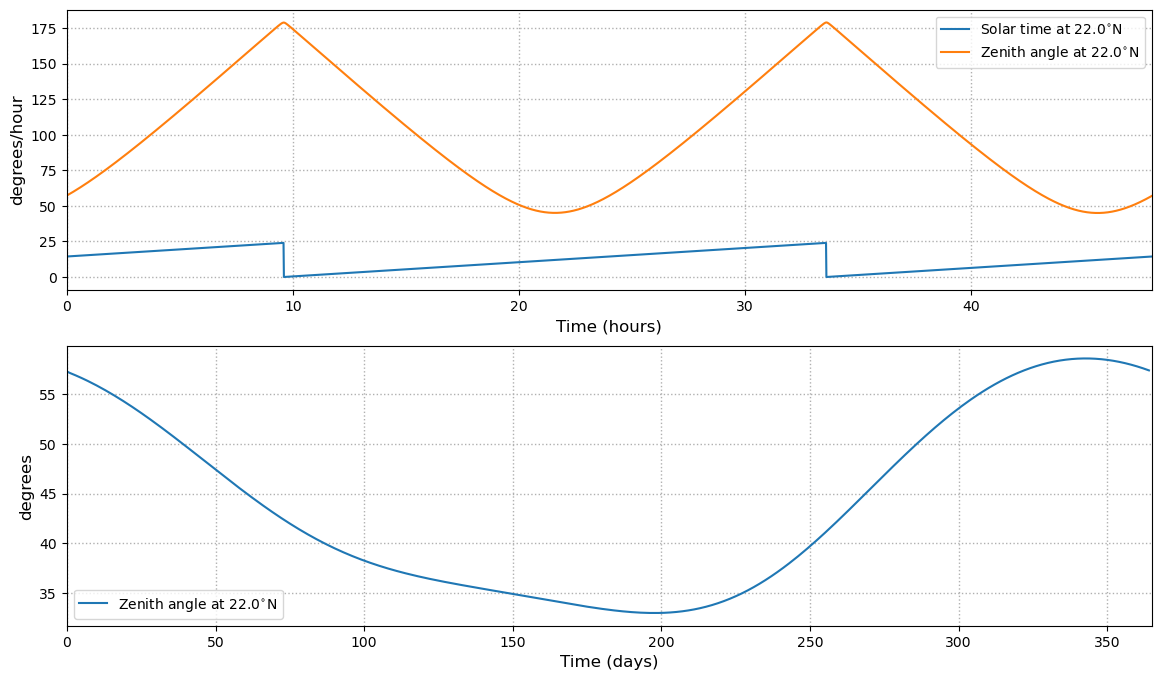

In [9]:
# Example sza
# pick longitude near Station ALOHA (158W)
longitude = -158.0
latitude = 22.0
start_date = "Jan 01 2022 01:00AM"
init_time = datetime.datetime.strptime(start_date, '%b %d %Y %I:%M%p')

# 1. one minute (60 sec) interval over two days
trange = 2
tdelta = 60

# call sza "n" times, where "n" is computed from "trange" in days 
# converted to seconds and "tdelta" in seconds.  For example, a
# trange of 2 (days) with a tdelta of 3600 (seconds) will return
# 48 values (hourly over two days)
n = int ( trange * 24 * 60 * 60 / tdelta )
t1 = np.arange(0,trange*24,1/tdelta)

za, st, hod = zip(*[ sza(i,init_time,tdelta,latitude,longitude) for i in range(n) ])
zenith_angle1 = [ x * 180.0/np.pi for x in list(za) ]
solar_time1 = list(st)

# 2. daily (3600 sec) interval over one year
trange = 365
tdelta = 24 * 60 * 60

n = int ( trange * 24 * 60 * 60 / tdelta )
za, st, hod = zip(*[ sza(i,init_time,tdelta,latitude,longitude) for i in range(n) ])
zenith_angle2 = [ x * 180.0/np.pi for x in list(za) ]
solar_time2 = list(st)

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(14,8))
ax[0].plot(t1, solar_time1, label='Solar time at ' + str(latitude) + '$^{\circ}$N')
ax[0].plot(t1, zenith_angle1, label='Zenith angle at ' + str(latitude) + '$^{\circ}$N')
ax[0].set_xlim([0,48])
ax[0].set_xlabel('Time (hours)', fontsize = 12)
ax[0].set_ylabel('degrees/hour', fontsize = 12)
ax[0].grid(linestyle=':', linewidth=1)
ax[0].legend()

ax[1].plot(zenith_angle2, label='Zenith angle at ' + str(latitude) + '$^{\circ}$N')
ax[1].set_xlim([0,365])
ax[1].set_xlabel('Time (days)', fontsize = 12)
ax[1].set_ylabel('degrees', fontsize = 12)
ax[1].grid(linestyle=':', linewidth=1)
ax[1].legend()

plt.savefig('./output/zenith_angle.png',format='png',facecolor='white')

<a id='clear'></a>

## 1c.  Clear Sky Shortwave Radiation

As described above, the net shortwave radiation at the ocean surface can be measured directly, computed based on paramterizations, or through a combination of both.  There are essentially three main components: incoming clear-sky irradiance, albedo, and atmospheric effects (clouds).  The first of these, clear-sky irradiance, can be computed in different ways, and here we investigate four of these:
 1. clear_sky1(time,lat,lon,date): based on Ohlmann and Seigel (2000), used in revised PWP
 2. clear_sky2(time,lat,lon,date): based on [Bretagnon and Francou (1988)](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1988A%26A...202..309B), used in the python package "pysolar"
 3. clear_sky3(time,lat,lon,date): based on Ineichen and Perez (2002) and used in the pvlib python package
 4. clear_sky4(time,lat,lon,date,...): based on [Fairall et al. (2008)](https://www.researchgate.net/publication/253589192_Observations_of_Cloud_Radiation_and_Surface_Forcing_in_the_Equatorial_Eastern_Pacific)
 
 <br>
 
 <font color=red>
    NOTES:
    
    1. I make the timezone as a negative number for Hawaii as western longitude is expressed as a negative number.  For example, TZ = (-157 * 24 / 360).  The Ohlmann calculation converts this as "day + TZ" while the other two as "time - TZ"
    
    2. The more precise time-zone offset, based on longitude (lon*24/360) is used to get a better representation of solar angle during the day, however, the more straightforward time-zone offset (_e.g._ , UTC+10 for Hawaii) is used to represent wall time
</font> 

[back to the top](#notebook_top)

### 1.c.1 Ohlmann and Siegel (2000)

\begin{eqnarray}
Q_{S}^{Clear} = \left[ a_L + b_L cos(\theta_o) \right] I_{o} E_{o} cos(\theta_o)
\end{eqnarray}

where,
 * $a_L$ = 0.61
 * $b_L$ = 0.20
 * $I_{o}$ = 1360.45
 * $E_{o}$ gives the seasonally vary Earth-Sun distance adjustment to the solar constant (so $I_{o}$ $E_{o}$ is the DNI)
 
| variable        | description         | code |
|-----------------|---------------------|------|
| $\theta_o$      | solar zenith angle  | zh   | 
| $I_o$           | solar constant      | Io   |
| $E_o$           | adjustment to $I_{o}$ for seasonal changes in Earth-Sun distance | Eo |
| $Q_{S}^{Clear}$ | clear-sky shortwave | Iclr |

In [10]:
# Method 1: Ohlmann and Siegel (2000)
# Input:
#   n.............time index in form 'seconds since' init_time
#   init_time.....initial time in datetime format
#   deltat........time interval in seconds
#   lat...........Latitude (degrees; negative for Southern Hemisphere)
#   lon...........Longitude (degrees; negative for Western Hemisphere)
#   
# Output:
#   Iclr..........Clear sky irradiance
  
def clear_sky1( n, init_time, deltat, lat, lon ):
    zh, st, sc = sza(n,init_time,deltat,lat,lon)
    Eo = eccentricity(n,init_time,deltat,longitude)
    # Calculate surface irradiance under clear sky
    # (from Lumb, 1964, see Soloviev and Lukas, 2014, page 22)
    aL = 0.61
    bL = 0.2
    ma = aL + bL * np.cos(zh)
    Iclr = ma * Io * Eo * np.cos(zh)
    if Iclr < 0:
        Iclr = 0.0
    return Iclr

### 1.c.2  Bretagnon and Francou (1988)

This parameterization comes from the python package __pysolar__ is used (see https://pysolar.readthedocs.io/en/latest/).
This program just returns the DNI.

In [11]:
# Method 2: pysolar
# https://pysolar.readthedocs.io/en/latest/
# pysolar returns the direct normal irradience (DNI) only
# Code is based on Bretagnon and Francou 1988 (http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1988A%26A...202..309B)

# Input:
#   n.............time index in form 'seconds since' init_time
#   init_time.....initial time in datetime format
#   deltat........time interval in seconds
#   lat...........Latitude (degrees; negative for Southern Hemisphere)
#   lon...........Longitude (degrees; negative for Western Hemisphere)
#   
# Output:
#   Iclr..........Clear sky irradiance
  
def clear_sky2( n, init_time, deltat, lat, lon ):
    TZ = lon * 24.0 / 360.0
    time_offset = datetime.timedelta(hours=TZ,seconds=n*deltat)
    
    # Find time as year, month, day, hour, minute, second
    #mtime = init_time + time_offset
    mtime = pd.to_datetime(n, unit='h', origin = init_time, utc = True).to_pydatetime()
    altitude_deg = get_altitude(lat, lon, mtime)
    DNI = radiation.get_radiation_direct(mtime, altitude_deg)
    
    # get DHI from Ineichen (clear_sky3)
    res2 = [n]
    mtime2 = pd.to_datetime(res2,unit='h',origin = pd.Timestamp(init_time))
    tus = Location(lat, lon, 'US/Hawaii', 0, 'Honolulu')
    cs = tus.get_clearsky(mtime2)
    DHI = cs.iloc[0,2]
    GHI = cs.iloc[0,0]
    if cs.iloc[0,1] == 0:
        cos_theta = 0.0
    else:
        cos_theta = ( GHI - DHI ) / cs.iloc[0,1]
    Iclr = DNI * cos_theta + DHI
    if ( Iclr < 0.0 ):
        Iclr = 0.0
    return Iclr, DNI, DHI

### 1.c.3  Ineichen and Perez (2002)

This comes from the __pvlib__ program (https://pvlib-python.readthedocs.io/en/stable/), and unlike __pysolar__ it computes both the DHI and DNI, thus giving the global (or total) clear-sky.

This routine returns a three-dimensional array.  The columns are GHI (Global Horizontal Irradiance), DNI (Direct Normal Irrandiance) and DHI (Diffuse Horizontal Irradiance).  So, before we had
\begin{eqnarray}
Q_{S}^{Clear} = DNI \: cos(\theta_o) + DHI
\end{eqnarray}
and here we have
\begin{eqnarray}
GHI = DNI \: cos(\theta_o) + DHI
\end{eqnarray}
Note that we just return the first column (GHI).

In [12]:
# Method 3: pvlib
# Input:
#   time.....Time (hours since "date"; UTC)
#   lat......Latitude (degrees; negative for Southern Hemisphere)
#   lon......Longitude (degrees; negative for Western Hemisphere)
#   date.....Start date of calculation, string in form '1964-08-28 0:00:00';
#            Note that "time" is hours since this time
# Output:
#  Iclr......Clear sky irradiance

def clear_sky3( time, lat, lon, date ):
    tus = Location(lat, lon, 'US/Hawaii', 0, 'Honolulu')
    res = [time]
    mtime = pd.to_datetime(res, unit='h', origin = pd.Timestamp(date))
    cs = tus.get_clearsky(mtime)  # ineichen with climatology table by default
    # row = 0; columns are ghi (Global Horizontal Irradiance), dni (Direct Normal Irradiance), 
    #          and dhi (Diffuse Horizontal Irradiance) [0,1,2]; here we just use GHI
    Iclr = cs.iloc[0,0]
    return Iclr, cs.iloc[0,1], cs.iloc[0,2]

### 1.c.4  Fairall et all (2008)

The formulation separates DHI and DNI.  First, if the integrated water vapor is zero, the DHI is also set to zero, and the DNI reduces to $Q_{o}$.  Otherwise, DNI is a function of various atmospheric scattering processing, including Rayleigh ($T_r$), ozone ($T_o$), uniform gases ($T_g$), water vapor ($T_W$), aerosols ($T_a$) and the solar constant ($I_{o}$):

\begin{eqnarray}
DNI = I_o * T_r * T_o * T_g * T_w * T_a
\end{eqnarray}
 
The diffusive flux (DHI) is more complicated, and is a function of the above components and more.

<font color='red'>
Issues/questions:
    
 * In SolarRadiancey.m, the solar constant ($s0$ used in the code; $I_{o}$ here) is set to 1367 and then TSI ($s$ in the code, $Q_{o}$ here) is computed based on time (this seems correct).  However, later there is a check for if water vapor is less than zero (presumably this mean completely clear sky), and if this happens, the DNI is set to $s$ and DHI is set to 0.  On the other hand, if water vapor is not negative, solflux.m is used to compute DNI and DHI.  In this script, the solar constant is set to 1360 ($Isc$ in the code); TSI is not used.
 * Not sure
</font>

The Fairall code came in a few different matlab scripts:
 * __Atomic_Rsclear_1hr_noplot.m__:  calls SolarRadiancey.m to get solar irradiance (and plots); qrat=5, p=1010, k1=k2=ksol (variable, set in PSL_NTAS_compare_atomic.m); watvap read in
 * __PSL_NTAS_compare_atomic.m__:  calls Atomic_Rsclear_1hr_noplot.m to get clear sky irrandiance (sw) and compares that to observed at NTAS
 * __Read_WHOI_buoydata_2020_2.m__: read obs from netcdf files (FLTS computed values), compute irrandiance from WHOI_2011_Rsclear_2.m; vap is set to 5, emmisivity clear is qa/5; later, water vapor (iv) is interpolated and divided by 4 for qs_clear
 * __SolarRadiancey.m__: compute irradiance from lat,lon,water vapor pressure (g/m2), pressure (mb), ozone, and two aerosol absorbtion coefficients (k1,k2); s0 is set to 1367
 * __WHOI_2011_Rsclear_2.m__: compute irradiance from SolarRadiancey.m using k1=k2=l=0; pressure and water vapor read in (if no watvap, set to qax(ii)/qrat)
 * __solflux.m__: compute irradiance; called by SolarRadiency.m; Qo set to 1360
 * __tdew.m__: compute dew point temperature from pressure and spec humid
 
| variable        | description                   | code        | Value                       |
|-----------------|-------------------------------|-------------|-----------------------------|
| $\theta_o$      | solar zenith angle            | sz          | $f(t,lat,lon)$              |
| $\delta$        | solar declination             | saz         | $f(t,lat,lon)$              |
| $I_o$           | solar constant                | s0, Isc     | constant                    |
| $Q_o$           | total solar irradiance (TSI)  | s           | $f(t)$                      |
| $DNI$           | direct normal irradiance      | direct*, In | $f(\theta_o,Tr,To,Tg,Tw,Ta)$|
| $DHI$           | diffuse horizontal irradiance | sky, Id     | $f(I_o,mu,To,Tg,Tw,Ta,w0aer,Ma,Tr,fc,Ini,ag)$|
| $Q_{S}^{Clear}$ | clear-sky shortwave           | sw          | $f(DHI,DNI)$                | 
| $P$             | atmosheric pressure           | p           | constant                    |
| $iv$            | water vapor                   | watvap      | constant, $q_a/5$           |
| $q_a$           | specific humidity             | qa          | constant/read from obs      |
| $k_1$, $k_2$    | aerosol absorb coefs          | k1,k2       | constant                    |
| $l$             | ozone absorb coef             | l           | constant                    |
| .               | Rayleigh scattering           | Tr          | $f(Ma))$                    |
| .               | Ozone scattering              | To          | $f(ozone,\theta_o)$         |
| .               | Uniform gases scattering      | Tg          | $f(Ma)$                     |
| .               | Water vapor scattering        | Tw          | $f(water vapor,\theta_o)$   |
| .               | Aerosol scattering            | Ta          | $f(k1,k2,Ma)$               |
| .               | .                             | Taa         | $f(w0aer,Ma,Ta)$            |
| .               | .                             | ag          | constant                    |
| $f_c$           | Cloud fraction                | fc          | constant                    |
| .               | .                             | w0aer       | constant                    |
| .               | Relative optical air mass     | Ma          | $f(P,\theta_o)$             |

* the original code uses dir, but that is an internal python function, so I changed it to direct


In [13]:
# Method 4: WHOI 2011 "epic01_Rscldar_5" (as sent by Chris Fairall)

#   This is based on M. Iqbal in "Physical Climatology for Solar and Wind Energy", 1988, 
#   World Scientific, pp. 196-242.  
#  This is based on a set of two routines: solfluxy.m and SolarRadiancey.m

# Input:
#   alat, alon...latitude and longitude in degrees
#   time.........hour of year (e.g., 10AM on Jan 15th would be 15*24+10)
#   date.........start of timeseries (e.g., '2020-01-04 21:00:00')
#   watvap.......integrated water vapor (g/m^2) -- use 5 for TWP, default = 3.0
#   p............pressure, default = 1013 hPa
#   k1, k2.......aerosol absorbtion coefs, default = 0.3
#   l............ozone thickness, default = 0.3

# Output:
#   sw...........total solar flux through a horizontal surface
#   sz...........zenith declination (deg)
#   saz..........solar azimuth (deg)
#   direct.......direct beam irradiance on a surface normal to the beam.
#   sky..........diffuse component on a horizontal surface

def clear_sky4( time, alat, alon, date, watvap, p, k1, k2, l):
    mtime = pd.to_datetime(time, unit='h', origin = pd.Timestamp(date))
    jd = mtime.dayofyear
    tutc = float( mtime.hour ) + float (mtime.minute) / 60.0 + float(mtime.second) / 3600.0

    # constants
    s0 = 1360.45
    s1 = -105.0
    s2 = 596.2
    s3 = 4.3
    s4 = -12.7
    c1 = -429.3
    c2 = -2.1
    c3 = 19.3
    rlat = alat * np.pi / 180.0
    rlon = alon * np.pi / 180.0
    colatr = ( 90.0 - alat ) * np.pi / 180.0

    an = jd - 0.5 + tutc / 24.0
    
    al = 280.460 + 0.9856474 * an
    al = al%360.0
    if al < 0:
        al = al + 360.0

    g = 357.528 + 0.9856003 * an
    g = g%360.0
    if g < 0:
        g = g + 360.0
    gr = g * np.pi / 180.0

    # compute sun/Earth distance and normal insolation
    r = 1.00014 - 0.01671 * np.cos(gr) - 0.00014 * np.cos(2.0 * gr)
    s = s0 / (r * r)

    # compute ecliptic longitude
    alambda = al + 1.915 * np.sin(gr) + 0.020 * np.sin(2.0 * gr)
    rlambda = alambda * np.pi / 180.0
    
    # compute ecliptic obliquity
    epsilon = 23.439 - 0.0000004 * an
    te = np.tan(epsilon * 0.5 * np.pi / 180.0)
    te = te * te
    alpha = alambda - 180.0/np.pi * te * np.sin( 2.0 * rlambda ) + 0.5 * 180.0/np.pi * te * te * np.sin( 4.0 * rlambda) 

    # compute solar declination for this day
    sin_dec = np.sin(epsilon*np.pi/180.0)*np.sin(rlambda)
    solar_dec = np.arcsin(sin_dec)
    cos_dec = np.cos(solar_dec)
    eq_time = ( al - alpha ) * 4.0 / 60.0
    s_hour = tutc + eq_time
    hour_ang = np.pi * ( s_hour - 12.0 ) / 12.0 + rlon
    cos_h = np.cos(hour_ang)
    c_solar_z = np.sin(rlat) * sin_dec + np.cos(rlat) * cos_dec * cos_h
    s_z = np.arccos(c_solar_z)

    # compute zenith angle and azimuth angle
    zz = 0
    sz = s_z * 180.0/np.pi
    s_az = ( np.cos(np.pi * 0.5 - solar_dec) - np.cos(colatr) * c_solar_z) / ( np.sin(colatr) * np.sin(s_z) )
    saz = np.arccos(s_az) * 180.0 / np.pi
    if zz > 0:
        saz = 360.0 - saz
    
    # compute shortwave irradiance
    if watvap < 0:
        direct = s
        sky = 0
        sw = s * np.cos(sz * np.pi / 180.0)
    else:
        direct, sky = solfluxy(sz,watvap,p,k1,k2,l)
        sw = sky + direct * np.cos(sz * np.pi / 180.0)

    if sky < 0.0:
        sky = 0.0

    #return sw, sz, saz, direct, sky
    return sw, direct, sky

In [14]:
def solfluxy(zdeg,w,p,k1,k2,l):
    #  Compute transmittance and flux (based on solfluxy.m)
    # Input:
    #    zdeg....zenith angle in degrees
    #    w.......integrated water vapor (g/cm^2) typically 5 for TWP
    #    p.......surface pressure in hPa (optional, default = 1013)
    #    k1......aerosol optical thickness at 380 nm (optional, default = 0.0)
    #    k2......aerosol optical thickness at 500 nm (optional, default = 0.0)
    #    l.......ozone-layer thickness in cm(NTP) (optional, default = 0.3)
    # Return:
    #    In......direct-Normal flux at surface
    #    Id......diffuse flux at surface
    #    Tr......transmittance by Rayleigh scattering
    #    To......transmittance by ozone
    #    Tg......transmittance by uniformly mixed gases
    #    Tw......transmittance by water vapor
    #    Ta......transmittance by aerosol

    # define constants 
    w0aer = 0.0
    fc = 0.84
    ag = 0.2

    # clip zenith angles to be less than 90
    if zdeg > 89.99:
        zdeg = 89.99
    mu = np.cos(zdeg*np.pi/180.0)

    # compute air mass and other properties
    Mr = 1.0 / (mu + 0.15 * (93.885 - zdeg )**(-1.253) )
    Ma = Mr * (p / 1013.25)
    U1 = w * Mr
    U3 = l * Mr
    ka = 0.2758 * k1 + 0.35 * k2

    # first calculate the transmittances due to various species
    # Rayleigh Scattering
    if zdeg <= 85:
        Tr = np.exp(-0.0903 * Ma**0.84 * (1.0 + Ma - Ma**1.01))
    else:
        Tr = np.exp(-1.0*(0.0738 + (zdeg-85.0)*0.03) * Ma**0.84)

    # ozone scattering
    To = 1 - (0.1611 * U3 * (1.0+139.48 * U3)**(-0.3035) - 0.002715 * U3 / (1.0 + 0.044 * U3 + 0.0003 * U3**2))

    # uniform gases scattering
    Tg = np.exp(-0.0127 * Ma**0.26)

    # water vapor scattering
    Tw = 1.0 - 2.459 * U1 / ( ( 1.0 + 79.034 * U1 )**0.6828 + 6.385 * U1 )

    # aerosol scattering
    Ta = np.exp(-ka**0.873 * (1.0 + ka - ka**0.7088) * Ma**0.9108)

    # direct normal flux
    In = Io * Tr * To * Tg * Tw * Ta

    # diffuse component
    Taa = 1.0 - (1.0 - w0aer) * (1.0 - Ma + Ma**1.06) * (1.0-Ta)

    Idr = 0.79 * Io * mu * To * Tg * Tw * Taa * (0.5 * (1-Tr)) /(1-Ma+Ma**1.02)
    Tas = Ta / Taa
    Ida = 0.79 * Io * mu * To * Tg * Taa * (fc * (1-Tas)) / (1-Ma+Ma**1.02)
    aa = 0.0685+(1-fc) * (1-Tas)
    Idm = (In * mu + Idr + Ida) * (ag * aa / (1-ag * aa))
    Id = Idr + Ida + Idm

    if Id < 0:
        Id = 0
    
    return In, Id

### 1.c.5 Some comparisons between methods

In this section we do a direct comparison between the different clear sky parameterizations.  The models are run at daily interval for a whole year, so it takes a few minutes to run.  We use the WHOTS mooring location as our test site (note this provides the lat/lon and time/timezone needed in the calculations).  The input and output are based on UTC time; note that the Ohlmann method (clear_sky1) requires the timezone as computed from longitude to get the proper sun angle, otherwise this timezone is not used in any calculations.

[back to the top](#notebook_top)

In [15]:
# Run all four parameterizations for a year at WHOTS location
lat = 21.2980459
lon = -157.8187884
initial_time_utc = '2019-01-01 00:00:00'
init_time = datetime.datetime.strptime(initial_time_utc, '%Y-%m-%d %H:%M:%S')

# set the interval for the calculation (dt, in hours) and the number of days to run (ndays)
dt = 1.0
ndays = 365.0

# define time axis
utc_time = pd.to_datetime([i for i in range(int(dt)*24*int(ndays))], unit='h', origin = pd.Timestamp(initial_time_utc))

# run all four models
nmax = int(24*ndays/dt)
cls1 = [ clear_sky1(i,init_time,dt*3600,lat,lon) for i in range(nmax) ]
cls2 = [ clear_sky2(i,init_time,dt*3600,lat,lon) for i in range(nmax) ]
cls3 = [ clear_sky3(i,lat,lon,initial_time_utc) for i in range(nmax) ]
cls4 = [ clear_sky4(i,lat,lon,initial_time_utc,3.0,1010.0,0.07,0.07,0.1) for i in range(nmax) ]

# combine results into a DataFrame, UTC time as index
cls_example = pd.DataFrame({'Time': utc_time, 'Ohlmann': cls1, 
                            'pysolar_ghi': [cls2[i][0] for i in range(nmax)],
                            'pysolar_dni': [cls2[i][1] for i in range(nmax)],
                            'pysolar_dhi': [cls2[i][2] for i in range(nmax)],
                            'pvlib_ghi': [cls3[i][0] for i in range(nmax)], 
                            'pvlib_dni': [cls3[i][1] for i in range(nmax)],
                            'pvlib_dhi': [cls3[i][2] for i in range(nmax)],
                            'Fairall_ghi': [cls4[i][0] for i in range(nmax)],
                            'Fairall_dni': [cls4[i][1] for i in range(nmax)],
                            'Fairall_dhi': [cls4[i][2] for i in range(nmax)] })
cls_example = cls_example.set_index('Time')

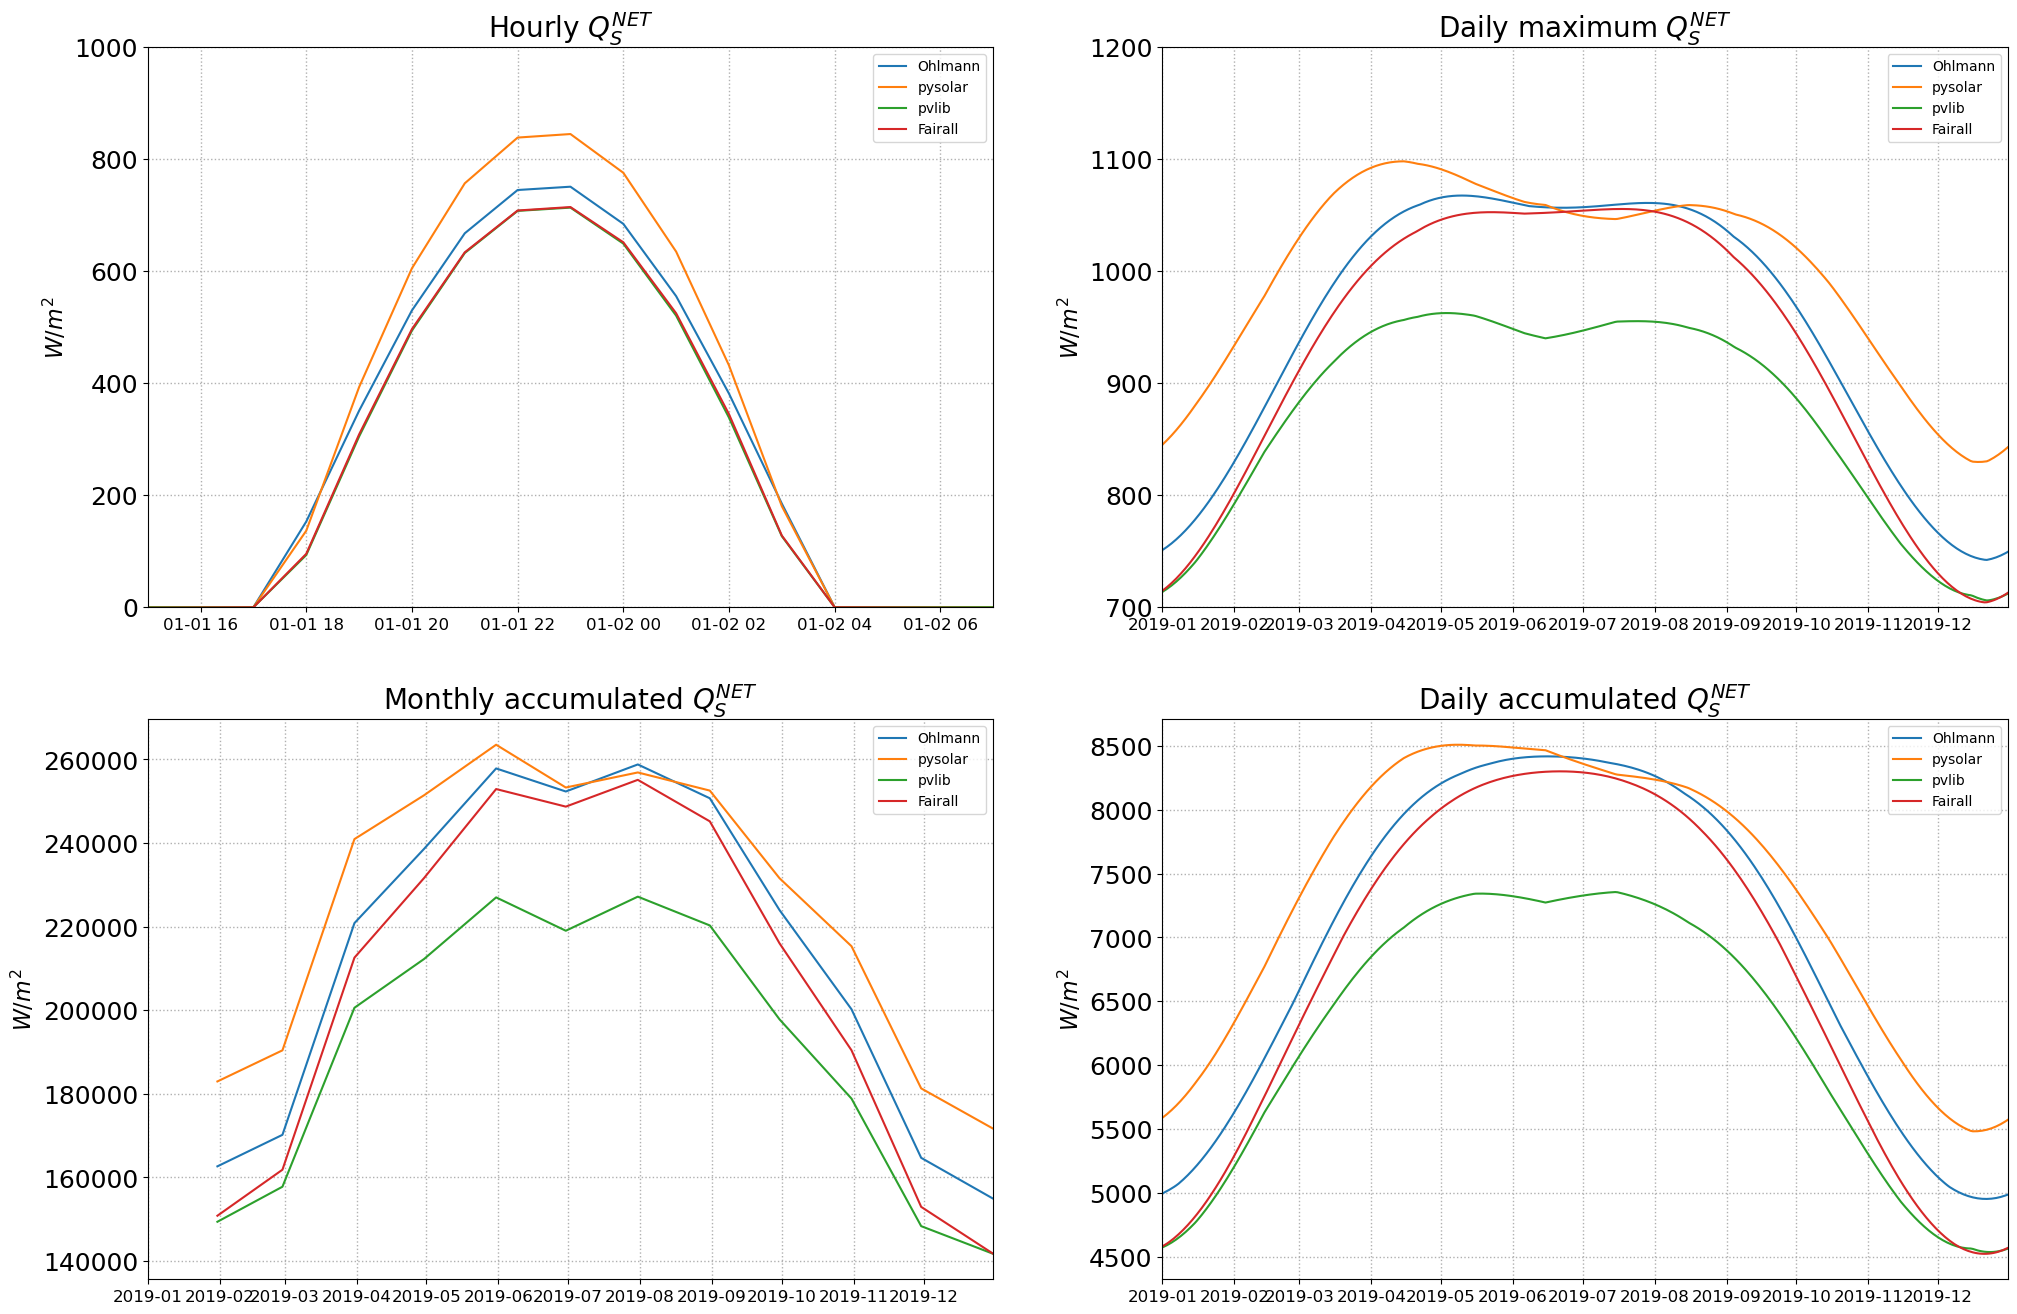

In [16]:
# Make figure
fig, ax = plt.subplots( nrows = 2, ncols = 2, figsize = ( 24, 16 ) )
plt.tick_params(axis='both', which='major', labelsize=18)
# raw data

ax[0,0].plot(cls_example['Ohlmann'],label='Ohlmann')
ax[0,0].plot(cls_example['pysolar_ghi'],label='pysolar')
ax[0,0].plot(cls_example['pvlib_ghi'],label='pvlib')
ax[0,0].plot(cls_example['Fairall_ghi'],label='Fairall')

ax[0,0].set_xlim([datetime.datetime(2019, 1, 1, 15, 0, 0), datetime.datetime(2019, 1, 2, 7, 0, 0) ])
ax[0,0].set_ylim(0,1000)
ax[0,0].set_title('Hourly $Q_{S}^{NET}$', fontsize = 20)

# daily max data
ax[0,1].plot(cls_example['Ohlmann'].resample('D').max(),label='Ohlmann')
ax[0,1].plot(cls_example['pysolar_ghi'].resample('D').max(),label='pysolar')
ax[0,1].plot(cls_example['pvlib_ghi'].resample('D').max(),label='pvlib')
ax[0,1].plot(cls_example['Fairall_ghi'].resample('D').max(),label='Fairall')

ax[0,1].set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 12, 31)])
ax[0,1].set_ylim(700,1200)
ax[0,1].set_title('Daily maximum $Q_{S}^{NET}$', fontsize = 20)

# monthly
ax[1,0].plot(cls_example['Ohlmann'].resample('M').sum(),label='Ohlmann')
ax[1,0].plot(cls_example['pysolar_ghi'].resample('M').sum(),label='pysolar')
ax[1,0].plot(cls_example['pvlib_ghi'].resample('M').sum(),label='pvlib')
ax[1,0].plot(cls_example['Fairall_ghi'].resample('M').sum(),label='Fairall')

ax[1,0].set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 12, 31)])
ax[1,0].set_title('Monthly accumulated $Q_{S}^{NET}$', fontsize = 20)

# daily
ax[1,1].plot(cls_example['Ohlmann'].resample('D').sum(),label='Ohlmann')
ax[1,1].plot(cls_example['pysolar_ghi'].resample('D').sum(),label='pysolar')
ax[1,1].plot(cls_example['pvlib_ghi'].resample('D').sum(),label='pvlib')
ax[1,1].plot(cls_example['Fairall_ghi'].resample('D').sum(),label='Fairall')

ax[1,1].set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 12, 31)])
ax[1,1].set_title('Daily accumulated $Q_{S}^{NET}$', fontsize = 20)


for row in range(2):
    for col in range(2):
        ax[row,col].set_ylabel('$W/m^2$', fontsize = 16)
        ax[row,col].legend()
        ax[row,col].grid(linestyle=':', linewidth=1)
        ax[row,col].tick_params(axis='y', which='major', labelsize=18)
        ax[row,col].tick_params(axis='x', which='major', labelsize=12)

# save figure
plt.savefig('./output/example_cls.png',format='png',facecolor='white')

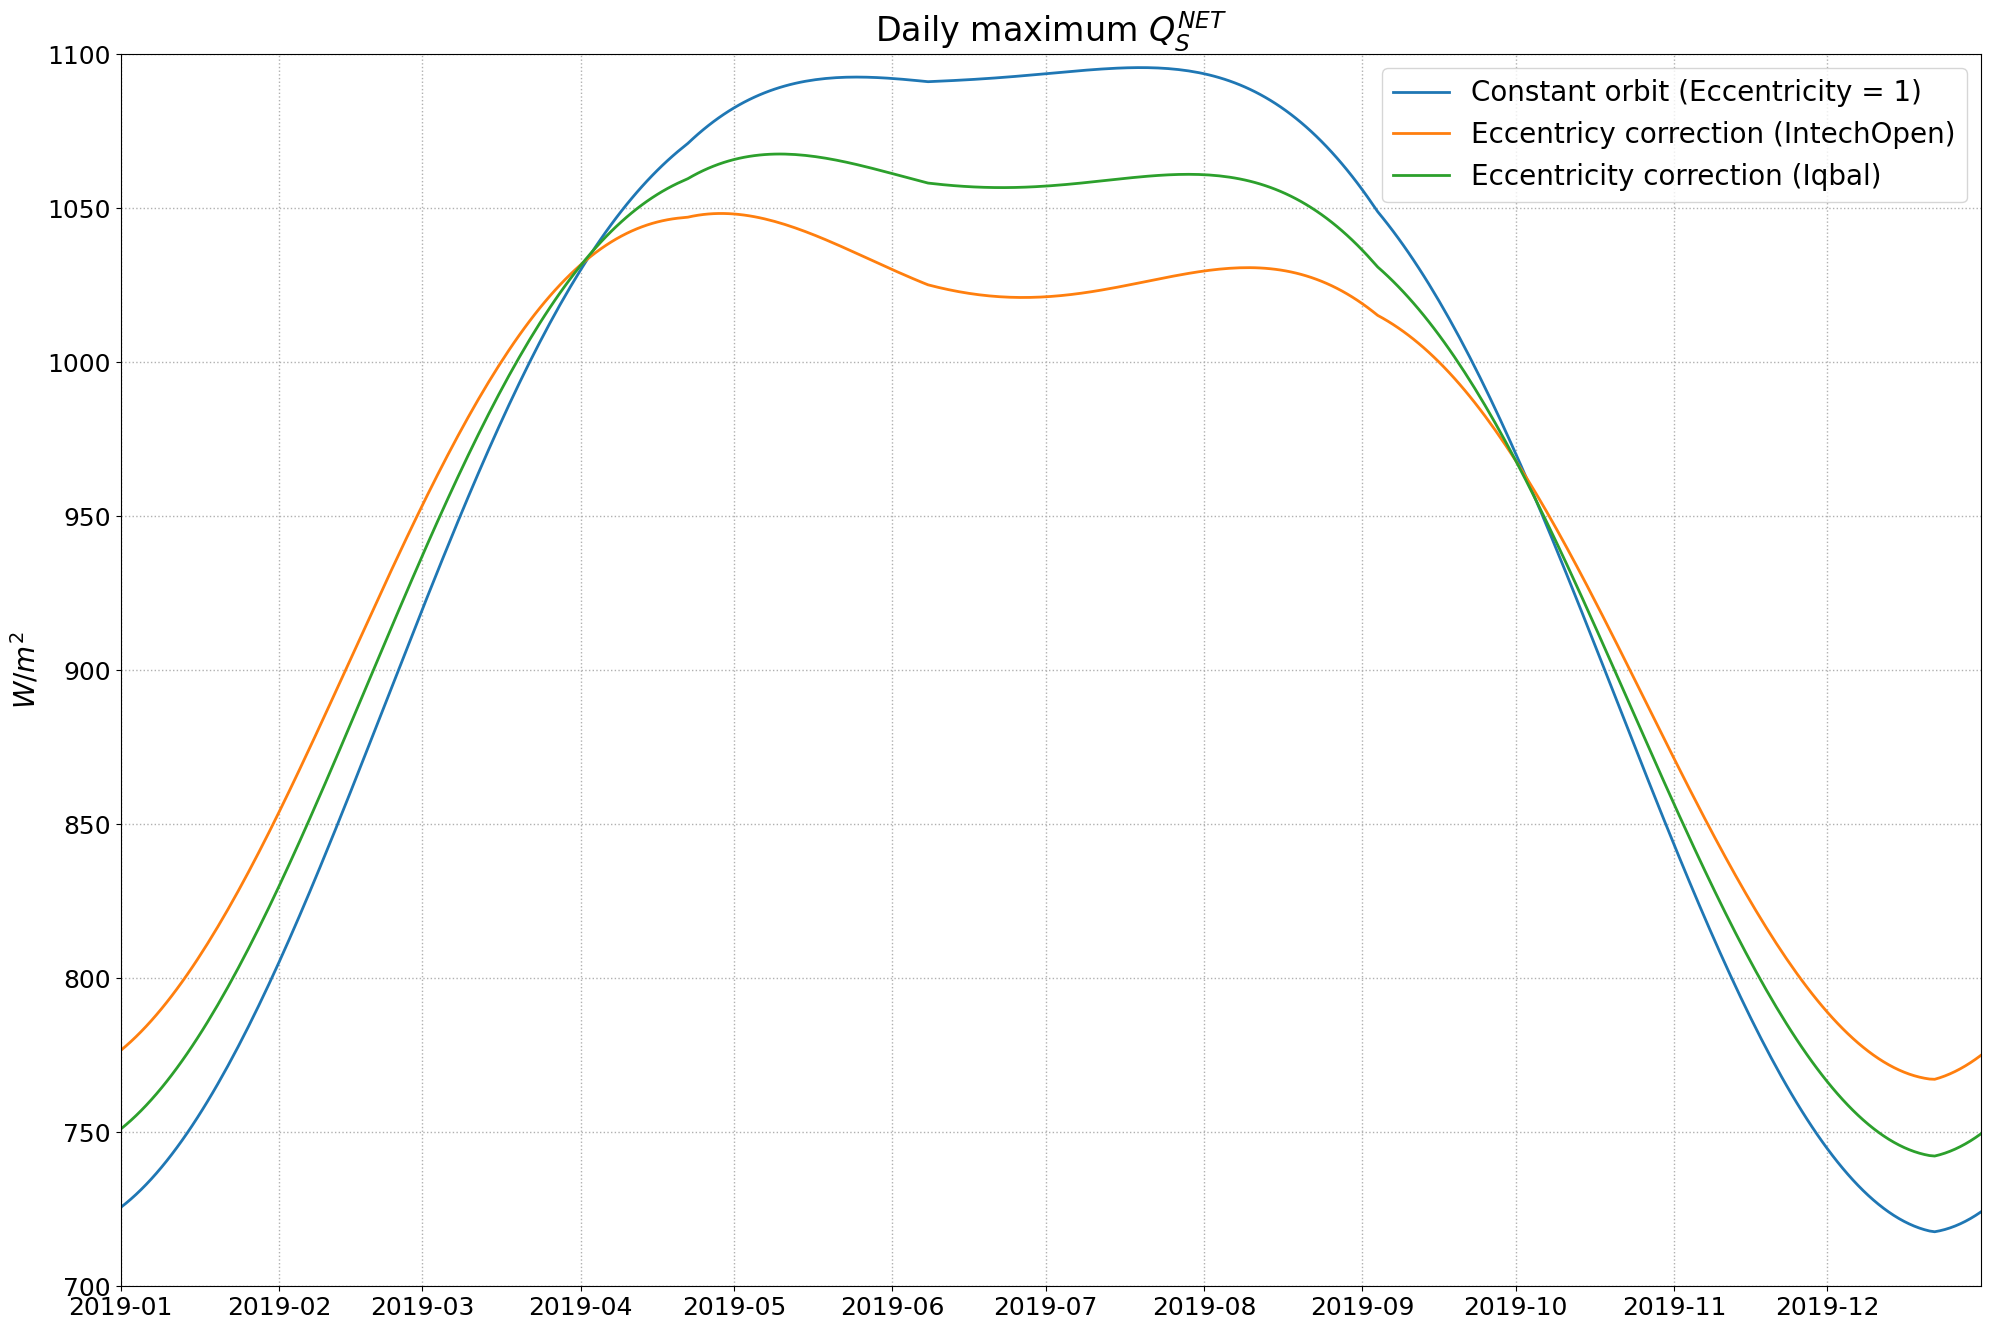

In [17]:
# compare effect of eccentricity
lat = 21.2980459
lon = -157.8187884
initial_time_utc = '2019-01-01 00:00:00'
init_time = datetime.datetime.strptime(initial_time_utc, '%Y-%m-%d %H:%M:%S')

# set the interval for the calculation (dt, in hours) and the number of days to run (ndays)
dt = 1.0
ndays = 365
nmax = int(24*ndays/dt)

Eo1 =  [ eccentricity(n,init_time,dt*3600,longitude) for n in range(nmax) ]
Eo2 = [( 1.0 + 0.034 * np.cos(2.0*np.pi*day/24.0/365.25) ) for day in range(nmax)]
cls = [ clear_sky1(i,init_time,dt*3600,lat,lon) for i in range(nmax) ]

# cls0 is clearsky with no eccentricity
cls0 = [i / j for i, j in zip(cls,Eo1)]
# cls1 is clearsky with IntechOpen param
cls1 = [i * j for i, j in zip(cls,Eo2)]
# cls2 is clearsky with Iqbal
cls2 = cls

# combine results into a DataFrame, UTC time as index
utc_time = pd.to_datetime([i for i in range(int(dt)*24*int(ndays))], unit='h', origin = pd.Timestamp(initial_time_utc))
ecc_example = pd.DataFrame({'Time': utc_time, 'cls0': cls0, 'cls1': cls1, 'cls2': cls2})
ecc_example = ecc_example.set_index('Time')

# make plot
fig, ax = plt.subplots( figsize = ( 24, 16 ) )

ax.plot(ecc_example['cls0'].resample('D').max(),linewidth=2,label='Constant orbit (Eccentricity = 1)')
ax.plot(ecc_example['cls1'].resample('D').max(),linewidth=2,label='Eccentricy correction (IntechOpen)')
ax.plot(ecc_example['cls2'].resample('D').max(),linewidth=2,label='Eccentricity correction (Iqbal)')
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 12, 31)])
ax.set_ylim(700,1100)
ax.set_title('Daily maximum $Q_{S}^{NET}$', fontsize=24)
ax.set_ylabel('$W/m^2$', fontsize=20)
ax.legend(fontsize=20)
ax.grid(linestyle=':', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=18)

<a id='dhi'></a>

## 1d. Diffuse Horizontal Irradiance (DHI)

As noted above, the downward shortwave radiation can be separated in DNI (direct normal) and DHI (diffuse horizontal).  There are a couple different ways to get DHI.  One comes from Ridley et al. (2010); this is used in Fernando's code.  Other ways are available from the pvlib package (https://pvlib-python.readthedocs.io/en/stable/reference/irradiance/class-methods.html).  It should be noted that in our analyses, DHI is only used to compute albedo.  In all other cases (_e.g._ clear sky calculations) we typically use the GHI or net irradiance.

The Ridley et al. (2010) code actually computes the diffusive solar fraction, defined as the ratio of $DHI$ to $GHI$ (or $Q_{S}^{down}$).  It is computed from a clearness index, $k_t$, as

\begin{eqnarray}
d = \left (1 \: + \: e^{-5.0033+8.6025k_{t}} \right)^{-1}
\end{eqnarray}

where $k_t$ is given by 

\begin{eqnarray}
k_t = \frac{Q_{S}^{down}}{I_o E_o}
\end{eqnarray}

Thus, $DHI$ can be derived from $d \: Q_{S}^{down}$.

The alternate method (_pvlib_DHI_) is from the pvlib utility. 

[back to the top](#notebook_top)

In [18]:
def ridley_DHI(ntimes,init_time,deltat,lat,lon,Qs_in):
    # This function computes the diffusive horizontal irradiance based
    # on the input (typically measured) downward solar radiation over
    # a range of times.  It is typically used in the computation of albedo.
    # It calls "sza" to get the solar zenith angle, and works on an input
    # timeseries of Qs.
    # It takes as input:
    #  1. lat............latitude in degrees (negative for SH)
    #  2. lon............longitude in degrees (negative for WH)
    #  3. ntimes.........number of points to compute DHI over
    #  4. init_time......the starting time (in datetime format)
    #  5. QS_in..........time-varying downward shortwave
    # and provides as output:
    #  1. zh.............zenith angle (radians)
    #  2. d_diff.........DHI
    #
    # NOTE:  the input should be in UTC, and this is converted to
    #   local time using the longitude to get the proper local
    #   time-of-day
    
    pi2 = np.pi / 180.0
    Ho = []
    zh = []
    AST = []
    AST_day = []

    for i in range(ntimes):
        # Calculate Zenith angle
        c1, c2, c3 = sza(i,init_time,deltat,lat,lon)
        zh = np.append(zh,c1)
        AST = np.append(AST,c2)
        AST_day = np.append(AST_day,c3)
    
        # calculate Eccentricity correction of the earth's orbit
        # (From Iqbal, 1983, Solar Radiation book)
        
        TZ = lon * 24.0 / 360.0
        time_offset = datetime.timedelta(hours=-TZ,seconds=i*deltat)
        mtime = init_time + time_offset
        yr = mtime.year
        mo = mtime.month
        dy = mtime.day
        hr = mtime.hour
        mn = mtime.minute
        sc = mtime.second
        
        doy = mtime.timetuple().tm_yday  # day of year
        if doy < 1.0:
            doy = doy + 365.0
        dn = np.floor(doy)
        
        da = 2*np.pi*(dn-1)/365  # day angle (radians)
        Eo = 1.00011 + 0.034221*np.cos(da) + 0.00128*np.sin(da) + 0.000719*np.cos(2*da) + 0.000077*np.sin(2*da)
        c1 = Io*Eo*np.cos(zh[i])
        #c1 = Io * Eo
        if ( c1 < 0 ):
            c1 = 0
        Ho = np.append(Ho,c1)
        
    # Calculate diffuse solar fraction with BRL model (Ridley et al., 2010), 
    # needed in Jin et al (2011) albedo model
    kt = Qs_in/Ho
    kt[kt == np.inf] = 0.0
    psi = np.empty_like(kt)
    psi[:] = kt
    psi[1:-2] = (kt[0:-3] + kt[2:-1])/2.0  # persistence
    
    # Calculate Daily clearness index
    Ndt = int( 86400.0 / deltat) # number of data points in a day
    csHo = np.nancumsum(Ho)
    csIi = np.nancumsum(Qs_in)
    Kt = np.empty_like(kt)
    Kt[:] = kt
    Kt[0] = csIi[Ndt]/csHo[Ndt]  
    Kt[1:-Ndt] = np.divide(csIi[Ndt+1:]-csIi[0:-Ndt-1],csHo[Ndt+1:]-csHo[0:-Ndt-1])
    Kt[-Ndt:] = Kt[-Ndt-1]
    alf = np.pi/2 - zh  # solar altitude (90 deg - zenith angle)
    alf_deg = alf*180/np.pi # solar altitude in degrees
    
    # Calculate solar diffuse fraction
    d_diff = 1/(1+np.exp(-5.38 + 6.63*kt + 0.006*AST - 0.007*alf_deg + 1.75*Kt + 1.31*psi))
    
    l = np.argwhere(zh >= np.pi/2)
    if l.size > 0:
        d_diff[l] = 0
    
    return d_diff

In [19]:
def pvlib_DHI(time1,time2,lat,lon):
    
    # get clear sky (third argument is timezone; fourth is height above sea level)
    tus = pvlib.location.Location(lat,lon,'HST',0)
    
    # define time vector
    times = pd.date_range(start=time1,end=time2,freq='1min',tz=tus.tz)
    
    # get DHI
    irrad_data = tus.get_clearsky(times)
    
    '''
    dni_et = pvlib.irradiance.get_extra_radiation(times.dayofyear)
    if method == 'isotropic':
        DHI = pvlib.irradiance.isotropic(surf_tilt, irrad_data['dhi'])
    elif method == 'klucher':
        DHI = pvlib.irradiance.klucher(surf_tilt, surf_az, 
                                            irrad_data['dhi'], irrad_data['ghi'], 
                                            ephem_data['apparent_zenith'], ephem_data['azimuth'])
    elif method == 'haydavies':
        DHI = pvlib.irradiance.haydavies(surf_tilt, surf_az, 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['azimuth'])
    elif method == 'reindl':
        DHI = pvlib.irradiance.reindl(surf_tilt, surf_az, 
                                          irrad_data['dhi'], irrad_data['dni'], irrad_data['ghi'], dni_et,
                                          ephem_data['apparent_zenith'], ephem_data['azimuth'])
    elif method == 'king':
        DHI = pvlib.irradiance.king(surf_tilt,irrad_data['dhi'], irrad_data['ghi'], ephem_data['azimuth'])
    elif method == 'perez':
        DHI = pvlib.irradiance.perez(surf_tilt, surf_az, 
                                        irrad_data['dhi'], irrad_data['dni'], dni_et,
                                        ephem_data['apparent_zenith'], ephem_data['azimuth'],
                                        AM)
    else:
        print(method, " is not a valid choice")
    '''
    
    return irrad_data['dni']

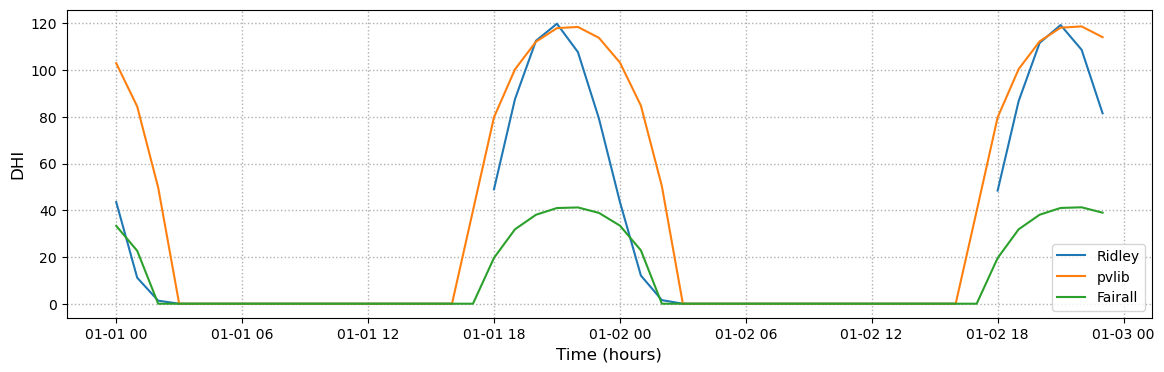

In [20]:
# Example DHI

# pick location near Station ALOHA (158W)
longitude = -158.0
latitude = 22.0

# set arbitrary start date (note 00 for hour doesn't seem to work)
start_date = "Jan 01 2022 01:00AM"
init_time = datetime.datetime.strptime(start_date, '%b %d %Y %I:%M%p')

# specify the tme resolution of the total downward shortwave in seconds
# and length of record in hours (NOTE: in the future we'll read this 
# directly from the input file)
dt = 60 * 60   # 1 hour
ntime = 48         # 2 days

# make a synthetic downward shortwave (Isc)
Isc = [ 740.0 * np.cos(n*2.0*np.pi/24.0+4*np.pi/24.0) for n in range(ntime)]
Isc = [0 if i < 0 else i for i in Isc]

# compute DHI
d = ridley_DHI(ntime,init_time,dt,latitude,longitude,Isc)
dhi1 = d * Isc
#dhi2 = pvlib_DHI('2022-01-01','2022-01-03',latitude,longitude)
cls = [ clear_sky3(i,latitude,longitude,init_time) for i in range(ntime) ]
dhi2 = [ cls[i][2] for i in range(ntime) ]
cls = [ clear_sky4(i,latitude,longitude,init_time,3.0,1010.0,0.07,0.07,0.1) for i in range(ntime) ]
dhi3 = [ cls[i][2] for i in range(ntime) ]
times = pd.date_range('2022-01-01', '2022-01-03', freq='1h')

# make a plot
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(14,4))
ax.plot(times[0:ntime],dhi1, label='Ridley')
ax.plot(times[0:ntime],dhi2, label='pvlib')
ax.plot(times[0:ntime],dhi3, label = 'Fairall')
#ax.set_xlim([0,ntime])
ax.set_xlabel('Time (hours)', fontsize = 12)
ax.set_ylabel('DHI', fontsize = 12)
ax.grid(linestyle=':', linewidth=1)
ax.legend();

plt.savefig('./output/DHI_comp.png',format='png',facecolor='white')

<a id='obs_comp'></a>

# 2. Comparison to short-term observations


In this section we compare the different ways of computing clear sky radiance to actual observations.  The first two examples come from a radiometer on the roof at HIG that measures incoming shortwave (so clouds are already taken into account but not albedo effects).  The data come from https://uhmmeteorology.westernweathergroup.com/ and two three-day samples (with relatively few clouds) were taken during May 15 - 17 2020 and July 24 - 26 2021.  The third example is a attempt to reproduce a plot made by Chris Fairall using NTAS data.  The final example is from a weather station out at Coconut Island at the Hawaii Insitute of Marine Biology (HIMB).

There are several notes here.  First, the Hawaii examples are given in local time (HST) while the NTAS example is in UTC.  Second, the first three examples have time as either a row/index number from zero (HIGP gauges) or floating point "days since" (NTAS).  These need to be converted to datetime.  The last example (HIMB) has time already in datetime format.  Finally, the first two examples were manually obtained from the on-line graph.  The NTAS example is from Chris Fairall, and the HIMB example came from an ERDDAP call (PacIOOS site).

[back to the top](#notebook_top)

In [21]:
def compare_shortterm(example,data,dt,msub1,msub2,initial_time,t_offset,lat,lon):
    
    # This function will compare in-situ observations to clear-sky parameterizations.  The
    #  function will produce two plots, the upper is over some sub-range, e.g., to look at
    #  a single day; the lower plot is the complete time-series.
    # Input
    #  1. example.........string defining the example (e.g., example1 is for HIG)
    #  2. data............dataframe containing the observed data
    #  3. dt..............time increment in hours for obs and cls models (so far this is 1)
    #  4. msub1...........beginning of subset plot time-series
    #  5. msub2...........ending of subset plot time-series
    #  6. initial_time....initial time of obs (and model runs), as string
    #  7. t_offset........off-set from UTC
    #  8. lat.............latitude
    #  9. lon.............longitude
    
    # convert initial time to datetime format
    t_ref = datetime.datetime.strptime(initial_time, '%Y-%m-%d %H:%M:%S')
    # set the range for the upper plot
    sub_time = [t_ref+timedelta(hours=msub1),t_ref+timedelta(hours=msub2)]
    
    if t_offset == 0:
        xlab = 'UTC'
    else:
        xlab = 'Local Time'
        
    if example == 'example4':
        Qs = data['Qs']
        itime = pd.to_datetime(data['time'])
    else:
        Qs = data[1]
        itime = pd.to_datetime((data.index)*3600.0, origin = t_ref, unit='s')

    nmax = len(data)
    cls1 = [ clear_sky1(i,t_ref+timedelta(hours=-t_offset),dt*3600,lat,lon) for i in range(nmax) ]
    cls2 = [ clear_sky2(i,t_ref+timedelta(hours=-t_offset),dt*3600,lat,lon) for i in range(nmax) ]
    cls3 = [ clear_sky3(i,lat,lon,t_ref+timedelta(hours=-t_offset)) for i in range(nmax) ]
    cls4 = [ clear_sky4(i,lat,lon,t_ref+timedelta(hours=-t_offset),3.0,1010.0,0.07,0.07,0.1) for i in range(nmax) ]
    

# combine results into a DataFrame, UTC time as index
    cls_example = pd.DataFrame({'Time': itime, 'Ohlmann': cls1, 
                            'pysolar_ghi': [cls2[i][0] for i in range(nmax)],
                            'pysolar_dni': [cls2[i][1] for i in range(nmax)],
                            'pysolar_dhi': [cls2[i][2] for i in range(nmax)],
                            'pvlib_ghi': [cls3[i][0] for i in range(nmax)], 
                            'pvlib_dni': [cls3[i][1] for i in range(nmax)],
                            'pvlib_dhi': [cls3[i][2] for i in range(nmax)],
                            'Fairall_ghi': [cls4[i][0] for i in range(nmax)],
                            'Fairall_dni': [cls4[i][1] for i in range(nmax)],
                            'Fairall_dhi': [cls4[i][2] for i in range(nmax)] })
    cls_example = cls_example.set_index('Time')

    fig, ax = plt.subplots( figsize=(14, 14), nrows = 2, ncols = 1 )

    for iplot in range(2):
        ax[iplot].plot(itime,cls_example['Ohlmann'],'o-',label='Ohlmann')
        ax[iplot].plot(itime,cls_example['pysolar_ghi'],'s-',label='pysolar')
        ax[iplot].plot(itime,cls_example['pvlib_ghi'],'d-',label='pvlib')
        ax[iplot].plot(itime,cls_example['Fairall_ghi'],'*-',label='Fairall')
        ax[iplot].plot(itime,Qs,'ko-',label='observations')
        ax[iplot].legend()
        ax[iplot].set_ylabel('$Q_{S}^{cls}$ (W/$m^2$)', fontsize = 14)
        ax[iplot].grid(linestyle=':', linewidth=1)
        ax[iplot].tick_params(axis='both', which='major', labelsize=12)
    
    ax[1].set_xlabel(xlab, fontsize = 14)
    ax[0].set_xlim(sub_time[0],sub_time[-1])
    ax[0].set_title(site,fontsize=18)

    # save figure
    if example == 'example1':
        fig_out = 'cls_ideal_may_hig.png'
    if example == 'example2':
        fig_out = 'cls_ideal_jul_hig.png'
    if example == 'example3':
        fig_out = 'cls_ideal_ntas.png'
    if example == 'example4':
        fig_out = 'cls_ideal_himb.png'
    plt.savefig('./output/' + fig_out,facecolor='white',transparent=False)
    
    return

### Example1: HIG rooftop from May 2020

<figure>
   <img src="./images/May15_shortwave_ATMO.png" style="width:100%">
   <figcaption align = "center">Figure 4.  Measured incoming shortwave radiation on the roof of the HIG building on the UH Manoa campus. </figcaption>
</figure>
<br>

| Date | Hour | Qs | Date | Hour | Qs | Date | Hour | Qs |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| May 15 |00|    0| May 16 |00|    0| May 17 |00|    0|        
|   .    |01|    0|   .    |01|    0|   .    |01|    0|        
|   .    |02|    0|   .    |02|    0|   .    |02|    0|          
|   .    |03|    0|   .    |03|    0|   .    |03|    0|       
|   .    |04|    0|   .    |04|    0|   .    |04|    0|         
|   .    |05|    0|   .    |05|    0|   .    |05|    0|      
|   .    |06|    0|   .    |06|    0|   .    |06|    0|           
|   .    |07|   69|   .    |07|   51|   .    |07|   61|      
|   .    |08|  304|   .    |08|  282|   .    |08|  302|    
|   .    |09|  542|   .    |09|  542|   .    |09|  541|   
|   .    |10|  735|   .    |10|  747|   .    |10|  750|    
|   .    |11|  915|   .    |11|  910|   .    |11|  917|    
|   .    |12|  968|   .    |12| 1013|   .    |12| 1018|   
|   .    |13| 1050|   .    |13| 1049|   .    |13| 1052|    
|   .    |14| 1008|   .    |14| 1015|   .    |14| 1017|   
|   .    |15|  900|   .    |15|  912|   .    |15|  912|    
|   .    |16|  707|   .    |16|  713|   .    |16|  716|  
|   .    |17|  530|   .    |17|  540|   .    |17|  541|  
|   .    |18|  304|   .    |18|  310|   .    |18|  317|    
|   .    |19|   92|   .    |19|  100|   .    |19|   84|   
|   .    |20|    0|   .    |20|    0|   .    |20|    0|         
|   .    |21|    0|   .    |21|    0|   .    |21|    0|       
|   .    |22|    0|   .    |22|    0|   .    |22|    0|           
|   .    |23|    0|   .    |23|    0|   .    |23|    0|       

For this example, it is important to note:
* Time reported is local HST that is 10 hours off from UTC
* The lat/lon of the HIG instrument is 21.2980459, -157.8187884

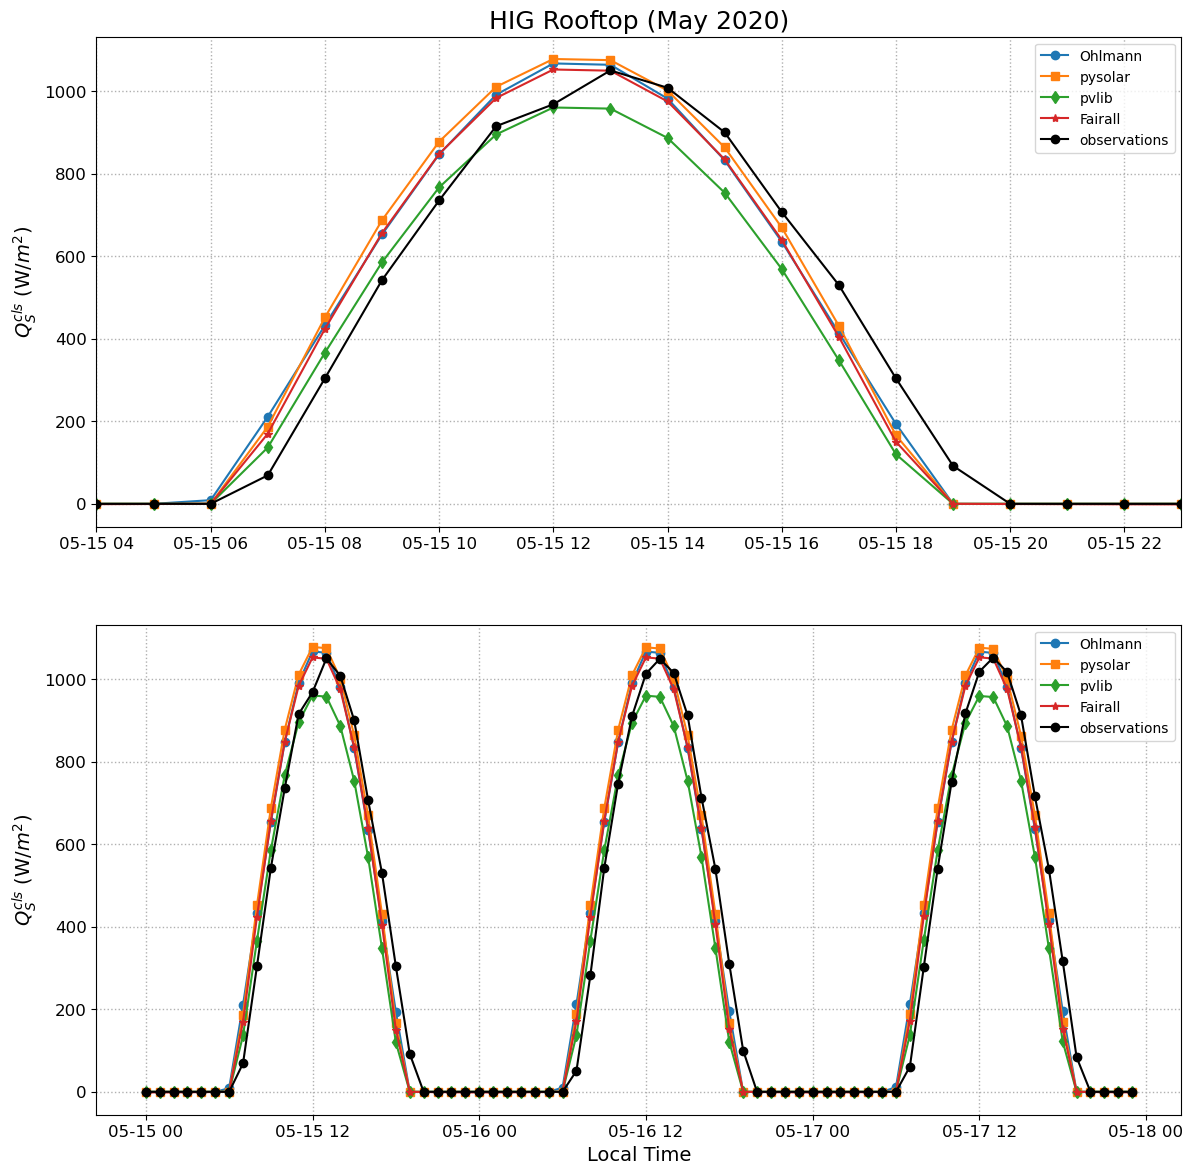

In [22]:
# Example 1: HIG rooftop May 15, 2020

example = 'example1'
lat = 21.2980459
lon = -157.8187884
initial_time = '2020-05-15 00:00:00'
site = 'HIG Rooftop (May 2020)'
data = pd.read_csv('./data/May15_shortwave_ATMO.dat', header=None)
t_offset = -10.0 # these measurements are made in local (HST) time


# set the interval for the calculation (dt, in hours) number of days to plot
dt = 1
msub1 = 4
msub2 = 19 + msub1

compare_shortterm(example,data,dt,msub1,msub2,initial_time,t_offset,lat,lon)

### Example 2: HIG rooftop from July 2021

<figure>
   <img src="./images/July24_shortwave_ATMO.png" style="width:100%">
   <figcaption align = "center">Figure 5.  Measured incoming shortwave radiation on the roof of the HIG building on the UH Manoa campus. </figcaption>
</figure>
<br>

| Date | Hour | Qs | Date | Hour | Qs | Date | Hour | Qs |
|  --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Jul 24 |00|    0| Jul 25 |00|    0| Jul 26 |00|    0|       
|   .    |01|    0|   .    |01|    0|   .    |01|    0|       
|   .    |02|    0|   .    |02|    0|   .    |02|    0|       
|   .    |03|    0|   .    |03|    0|   .    |03|    0|       
|   .    |04|    0|   .    |04|    0|   .    |04|    0|       
|   .    |05|    0|   .    |05|    0|   .    |05|    0|       
|   .    |06|    0|   .    |06|    0|   .    |06|    0|       
|   .    |07|   18|   .    |07|   17|   .    |07|   23|  
|   .    |08|   82|   .    |08|  113|   .    |08|  137|
|   .    |09|  214|   .    |09|  384|   .    |09|  380|
|   .    |10|  455|   .    |10|  531|   .    |10|  662|
|   .    |11|  601|   .    |11|  670|   .    |11|  829|
|   .    |12|  730|   .    |12|  834|   .    |12|  895|
|   .    |13|  929|   .    |13|  990|   .    |13| 1013|
|   .    |14|  962|   .    |14|  982|   .    |14| 1022|
|   .    |15|  886|   .    |15|  886|   .    |15|  876|
|   .    |16|  733|   .    |16|  737|   .    |16|  663|
|   .    |17|  574|   .    |17|  563|   .    |17|  520|
|   .    |18|  262|   .    |18|  290|   .    |18|  271|
|   .    |19|   52|   .    |19|   76|   .    |19|   83|  
|   .    |20|    2|   .    |20|    1|   .    |20|    1|       
|   .    |21|    0|   .    |21|    0|   .    |21|    0|       
|   .    |22|    0|   .    |22|    0|   .    |22|    0|       
|   .    |23|    0|   .    |23|    0|   .    |23|    0|       

For this example, it is important to note:
* Time reported is local HST that is 10 hours off from UTC
* The lat/lon of the HIG instrument is 21.2980459, -157.8187884

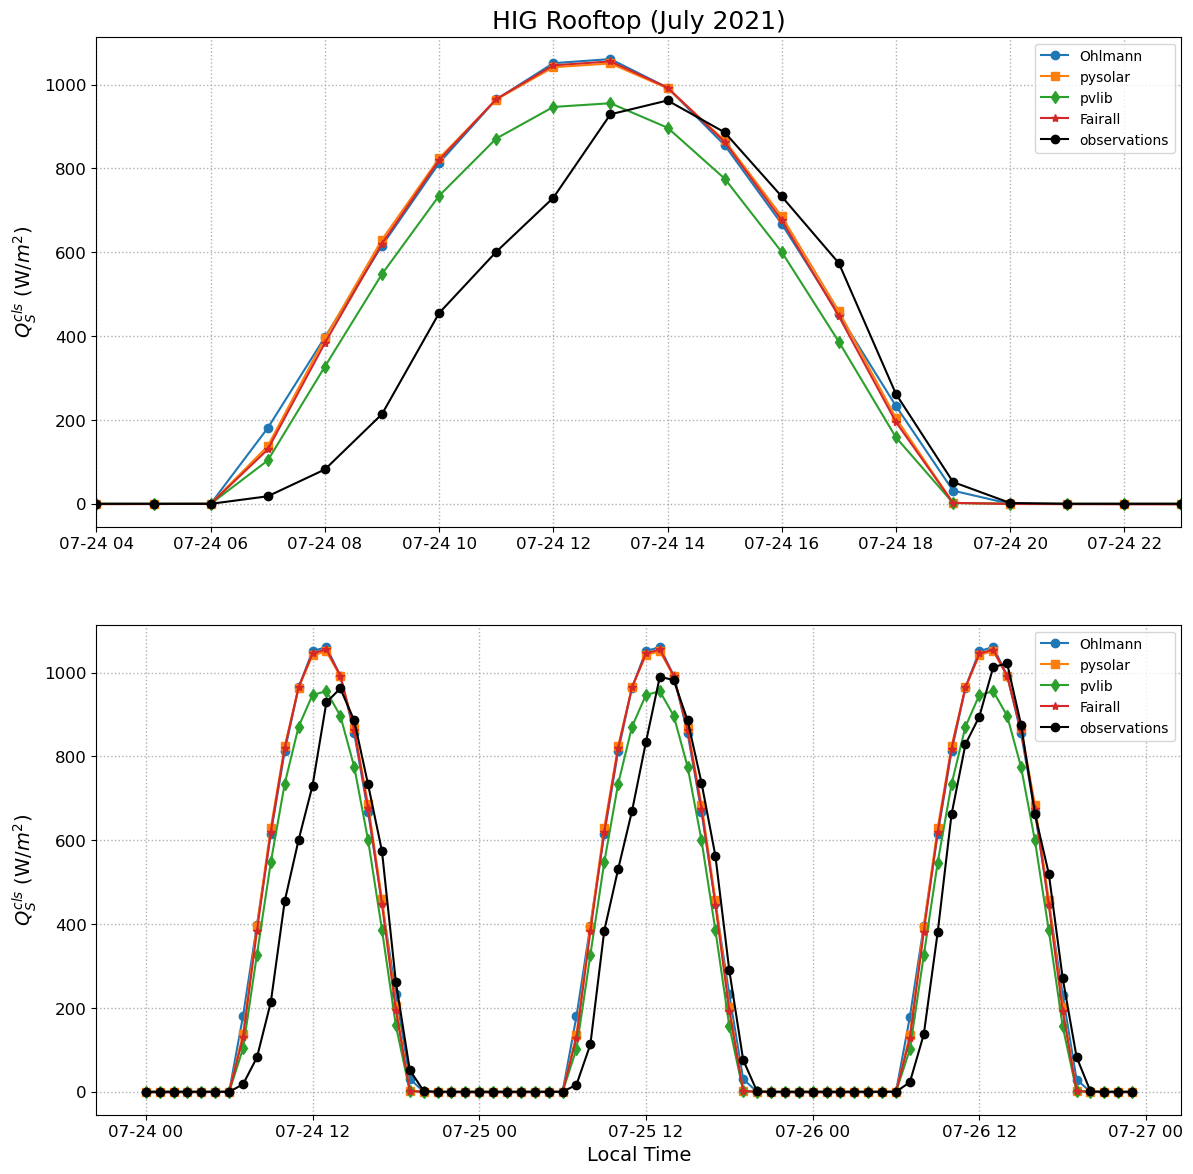

In [23]:
# Example 2: HIG rooftop July 24, 2021

example = 'example2'
lat = 21.2980459
lon = -157.8187884

initial_time = '2021-07-24 00:00:00'
site = 'HIG Rooftop (July 2021)'
data = pd.read_csv('./data/July24_shortwave_ATMO.dat', header=None)
t_offset = -10.0 # these measurements are made in local (HST) time

# set the interval for the calculation (dt, in hours) number of days to plot
dt = 1
msub1 = 4
msub2 = 19 + msub1

compare_shortterm(example,data,dt,msub1,msub2,initial_time,t_offset,lat,lon)

### Example 3: NTAS comparison

Chris Fairall sent a set of matlab code along with examples.  One was a direct comparison of clear-sky irradiance at the NTAS mooring and the buoy observations on a relatively clear day.  This comes from Feb 6, 2020.

<figure>
   <img src="./images/ntas_ATOMIC_solarComparison_clear.jpg" style="width:75%">
   <figcaption align = "center">Figure 6.  Measured incoming shortwave radiation at NTAS. </figcaption>
</figure>
<br>

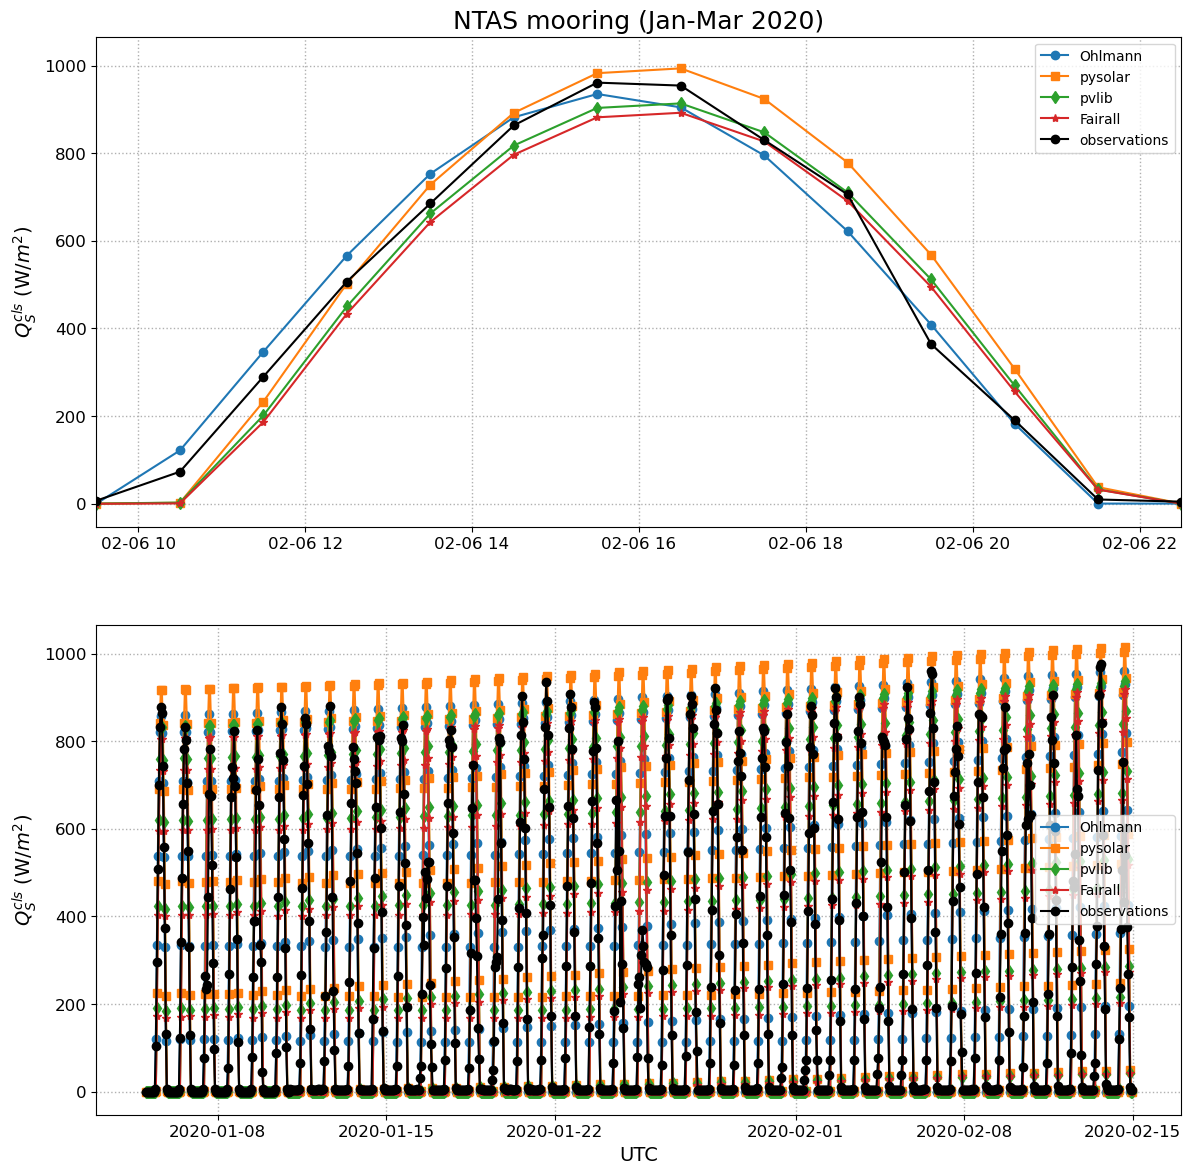

In [24]:
# Example 3: NTAS obs from 2020

example = 'example3'
lat = 14.7837
lon = -50.9808
initial_time = '2020-01-05 00:30:00'
site = 'NTAS mooring (Jan-Mar 2020)'
data = pd.read_csv('./data/NTAS_sample_sw.dat', header=None)
t_offset = 0.0 # these measurements are made in UTC


# set the interval for the calculation (dt, in hours) number of days to plot
dt = 1
msub1 = 32 * 24 + 9
msub2 = 13 + msub1

compare_shortterm(example,data,dt,msub1,msub2,initial_time,t_offset,lat,lon)

### Example 4: Kaneohe Bay weather station

The data come from an automatic weather station (AWS-HIMB) located on the southeastern edge of Moku o Loʻe (Coconut Island) in Kāneʻohe Bay on the windward (eastern) coast of Oʻahu in the State of Hawaiʻi. Instruments are mounted on the roof of the HIMB Coral Reef Ecology Laboratory (Point Lab) at approximately 5 m (16 ft) elevation above sea level. Sensors include an Eppley 295-385 nm ultraviolet (UV) radiometer, a LiCor 200SZ Pyranometer, and a LiCor Quantameter (400-700 nm).  Data are transmitted hourly and were downloaded from the PacIOOS web site (http://www.pacioos.hawaii.edu/weather/obs-mokuoloe/).

<figure>
   <img src="./images/aws_kbay.png" style="width:75%">
   <figcaption align = "center">Figure 7.  Measured incoming shortwave radiation at Coconut Island (HIMB) on the windward side of Oahu. </figcaption>
</figure>
<br>


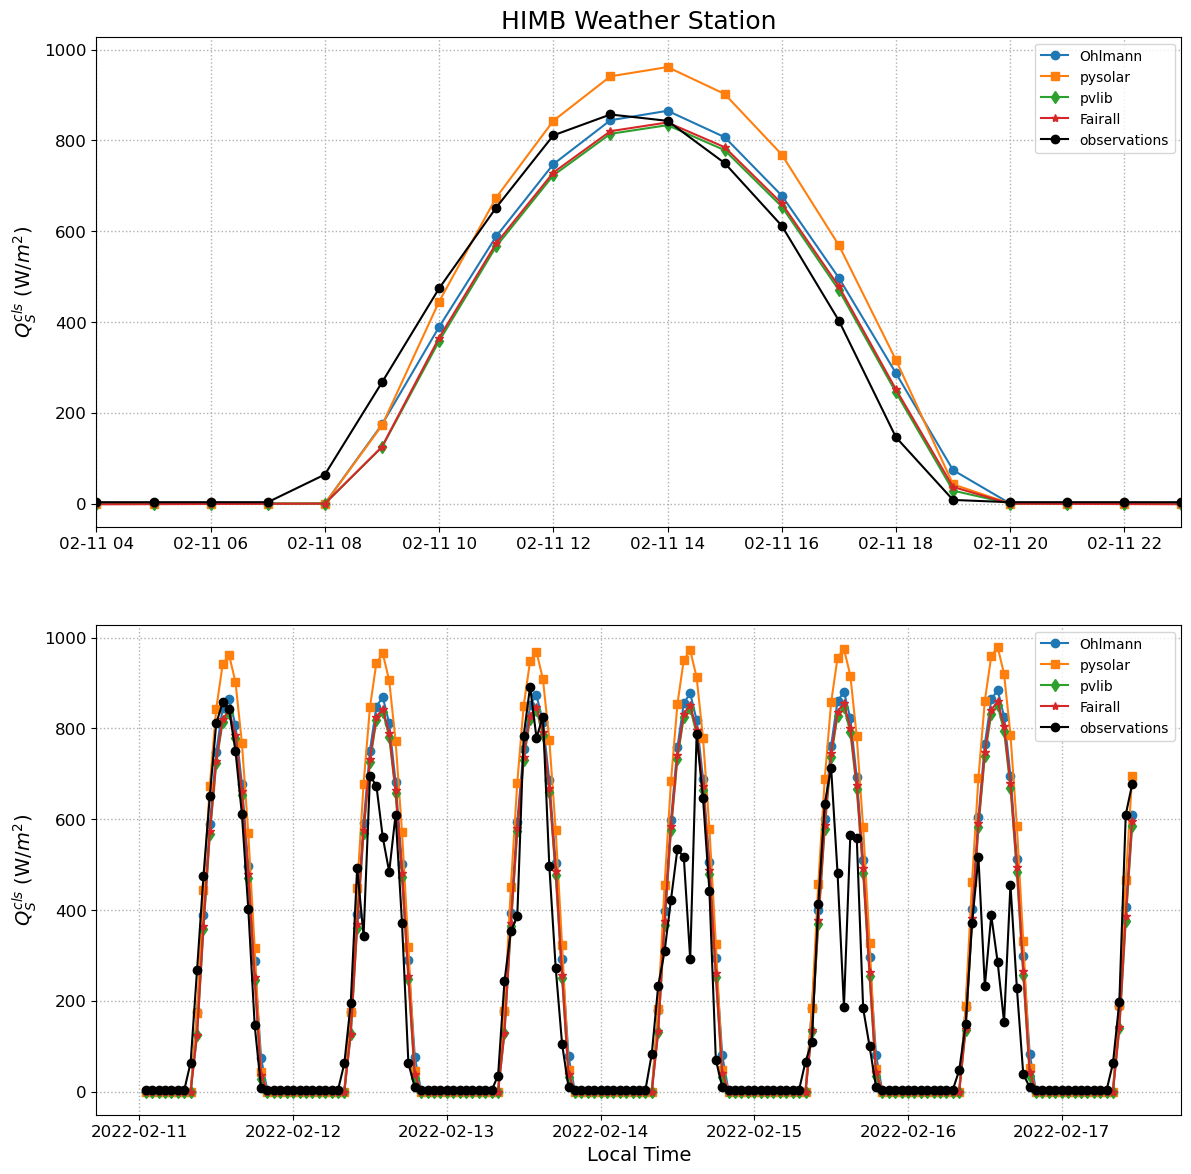

In [25]:
# Example 4: HIMB weather station February 16, 202

example = 'example4'
lat = 21.4330
lon = -157.7863

initial_time = '2022-02-11 00:00:00'
site = 'HIMB Weather Station'
column_names = ['time','Tair','Tsst','wspd','wmax','wdir','wdev','rain','par','Qs','UV']
data = pd.read_csv('./data/PacIOOS_AWS-HIMB_202202101121_202202171121.csv',header=1,names=column_names)
t_offset = -10.0 # these measurements are made in local (HST) time

# set the interval for the calculation (dt, in hours) number of days to plot
dt = 1
msub1 = 4
msub2 = 19 + msub1

compare_shortterm(example,data,dt,msub1,msub2,initial_time,t_offset,lat,lon)

Interesting notes:
* idealized calculations seem to lead the observations by an hour
 * the three idealized calculations suggest sunrise an hour before the observations (at 06:00 instead of 07:00)
 * hard to tell, but looks like peak $Q_{S}$ is also earlier in the idealized cases (12:00 instead of 13:00)
 * finally, the idealized curves show sunset an hour prior to obs (19:00 instead of 20:00)
* the pvlib peak is a little small; the clear sky should always exceed the measured (since obs may have clouds)
* pysolar gives a more broad curve (ala negative kertosis)

[back to the top](#notebook_top)

<a id='albedo'></a>

# 3. Albedo

As mentioned above, the albedo is a measure of the reflectivity of a surface.  Dark objects typically have a lower albedo (absorb more shortwave radiation) than reflective surfaces.  For example, ice (reflective) might have an albedo of 70-90%, while asphalt (dark) would have an albedo of less than 5%.  In many applications, the ocean is assumed to have a constant albedo of 0.05, or 5% of the incoming shortwave is absorbed while the other 95% is reflected back.  Of course this is a simplification, and it is readily observed that the ocean surface is highly variable with waves, whitecaps, ocean biology, _etc._ all contributing.  

Without direct measurements, the ocean surface albedo can be parameterized in a few different ways (in addition to simply assuming a constant).  Jin _et al._ (2011) describe one such method.  They calculate albedo in two parts, $\alpha_{dir}$ for the direct normal irradiance ($DNI$) and separately $\alpha_{dif}$ for the diffuse horizontal irradiance ($DHI$).  These are then applied separately as

\begin{eqnarray}
\alpha = \alpha_{dir} \: DNI \: + \: \alpha_{dif} \: DHI \: + \: 0.006
\end{eqnarray}

In order to do this, the separate components $DNI$ and $DHI$ need to be determined.  This can be done from the downward shortwave radiation ($Q_{S}^{Down}$), either as observed ($Q_{S}^{Obs}$) or computed from clearsky ($Q_{S}^{Clear} - Q_{S}^{Cloud}$).  The impact of whitecaps can be incorporated using Scanlon and Ward (2016) for high latitudes ($lat >= 40$), and Holthuijsen (2012) for the tropics with the use of a scaling factor $W_c$:

\begin{eqnarray}
\alpha = W_c \: a_{wc} \: + ( 1-W_c) \: \alpha
\end{eqnarray}

Here $a_{wc}$ is a constant for seafoam reflectance (taken to be 0.55).  The whitecap scaling factor, $W_c$, is then estimated for latitudes polward of $40^{\circ}$ via

\begin{equation}
  W_c = \begin{cases}
    0 & \text{if $w_{spd} < 2.56 m\: s^{-1}$}\\
    0.01 \left[ 7.84x10^{-4} (w_{spd}-2.56)^3 \right] & \text{if $w_{spd} >= 2.56$ and $<= 20.9273 m\: s^{-1}$}\\
    \left\{ 0.1 - 0.04261 \: tanh \left[ 0.5 \left( w_{spd}-26.5 \right) \right] \right\} tanh \left[ \frac{7.84 x 10^{-4} \left(w_{spd}-2.56\right)^3}{12.45} \right] & \text{if $w_{spd} > 20.9273$ and $<= 25.2 m\: s^{-1}$}\\
    0.04 & \text{if $w_{spd} > 25.2 m\: s^{-1}$}
    \end{cases}
\end{equation}

and in the tropics as

\begin{equation}
  W_c = \begin{cases}
    4x10^{-6} \: w_{spd}^{3.12} & \text{if $w_{spd} < 23.145 m\: s^{-1}$}\\
    \left\{ 10.0 - 6.4338 \: tanh \left[ 0.5 \left( w_{spd}-26.5 \right) \right] \right\} tanh \left( \frac{4.0 x 10^{-6} w_{spd}^{3.12}}{16.0} \right) & \text{if $w_{spd} >= 23.145$ and $<= 29.85 m\: s^{-1}$}\\
    0.04 & \text{if $w_{spd} > 29.85 m\: s^{-1}$}
    \end{cases}
\end{equation}

Wind speed can either be obtained directly or from the wind stress components ($\tau_x, \tau_y$) as done in __PWP_albedo.m__:

\begin{eqnarray}
w_{spd} = \left( \frac{\sqrt{\tau_x^2 + \tau_y^2} }{ \rho_{air} C_D } \right)^{-2}
\end{eqnarray}

[back to the top](#notebook_top)

In [26]:
def whitecap(lat,wspd):
    
    # Use Scanlon and Ward (2016) for high latitudes (lat>=40), and Holthuijsen (2012)
    # for the tropics and subtropics, and for wind > 22 m/s
    
    if (np.abs(lat) >= 40):
        Wc = np.empty([len(wspd)])
        l = np.argwhere(wspd < 2.56)
        if l.size > 0:
            Wc[l] = 0
        l = np.argwhere((wspd>=2.56) & (wspd<=20.9273))
        if l.size > 0:  
            Wc[l] = 7.84e-4 * (wspd[l]-2.56)**3  # Scanlon and Ward (2016) (in %)
            Wc[l] = Wc[l]/100
        l = np.argwhere((wspd>20.9273) & (wspd<=25.2))  # transition between S&W (2016) and Holthuijsen (2012)
        if l.size > 0:  
            f = 0.5 
            g = 12.45
            Uref = 26.5
            b = 3
            a = 7.84e-4
            d = 0.1 
            e = 0.04261
            Uref = 22.75
            c = d - e*np.tanh(f*(wspd[l] - Uref))
            Wc[l] = c*np.tanh((a*(wspd[l]-2.56)**b)/g)    # fractional
        l = np.argwhere(wspd>25.2)
        if l.size > 0:
            Wc[l] = 0.04 # Holthuijsen (2012) for high wind speed
    else:
        Wc = 4e-6 * wspd**3.12  # Holthuijsen (2012)
        l = np.argwhere((wspd>=23.145) & (wspd<=29.85))   # transition low and high wind speed
        if l.size > 0:  
            d = 10 
            e = 6.4338
            f = 0.5
            g = 16
            Uref = 26.5
            b = 3.12
            a = 4e-6
            c = d - e*np.tanh(f*(wspd[l] - Uref))
            Wc[l] = c*np.tanh((a*wspd[l]**b)/g)    
        l = np.argwhere(wspd>29.85)
        if l.size > 0:
            Wc[l] = 0.04 # Holthuijsen (2012) for high wind speed
    return Wc

In [27]:
def compute_albedo1(lat,lon,ntimes,init_time,deltat,**kwargs):
    
    wind_comps, wind_speed, wind_stress, Ii = False, False, False, False
    if 'u' in kwargs:
        u = kwargs.get('u')
        v = kwargs.get('v')
        ws2 = [u[i]**2 + v[i]**2 for i in range(len(u))]
        wspd = np.sqrt(ws2)
    elif 'wspd' in kwargs:
        wspd = kwargs.get('wspd')
    elif 'tx' in kwargs:
        tx = kwargs.get('tx')
        ty = kwargs.get('ty')
        Tau2 = [i ** 2 for i in tx] + [i ** 2 for i in ty]
        Tau = np.sqrt(Tau2)
        wspd = np.sqrt(Tau/1.8e-3)
    if 'Ii' in kwargs:
        # need to compute DNI and DHI
        Ii = kwargs.get('Ii')
        f_dif = ridley_DHI(len(Ii),init_time,deltat,lat,lon,Ii)
        f_dir = 1.0 - f_dif
    else:
        # have DNI and DHI, need total
        Idn, Idif = kwargs.get('Idn'), kwargs.get('Idif')
        Ii = Idn * np.sin(alt) + Idif
        f_dif = Idif/Ii
        f_dir = 1.0 - f_dif
        
    # Include eccentricity
    Eo = eccentricity(ntimes,init_time,deltat,lon)
        
    # Get Direct and Diffuse Surface Albedo from Jin et al. (2011)
    
    zh = []
    for i in range(ntimes):
        # Calculate Zenith angle
        c1, c2, c3 = sza(i,init_time,deltat,lat,lon)
        zh = np.append(zh,c1)
    
    mu = np.cos(zh)
    sig = np.sqrt(0.003 + 0.00512*wspd) # surface roughness (using Cox-Munk model)
    f = (0.0152 - 1.7873*mu + 6.8972*mu**2 - 8.5778*mu**3 + 4.071*sig - 7.6446*mu*sig) \
       * np.exp(0.1643 - 7.8409*mu - 3.5639*mu**2 - 2.3588*sig + 10.0538*mu*sig)
    
    # Use Jin et al (2011) expression for broadband, n = n0 = 1.34
    
    n = 1.34  # relative refractive index (ri of seawater divided by ri of air)
    # Fresnel angular reflectance
    #   perpendicular polarization
    rs = ((np.cos(zh) - np.sqrt(n**2 - np.sin(zh)**2))/(np.cos(zh) + np.sqrt(n**2 - np.sin(zh)**2)))**2
    #   parallel polarization
    rp = ((n**2*np.cos(zh) - np.sqrt(n**2 - np.sin(zh)**2))/(n**2*np.cos(zh) + np.sqrt(n**2 - np.sin(zh)**2)))**2
    
    a_dir_s = (rs + rp)/2.0 - f  # Surface Direct Albedo 
    
    l = np.argwhere(zh >= 90.0*np.pi/180)
    if l.size > 0:
        a_dir_s[l] = 0
    
    # Now Surface diffuse
    
    a_clr = -0.1482 - 0.012*sig + 0.1608*n - 0.0244*n*sig # under clear sky
    a_cdy = -0.1479 + 0.1502*n - 0.0176*n*sig # under cloudy skies
    
    # Calculate Cloud Index
    # from Ohlmann and Siegel, 2000, JPO, p. 1851
    # Get surface irradiance under clear sky 
    # (from Lumb, 1964, see Soloviev and Lukas, 2014. The Near-Surface 
    #  Layer of the Ocean, p. 22)
    aL = 0.61
    bL = 0.2
    ma = aL + bL*np.cos(zh)
    Iclr = ma*Isc*Eo*np.cos(zh)
    ci = np.ones(len(Iclr))
    l = np.argwhere(Iclr!=0)
    ci[l] = 1 - Ii[l]/Iclr[l]
    
    #l = np.argwhere((Iclr-Ii < 25 ) & ( zh*180/np.pi ) > 85)
    l = np.argwhere(Iclr-Ii < 25)
    if l.size > 0:
        ci[l] = np.nan # remove bad points too close to sunrise/sunset
    
    # Determine "clear-sky" as ci <= 0.1 as in Ohlmann and Siegel (2000)
    # "cloudy-sky" for all other
    a_dif_s = a_cdy
    l = np.argwhere(ci<=0.1)
    if l.size > 0:
        a_dif_s[l] = a_clr[l]
    
    # Determine "clear-sky" as ci <= 0.1 as in Ohlmann and Siegel (2000)
    # and "cloudy-sky" for ci >= 0.4. Use blended coeffs (generated 
    # with the Q function) for ci in between
    
    G = np.zeros(ci.size)
    l = np.argwhere(ci<=0.1)
    if l.size > 0:
        G[l] = 1
    l = np.argwhere((ci>0.1) & (ci<0.4))
    if l.size > 0:
        ff = (ci[l]-0.25)/0.0375
        G[l] = 0.5 - 0.5*special.erf(ff/np.sqrt(2))
    a_dif_s = G*a_clr + (1-G)*a_cdy
     
    # Now get albedo
    alb = f_dir*a_dir_s + f_dif*a_dif_s + 0.006
    
    # Now add Foam adjustment (whitecaps correction)
    # Apply correction assuming constant foam reflectance
    
    Wc = whitecap(lat,wspd)
    a_wc = 0.55
    alb = Wc*a_wc + (1-Wc)*alb  # Albedo with whitecaps correction
    alb[np.isnan(alb)] = 0.0
    
    return alb

In [28]:
def compute_albedo2(lat,lon,ntimes,init_time,deltat,Qs_in):
    # This function computes albedo based on Payne (1972)
    # 
    # It takes as input:
    #  1. lat............latitude in degrees (negative for SH)
    #  2. lon............longitude in degrees (negative for WH)
    #  3. ntimes.........number of points to compute DHI over
    #  4. init_time......the starting time (in datetime format)
    #  4. deltat.........time interval
    #  6. QS_in..........time-varying downward shortwave
    # and provides as output:
    #  1. albedo.........albedo
    
    alb = []
    # Look up table from Payne (1972)  Only adjustment is to T=0.95 Alt=10 value
    a = [ [0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061],
          [0.062, 0.062, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061,
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061,
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061,
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.061,
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061],
          [0.072, 0.070, 0.068, 0.065, 0.065, 0.063, 0.062, 0.061, 0.061, 0.061,
           0.061, 0.061, 0.061, 0.061, 0.061, 0.061, 0.060, 0.061, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060],
          [0.087, 0.083, 0.079, 0.073, 0.070, 0.068, 0.066, 0.065, 0.064, 0.063,
           0.062, 0.061, 0.061, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060],
          [0.115, 0.108, 0.098, 0.086, 0.082, 0.077, 0.072, 0.071, 0.067, 0.067,
           0.065, 0.063, 0.062, 0.061, 0.061, 0.060, 0.060, 0.060, 0.060, 0.061,
           0.061, 0.061, 0.061, 0.060, 0.059, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.059, 0.059, 0.059],
          [0.163, 0.145, 0.130, 0.110, 0.101, 0.092, 0.084, 0.079, 0.072, 0.072,
           0.068, 0.067, 0.064, 0.063, 0.062, 0.061, 0.061, 0.061, 0.060, 0.060,
           0.060, 0.060, 0.060, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059,
           0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059,
           0.059, 0.059, 0.059, 0.059, 0.059, 0.058],
          [0.235, 0.198, 0.174, 0.150, 0.131, 0.114, 0.103, 0.094, 0.083, 0.080,
           0.074, 0.074, 0.070, 0.067, 0.065, 0.064, 0.063, 0.062, 0.061, 0.060,
           0.060, 0.060, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059,
           0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059,
           0.059, 0.059, 0.059, 0.058, 0.058, 0.058],
          [0.318, 0.263, 0.228, 0.192, 0.168, 0.143, 0.127, 0.113, 0.099, 0.092,
           0.084, 0.082, 0.076, 0.072, 0.070, 0.067, 0.065, 0.064, 0.062, 0.062,
           0.060, 0.060, 0.060, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059,
           0.058, 0.058, 0.058, 0.058, 0.058, 0.058, 0.058, 0.058, 0.057, 0.058,
           0.058, 0.058, 0.058, 0.057, 0.057, 0.057],
          [0.395, 0.336, 0.290, 0.248, 0.208, 0.176, 0.151, 0.134, 0.117, 0.107,
           0.097, 0.091, 0.085, 0.079, 0.075, 0.071, 0.068, 0.067, 0.065, 0.063,
           0.062, 0.061, 0.060, 0.060, 0.060, 0.059, 0.059, 0.058, 0.058, 0.058,
           0.057, 0.057, 0.057, 0.057, 0.057, 0.057, 0.057, 0.056, 0.056, 0.056,
           0.056, 0.056, 0.056, 0.056, 0.056, 0.055],
          [0.472, 0.415, 0.357, 0.306, 0.252, 0.210, 0.176, 0.154, 0.135, 0.125,
           0.111, 0.102, 0.094, 0.086, 0.081, 0.076, 0.072, 0.071, 0.068, 0.066,
           0.065, 0.063, 0.062, 0.061, 0.060, 0.059, 0.058, 0.057, 0.057, 0.057,
           0.056, 0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0.054, 0.053, 0.054,
           0.053, 0.053, 0.054, 0.054, 0.053, 0.053],
          [0.542, 0.487, 0.424, 0.360, 0.295, 0.242, 0.198, 0.173, 0.150, 0.136,
           0.121, 0.110, 0.101, 0.093, 0.086, 0.081, 0.076, 0.073, 0.069, 0.067,
           0.065, 0.064, 0.062, 0.060, 0.059, 0.058, 0.057, 0.056, 0.055, 0.055,
           0.054, 0.053, 0.053, 0.052, 0.052, 0.052, 0.051, 0.051, 0.050, 0.050,
           0.050, 0.050, 0.051, 0.050, 0.050, 0.050],
          [0.604, 0.547, 0.498, 0.407, 0.331, 0.272, 0.219, 0.185, 0.160, 0.141,
           0.127, 0.116, 0.105, 0.097, 0.089, 0.083, 0.077, 0.074, 0.069, 0.066,
           0.063, 0.061, 0.059, 0.057, 0.056, 0.055, 0.054, 0.053, 0.053, 0.052,
           0.051, 0.050, 0.050, 0.049, 0.049, 0.049, 0.048, 0.047, 0.047, 0.047,
           0.046, 0.046, 0.047, 0.047, 0.046, 0.046],
          [0.655, 0.595, 0.556, 0.444, 0.358, 0.288, 0.236, 0.190, 0.164, 0.145,
           0.130, 0.119, 0.107, 0.098, 0.090, 0.084, 0.076, 0.073, 0.068, 0.064,
           0.060, 0.058, 0.056, 0.054, 0.053, 0.051, 0.050, 0.049, 0.048, 0.048,
           0.047, 0.046, 0.046, 0.045, 0.045, 0.045, 0.044, 0.043, 0.043, 0.043,
           0.042, 0.042, 0.043, 0.042, 0.042, 0.042],
          [0.693, 0.631, 0.588, 0.469, 0.375, 0.296, 0.245, 0.193, 0.165, 0.145,
           0.131, 0.118, 0.106, 0.097, 0.088, 0.081, 0.074, 0.069, 0.065, 0.061,
           0.057, 0.055, 0.052, 0.050, 0.049, 0.047, 0.046, 0.046, 0.044, 0.044,
           0.043, 0.042, 0.042, 0.041, 0.041, 0.040, 0.040, 0.039, 0.039, 0.039,
           0.038, 0.038, 0.038, 0.038, 0.038, 0.038], 
          [0.719, 0.656, 0.603, 0.480, 0.385, 0.300, 0.250, 0.193, 0.164, 0.145,
           0.131, 0.116, 0.103, 0.092, 0.084, 0.076, 0.071, 0.065, 0.061, 0.057,
           0.054, 0.051, 0.049, 0.047, 0.045, 0.043, 0.043, 0.042, 0.041, 0.040,
           0.039, 0.039, 0.038, 0.038, 0.037, 0.036, 0.036, 0.035, 0.035, 0.034,
           0.034, 0.034, 0.034, 0.034, 0.034, 0.034],
          [0.732, 0.670, 0.592, 0.474, 0.377, 0.291, 0.246, 0.190, 0.162, 0.144,
           0.130, 0.114, 0.100, 0.088, 0.080, 0.072, 0.067, 0.062, 0.058, 0.054,
           0.050, 0.047, 0.045, 0.043, 0.041, 0.039, 0.039, 0.038, 0.037, 0.036,
           0.036, 0.035, 0.035, 0.034, 0.033, 0.032, 0.032, 0.032, 0.031, 0.031,
           0.031, 0.030, 0.030, 0.030, 0.030, 0.030],
          [0.730, 0.652, 0.556, 0.444, 0.356, 0.273, 0.235, 0.188, 0.160, 0.143,
           0.129, 0.113, 0.097, 0.086, 0.077, 0.069, 0.064, 0.060, 0.055, 0.051,
           0.047, 0.044, 0.042, 0.039, 0.037, 0.035, 0.035, 0.035, 0.034, 0.033,
           0.033, 0.032, 0.032, 0.032, 0.029, 0.029, 0.029, 0.029, 0.028, 0.028,
           0.028, 0.028, 0.027, 0.027, 0.028, 0.028], 
          [0.681, 0.602, 0.488, 0.386, 0.320, 0.252, 0.222, 0.185, 0.159, 0.142,
           0.127, 0.111, 0.096, 0.084, 0.075, 0.067, 0.062, 0.058, 0.054, 0.050,
           0.046, 0.042, 0.040, 0.036, 0.035, 0.033, 0.032, 0.032, 0.031, 0.030,
           0.030, 0.030, 0.030, 0.029, 0.027, 0.027, 0.027, 0.027, 0.026, 0.026,
           0.026, 0.026, 0.026, 0.026, 0.026, 0.026],
          [0.581, 0.494, 0.393, 0.333, 0.288, 0.237, 0.211, 0.182, 0.158, 0.141,
           0.126, 0.110, 0.095, 0.083, 0.074, 0.066, 0.061, 0.057, 0.053, 0.049,
           0.045, 0.041, 0.039, 0.034, 0.033, 0.032, 0.031, 0.030, 0.029, 0.028,
           0.028, 0.028, 0.028, 0.027, 0.026, 0.026, 0.026, 0.025, 0.025, 0.025,
           0.025, 0.025, 0.025, 0.025, 0.025, 0.025], 
          [0.453, 0.398, 0.342, 0.301, 0.266, 0.226, 0.205, 0.180, 0.157, 0.140,
           0.125, 0.109, 0.095, 0.083, 0.074, 0.065, 0.061, 0.057, 0.052, 0.048,
           0.044, 0.040, 0.038, 0.033, 0.032, 0.031, 0.030, 0.029, 0.028, 0.027,
           0.027, 0.026, 0.026, 0.026, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
           0.025, 0.025, 0.025, 0.025, 0.025, 0.025], 
          [0.425, 0.370, 0.325, 0.290, 0.255, 0.220, 0.200, 0.178, 0.157, 0.140,
           0.122, 0.108, 0.095, 0.083, 0.074, 0.065, 0.061, 0.056, 0.052, 0.048,
           0.044, 0.040, 0.038, 0.033, 0.032, 0.031, 0.030, 0.029, 0.028, 0.027,
           0.026, 0.026, 0.026, 0.026, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
           0.025, 0.025, 0.025, 0.025, 0.025, 0.025] ] 

    for i in range(ntimes):
        # Calculate Zenith angle
        zh, AST, AST_day = sza(i,init_time,deltat,lat,lon)
    
        # calculate Eccentricity correction of the earth's orbit
        # (From Iqubal, 1983, Solar Radiation book)
        
        TZ = lon * 24.0 / 360.0
        time_offset = datetime.timedelta(hours=TZ,seconds=i*deltat)
        mtime = init_time + time_offset
        yr = mtime.year
        mo = mtime.month
        dy = mtime.day
        hr = mtime.hour
        mn = mtime.minute
        sc = mtime.second
        
        doy = mtime.timetuple().tm_yday  # day of year
        if doy < 1.0:
            doy = doy + 365.0
        dn = np.floor(doy)
        
        da = 2*np.pi*(dn-1)/365  # day angle (radians)
        Eo = 1.00011 + 0.034221*np.cos(da) + 0.00128*np.sin(da) + 0.000719*np.cos(2*da) + 0.000077*np.sin(2*da)
        
        psi = np.arcsin(np.cos(zh)) * 180.0 / np.pi
        solarmax = Io * np.cos(zh) / Eo
    
        T = min(1,Qs_in[i]/solarmax)
        Ts = np.arange(0.0, 1.05, 0.05).tolist()
        Tchk = [abs(x - T) for x in Ts]
        i = Tchk.index(min(Tchk))
        As = np.arange(0.0,92.0,2.0)
    
        if psi < 0:
            alb = np.append(alb,0.0)
        else:
            Achk = [abs(x-psi) for x in As]
            j = Achk.index(min(Achk))
            alb = np.append(alb,a[i][j])
    
    return alb

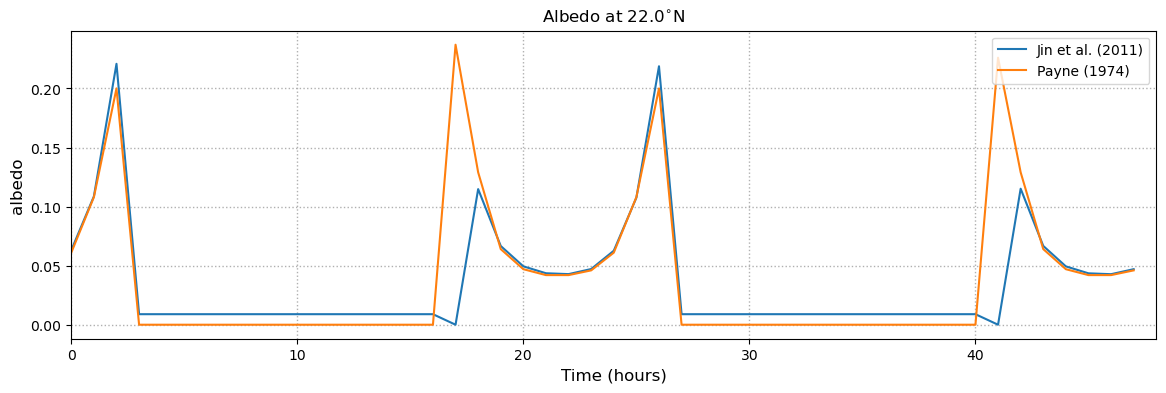

In [29]:
# Example albedo

# pick location near Station ALOHA (158W)
longitude = -158.0
latitude = 22.0

# set arbitrary start date (note 00 for hour doesn't seem to work)
start_date = "Jan 01 2022 01:00AM"
init_time = datetime.datetime.strptime(start_date, '%b %d %Y %I:%M%p')

# specify the tme resolution of the total downward shortwave in seconds
# and length of record in hours (NOTE: in the future we'll read this 
# directly from the input file)
dt = 60.0 * 60.0   # 1 hour
ntime = 48         # 2 days

# make a synthetic downward shortwave (Isc)
Isc = [ 750.0 * np.cos(n*2.0*np.pi/24.0+4*np.pi/24.0) for n in range(ntime)]
Isc = np.array([0 if i < 0 else i for i in Isc])

# make synthetic wind speed
uvel = [10.0 for x in range(ntime)]
vvel = [1.0 for x in range(ntime)]

albedo1 = compute_albedo1(latitude,longitude,ntime,init_time,dt,u=uvel,v=vvel,Ii=Isc)
albedo2 = compute_albedo2(latitude,longitude,ntime,init_time,dt,Isc)

# make a plot
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(14,4))
ax.set_title('Albedo at ' + str(latitude) + '$^{\circ}$N')
ax.plot(albedo1, label = 'Jin et al. (2011)')
ax.plot(albedo2, label = 'Payne (1974)')
ax.set_xlim([0,ntime])
ax.set_xlabel('Time (hours)', fontsize = 12)
ax.set_ylabel('albedo', fontsize = 12)
ax.grid(linestyle=':', linewidth=1)
ax.legend()

plt.savefig('./output/albebo_ideal.png',format='png',facecolor='white')

## 3.1 Comparison to FLIP data
We received an email from Chris Fairall on December 15, 2022 that contained some measurements made from FLIP.  These were done in 1995 about 5 miles off Tillamok Ore (45.8 N 124 W).  There were two pairs of PIR/PSP deployed well out on one of FLIP's booms.  At the beginning and end of the experiment, both pairs were pointed up, so they should read the same (after some minor adjustments).  At 260.8 (Sept 17) one set was then pointed down at the ocean.  At approximately 270.8 (Sept 27) the downlooking set was pointed up again.

Chris forwarded two data sets, _cope_flip_me4.TXT_ and _cop_FLIP_ME3_nohd.txt_.  The first file (set to __in_file1__ in the code below) is ASCII, space delimited, but it includes two header lines (variable name and units).  It also does not have a constant number of entries in each row (I think some rows are missing heading and/or Julian day/date).  Reading this dataset takes a little more wrangling.

The second file (set to __in_file2__ in the code below) appears to be a regular, space delimited file with no column headers.  The table below (from the readme) states what these are.  I think it's probably easier to use this one.

Chris sent a readme file with the following:

#### COPE Bulkmet Data File

The bulkmet.txt file contains 10-min averaged data from the COPE experiment.  Data from two sources have been combined: the various mean-meteorological sensors recorded by Campbell datalogger and a sonic anemometer at 17-m above the sea recorded by a PC.  A -9999 implies no data for that time.  Also note that the downward facing radiometers radiometers, which measured the upward component of radiation, were operated upfacing at the beginning and end of the experiment to cross calibrate with the regular upfacing instruments.

| Col | Variable           | Units  | Description                               |
|:----|:-------------------|:------:|------------------------------------------:|
|  0 | Julian Day          | UTC    | 1995                                      |
|  1 | Sun elevation angle | rad    | Crude approximation for my usage          |
|  2 | Tair                | Cent.  | Vaisala HMP-35 on pboom, z=12 m           |
|  3 | RH                  | %      | Vaisala HMP-35 on pboom, z=12 m           |
|  4 | Tsea                | Cent.  | Floating YSI thermistor                   |
|  5 | IR flux_up          | W/m2   | Eppley pyrgeometer, down facing           |
|  6 | IR flux_down        | W/m2   | Eppley pyrgeometer, up facing             |
|  7 | Sol flux_up         | W/m2   | Eppley pyranometer, down facing           |
|  8 | Sol flux_down       | W/m2   | Eppley pyranometer, up facing             |
|  9 | Tsea IR             | Cent.  | Computed from IR flux, emissivity=0.97    |
| 10 | q_sst               | g/kg   | Specific humidity from Tsea               |
| 11 | q_air               | g/kg   | Specific humidity from Tair and RH        |
| 12 | Wind speed          | m/s    | Vector averaged wind from sonic anemom.   |
| 13 | Wind direction(true)| deg    | Met convention, assumes flip pointed 300  |
| 14 | Tair, sonic         | Cent   | Computed from sonic T and q_air           |
| 15 | Tsonic              | Cent   | Measured from sound speed, 1.7 C offset   |
| 16 | U_variance          | (m/s)2 | Variance wind streamwise component        |
| 17 | V_variance          | (m/s)2 | Variance wind cross stream component      |
| 18 | W_variance          | (m/s)  | Variance wind vertical component          |
| 19 | T_variance          | C2     | Variance sonic temperature                |
| 20 | wu                  | (m/s)2 | Streamwise stress component               |
| 21 | wv                  | (m/s)2 | Cross stream stress component             |
| 22 | wT                  | Cm/s   | Vertical wind - temperature covariance    |
| 23 | u* mag              | m/s    | (Magnitude of the stress vector)1/2       |
| 24 | u* stream           | m/s    | sgn(wu)*(abs(wu))1/2                      |
| 25 | Stress              | Nt/m2  | Stress computed from bulk meteo. data     |
| 26 | Hsensible           | W/m2   | Sensible heat flux, from bulk             |
| 27 | Hlatent             | W/m2   | Latent heat flux, from bulk               |
| 28 | DT cool             | Cent.  | Cool skin correction (subtract from Ts)   |

Chris also included two figures. The left one shows the comparison between the measure flux (down minus up) and that where upward flux is computed using a constant albedo.  The right figure shows the computed albedo as a function of solar angle during clear and overcast conditions (here the clear/overcast times were defined by Chris; I think they were done via direct observation.

<br>
<table><tr>
<td> <img src="./flip/flip_solar_upDown.jpg" style="width:80%"> </td>
<td> <img src="./flip/FLIP_solar-albedo_vs_cos(zen).jpg" style="width:80%"> </td>
</tr></table>

<br>
In this notebook we try reproduce these results.

In [30]:
# set position and year
flip_lat =  45.8
flip_lon = -124.0
year = 1995

# define data files (first one not as well formatted as second)
in_file1 = './flip/cope_flip_me4.TXT'
in_file2 = './flip/cop_FLIP_ME3_nohd.txt'

In [31]:
# Read second file (first a little more complex)
# define column headings based on the table above
# NOTE: I think Sol flux_up and Sol flux_down are switched in Chris' email, so I swap them here...
column_headings = ['Julian Day', 'Sun elevation angle', 'Tair', 'RH', 'Tsea', 'IR flux_up',
           'IR flux_down', 'Sol flux_down', 'Sol flux_up', 'Tsea IR', 'q_sst', 'q_air',
           'Wind speed', 'Wind direction(true)', 'Tair, sonic', 'Tsonic', 'U_variance',
           'V_variance', 'W_variance', 'T_variance', 'wu', 'wv', 'wT', 'u*mag', 'u*stream',
           'Stress', 'Hsensible', 'Hlatent', 'DT cool']

# read columns into a dataframe
dset2 = pd.read_csv( in_file2, delim_whitespace = True, names = column_headings )

# replace -9999.0 with NaN
dset2 = dset2.replace(-9999.0, np.NaN)

# add column for date based on Julian Day (Julian Day given in file)
dset2.index = datetime.datetime(year-1,12,31) + dset2['Julian Day'].map(timedelta)
dset2.index.names = ['Date']

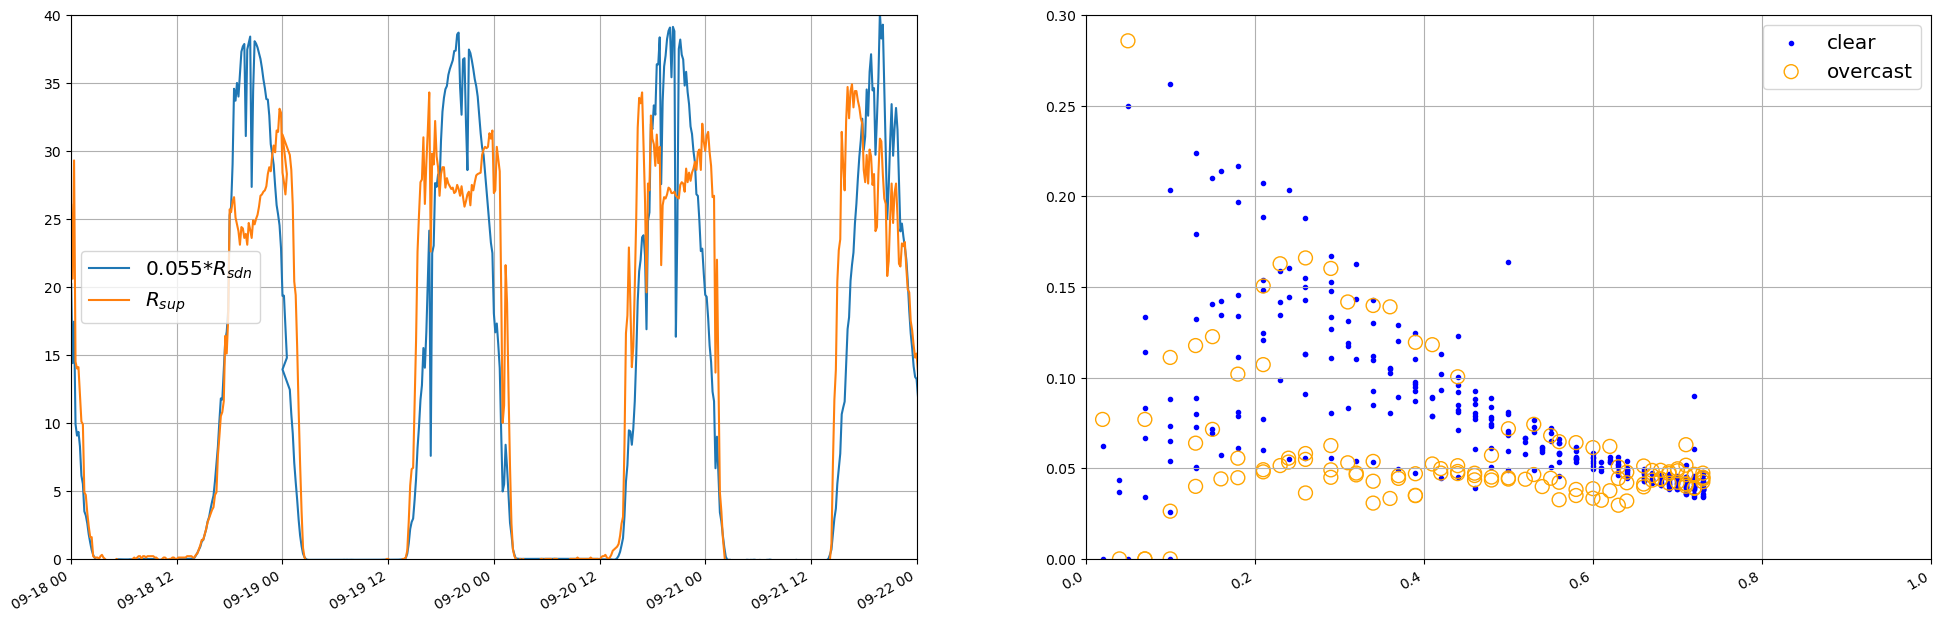

In [32]:
# Reproduce Chris' plots

fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize = ( 24, 8 ) )

# First plot compares upward shortwave estimated as albedo * Q_down
# and upward as measured (Q_up)
ax[0].plot(0.055*dset2['Sol flux_down'],label='0.055*$R_{sdn}$')
ax[0].plot(dset2['Sol flux_up'],label='$R_{sup}$')
ax[0].set_xlim([datetime.datetime(1995, 9, 18), datetime.datetime(1995, 9, 22)])
ax[0].set_ylim([0,40])
ax[0].grid()
fig.autofmt_xdate()
ax[0].legend(fontsize='x-large')

# Second plot compares albedo from clear and overcast days

# 1. clear days reported by Chris as 261.7-264.5
day1_clear = datetime.datetime.strptime('1995-261-'+str(int(0.7*24)), "%Y-%j-%H").strftime("%Y-%m-%d")
day2_clear = datetime.datetime.strptime('1995-264-'+str(int(0.5*24)), "%Y-%j-%H").strftime("%Y-%m-%d")
x_clear = dset2['Sun elevation angle'].loc[day1_clear:day2_clear]
y_clear = dset2['Sol flux_up'].loc[day1_clear:day2_clear]/dset2['Sol flux_down'].loc[day1_clear:day2_clear]

# 2. overcast days reported by Chris as 269.5-270.5
day1_overcast = datetime.datetime.strptime('1995-269-'+str(int(0.5*24)), "%Y-%j-%H").strftime("%Y-%m-%d")
day2_overcast = datetime.datetime.strptime('1995-270-'+str(int(0.5*24)), "%Y-%j-%H").strftime("%Y-%m-%d")
x_overcast = dset2['Sun elevation angle'].loc[day1_overcast:day2_overcast]
y_overcast = dset2['Sol flux_up'].loc[day1_overcast:day2_overcast]/dset2['Sol flux_down'].loc[day1_overcast:day2_overcast]

ax[1].scatter(x_clear,y_clear,color='blue',marker='.',label='clear')
ax[1].scatter(x_overcast,y_overcast,edgecolor='orange',facecolor='none',marker='o',s=100,label='overcast')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,0.3])
ax[1].grid()
ax[1].legend(fontsize='x-large')

plt.savefig('./output/Fairall_1.png',format='png',facecolor='white')

In [33]:
# set the location, start time and timezone for the integration
lat = flip_lat
lon = flip_lon
initial_time_utc = '1995-09-18 00:00:00'
init_time = datetime.datetime.strptime(initial_time_utc, '%Y-%m-%d %H:%M:%S')
TZ = lon * 24.0 / 360.0

# set the interval for the calculation in hours (dt), and the number of days to run (ndays)
dt = 1.0
ndays = 365.0

# Make a time-series (mtime) in UTC for resulting DataFrame
utc_time = pd.to_datetime(np.arange(int(dt)*24*int(ndays)),unit='h', utc=True, origin = pd.Timestamp(initial_time_utc))
local_time = pd.to_datetime(np.arange(int(dt)*24*int(ndays)),unit='h', utc=True, 
                            origin = pd.Timestamp(initial_time_utc)).map(lambda x: x.tz_convert('US/Pacific'))

# run all four methods
nmax = int(24.0*ndays/dt)

cls1 = [ clear_sky1(i,init_time,dt*3600,lat,lon) for i in range(nmax) ]
cls2 = [ clear_sky2(i,init_time,dt*3600,lat,lon) for i in range(nmax) ]
cls3 = [ clear_sky3(i,lat,lon,initial_time_utc) for i in range(nmax) ]
cls4 = [ clear_sky4(i,lat,lon,initial_time_utc,3.0,1010.0,0.07,0.07,0.1) for i in range(nmax) ]
    
# combine results into a DataFrame with UTC and separately local time as index
cls_utc = pd.DataFrame({'Date': utc_time, 'Ohlmann': cls1, 
                        'pysolar_ghi': [cls2[i][0] for i in range(nmax)],
                        'pysolar_dni': [cls2[i][1] for i in range(nmax)],
                        'pysolar_dhi': [cls2[i][2] for i in range(nmax)],
                        'pvlib_ghi': [cls3[i][0] for i in range(nmax)], 
                        'pvlib_dni': [cls3[i][1] for i in range(nmax)],
                        'pvlib_dhi': [cls3[i][2] for i in range(nmax)],
                        'Fairall_ghi': [cls4[i][0] for i in range(nmax)],
                        'Fairall_dni': [cls4[i][1] for i in range(nmax)],
                        'Fairall_dhi': [cls4[i][2] for i in range(nmax)] })
cls_utc = cls_utc.set_index('Date')
cls_local = pd.DataFrame({'Date': local_time, 'Ohlmann': cls1,
                        'pysolar_ghi': [cls2[i][0] for i in range(nmax)],
                        'pysolar_dni': [cls2[i][1] for i in range(nmax)],
                        'pysolar_dhi': [cls2[i][2] for i in range(nmax)],
                        'pvlib_ghi': [cls3[i][0] for i in range(nmax)], 
                        'pvlib_dni': [cls3[i][1] for i in range(nmax)],
                        'pvlib_dhi': [cls3[i][2] for i in range(nmax)],
                        'Fairall_ghi': [cls4[i][0] for i in range(nmax)],
                        'Fairall_dni': [cls4[i][1] for i in range(nmax)],
                        'Fairall_dhi': [cls4[i][2] for i in range(nmax)] })
cls_local = cls_local.set_index('Date')

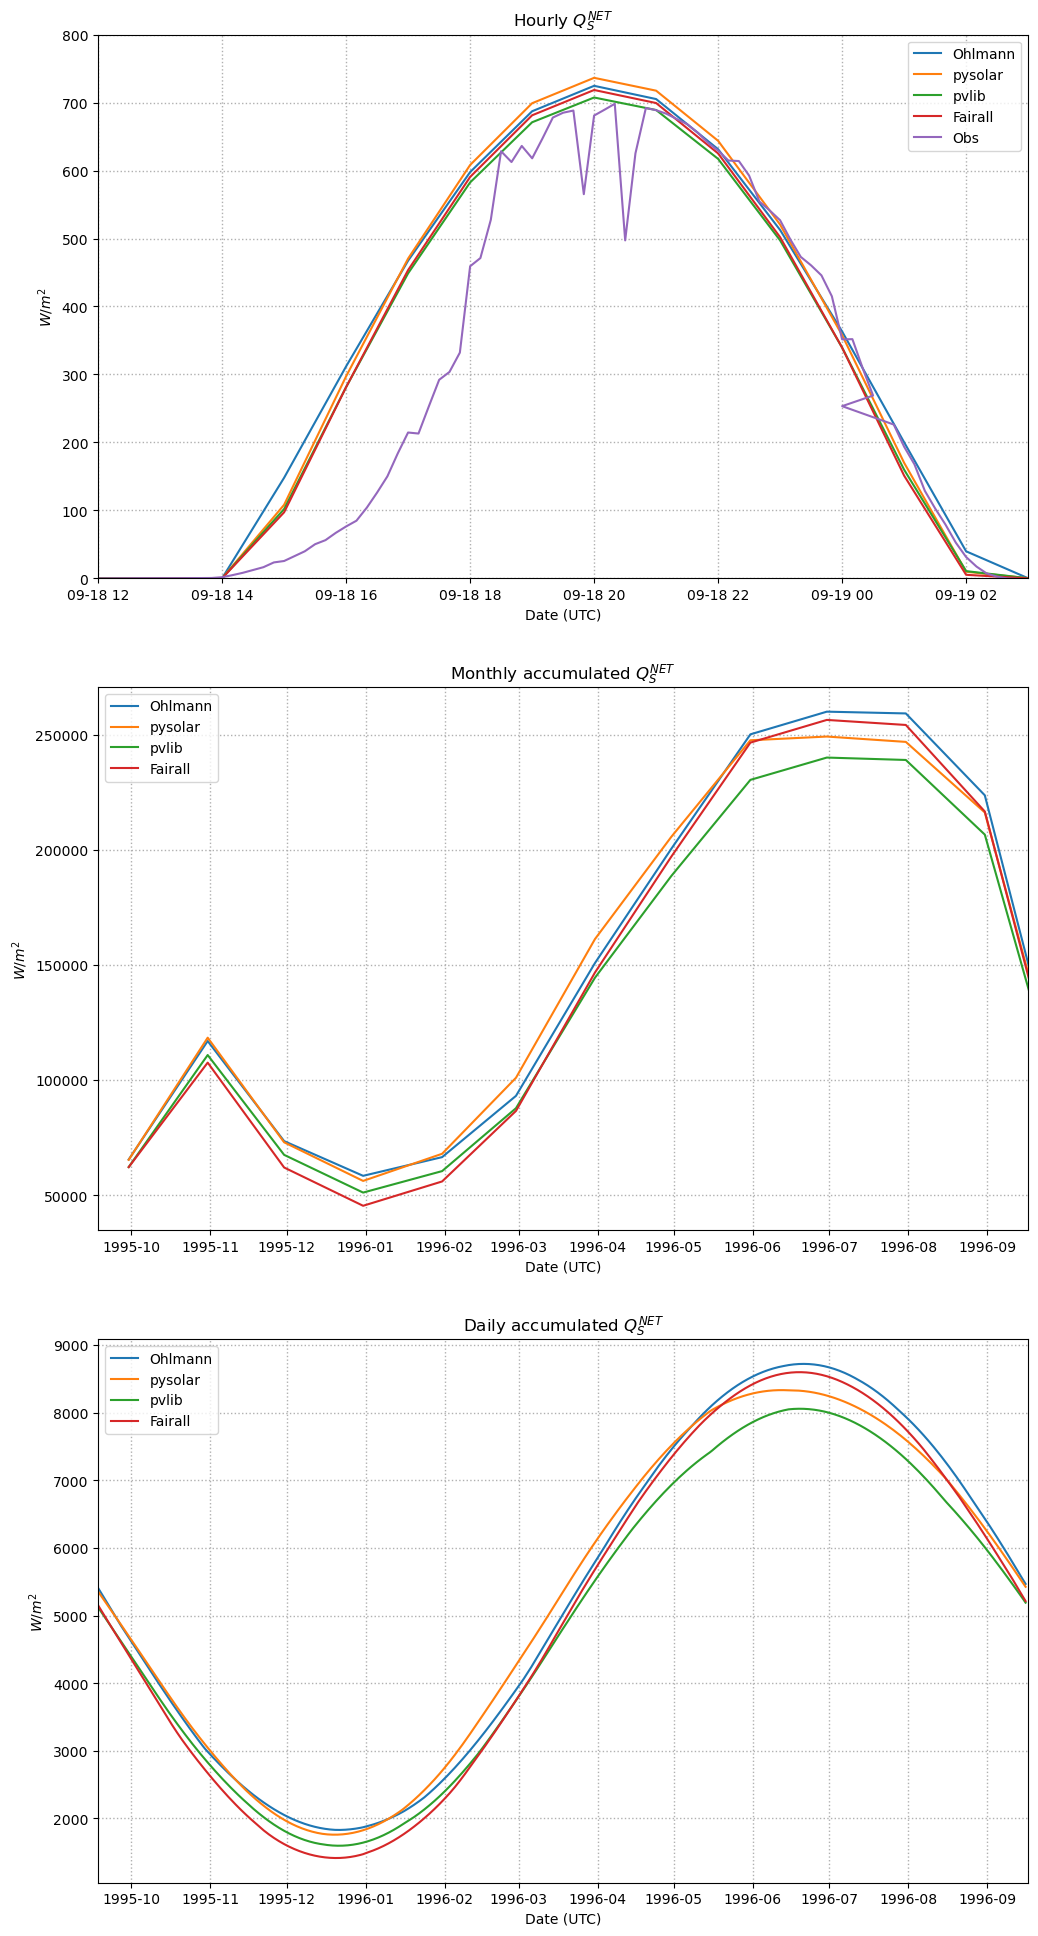

In [34]:
# Make plots
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 12, 24 ) )

# Note the idealized clear sky is computed using local time; can either plot that
# or UTC.  Since the Flip data are UTC, we stick with that
#cls_idealized = cls_local
#cls_idealized = cls_utc

# BIGGER NOTE: for some reason matplotlib ignores the timezone (?) so I 
# had to make this kuldge
df_slice_local = cls_local.loc[cls_local.index]
df_slice_utc = cls_utc.loc[cls_utc.index]
cls_idealized = df_slice_utc.tz_localize(None)


ax[0].plot(cls_idealized['Ohlmann'],label='Ohlmann')
ax[0].plot(cls_idealized['pysolar_ghi'],label='pysolar')
ax[0].plot(cls_idealized['pvlib_ghi'],label='pvlib')
ax[0].plot(cls_idealized['Fairall_ghi'],label='Fairall')
ax[0].plot(dset2['Sol flux_down'],label='Obs')
ax[0].set_xlim([datetime.datetime(1995, 9, 18, 12, 0, 0), datetime.datetime(1995, 9, 19, 3, 0, 0)])
ax[0].set_ylim(0,800)
ax[0].set_title('Hourly $Q_{S}^{NET}$')
ax[0].set_xlabel('Date (UTC)')
ax[0].set_ylabel('$W/m^2$')
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=1)

# monthly
ax[1].plot(cls_idealized['Ohlmann'].resample('M').sum(),label='Ohlmann')
ax[1].plot(cls_idealized['pysolar_ghi'].resample('M').sum(),label='pysolar')
ax[1].plot(cls_idealized['pvlib_ghi'].resample('M').sum(),label='pvlib')
ax[1].plot(cls_idealized['Fairall_ghi'].resample('M').sum(),label='Fairall')

ax[1].set_xlim([datetime.datetime(1995, 9, 18), datetime.date(1996, 9, 17)])
ax[1].set_title('Monthly accumulated $Q_{S}^{NET}$')
ax[1].legend()
ax[1].set_xlabel('Date (UTC)')
ax[1].set_ylabel('$W/m^2$')
ax[1].grid(linestyle=':', linewidth=1)

# daily
ax[2].plot(cls_idealized['Ohlmann'].resample('D').sum(),label='Ohlmann')
ax[2].plot(cls_idealized['pysolar_ghi'].resample('D').sum(),label='pysolar')
ax[2].plot(cls_idealized['pvlib_ghi'].resample('D').sum(),label='pvlib')
ax[2].plot(cls_idealized['Fairall_ghi'].resample('D').sum(),label='Fairall')
ax[2].set_xlim([datetime.date(1995, 9, 18), datetime.date(1996, 9, 17)])
ax[2].set_title('Daily accumulated $Q_{S}^{NET}$')
ax[2].legend()
ax[2].set_xlabel('Date (UTC)')
ax[2].set_ylabel('$W/m^2$')
ax[2].grid(linestyle=':', linewidth=1)

plt.savefig('./output/Fairall_2.png',format='png',facecolor='white')

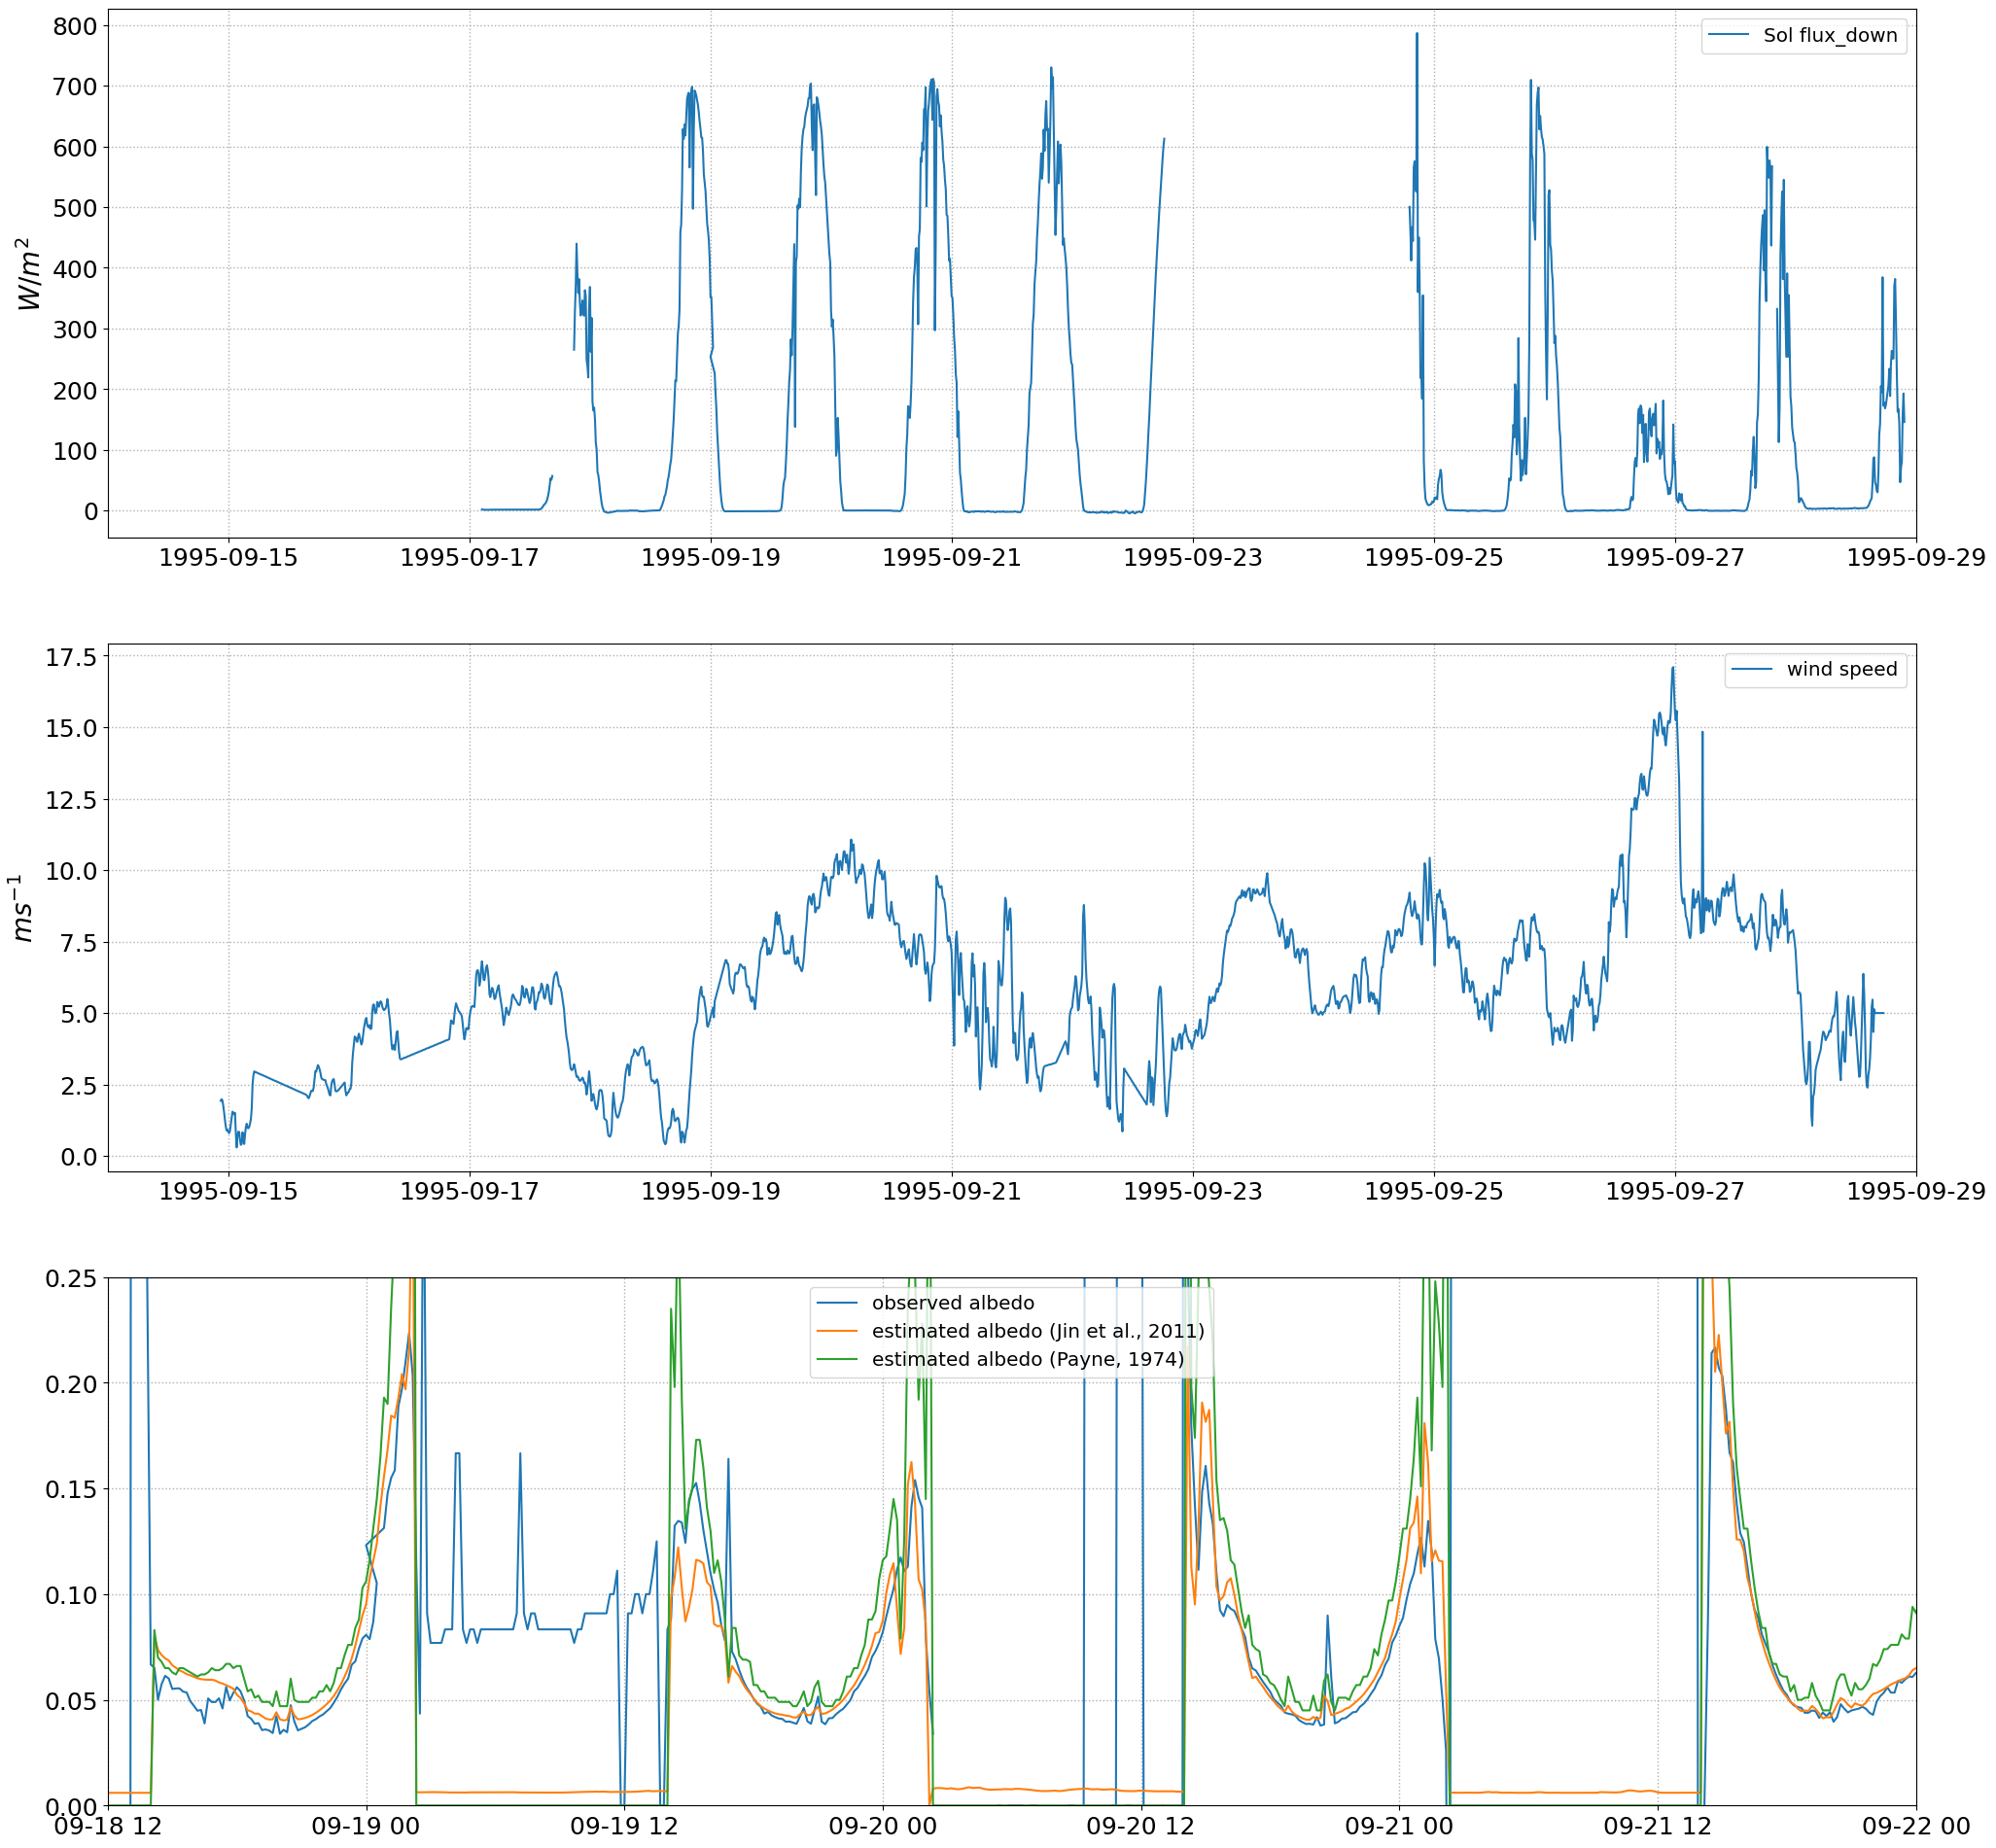

In [35]:
# Compare measured and computed albedo

albedo_obs = dset2['Sol flux_up']/dset2['Sol flux_down']

# this should match the above
initial_time_utc = '1995-09-14 22:30:00'
init_time = datetime.datetime.strptime(initial_time_utc, '%Y-%m-%d %H:%M:%S')

Isc = dset2['Sol flux_down'].to_numpy()
wspeed = dset2['Wind speed'].to_numpy()
ntime = len(Isc)
dt = 10 * 60
albedo_est1 = compute_albedo1(flip_lat,flip_lon,ntime,init_time,dt,wspd=wspeed,Ii=Isc)
albedo_est2 = compute_albedo2(flip_lat,flip_lon,ntime,init_time,dt,Isc)

# create time index for estimated albedo
ytime = np.array([init_time + datetime.timedelta(minutes=10*i) for i in range(ntime)])

# make plots
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 24, 24 ) )

ax[0].plot(dset2['Sol flux_down'],label='Sol flux_down')
ax[0].set_xlim([datetime.datetime(1995, 9, 14), datetime.datetime(1995, 9, 29)])
ax[0].set_ylabel('$W/m^2$', fontsize=20)
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=1)
ax[0].legend(fontsize='x-large')
ax[0].tick_params(axis='both', which='major', labelsize=18)

ax[1].plot(ytime,wspeed,label='wind speed')
ax[1].set_xlim([datetime.datetime(1995, 9, 14), datetime.datetime(1995, 9, 29)])
ax[1].set_ylabel('$m s^{-1}$', fontsize=20)
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=1)
ax[1].legend(fontsize='x-large')
ax[1].tick_params(axis='both', which='major', labelsize=18)

ax[2].plot(albedo_obs,label='observed albedo')
ax[2].plot(ytime,albedo_est1,label='estimated albedo (Jin et al., 2011)')
ax[2].plot(ytime,albedo_est2,label='estimated albedo (Payne, 1974)')
ax[2].set_xlim([datetime.datetime(1995, 9, 18, 12, 0, 0), datetime.datetime(1995, 9, 22)])
ax[2].set_ylim([0,0.25])
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=1)
ax[2].legend(fontsize='x-large')
ax[2].tick_params(axis='both', which='major', labelsize=18)

plt.savefig('./output/Fairall_3.png',format='png',facecolor='white')

[back to the top](#notebook_top)

<a id='clouds'></a>

# 4. Check clouds
Total cloud cover from ERA5 reanalysis at Copernicus https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form, saved to local netcdf.  This file has ten days worth of data at hourly interval (240 total time points), from Sept 16, 1995 (00:00) through Sept 25, 1995 (23:00).

In [36]:
# Load ISCCP data
isccp = pd.read_csv('./flip/ISCCP_clouds.txt', delimiter = None, names = ['clouds'] )
isccp = pd.to_numeric(isccp['clouds'], errors='coerce').to_frame()
isccp['clouds'][isccp['clouds']>1] = np.nan
isccp['clouds'][isccp['clouds']<0] = np.nan
    
# Next we create a date string at 3-hourly interval and add this to the
# dataframe
base = datetime.datetime(year=1995, month=9, day=16, hour=0)
date_list = [base + datetime.timedelta(hours=3*x) for x in range(len(isccp))]
isccp.insert(0,'Date',pd.to_datetime(date_list))

df_1 = pd.merge(dset2,isccp,how='outer',on='Date')
df_qnet1 = pd.merge(cls_idealized,df_1,how='outer',on='Date')

# Use this to make plot connect over missing values. Otherwise since this
# is a three-hourly data set, it will have NaN's twice for every other hour,
# and will plot as points.  This will enable connecting the dots.
s1mask = np.isfinite(df_qnet1['clouds'])

In [37]:
# Load ERA5 data and extract clouds
cloud_dset = Dataset('./flip/ERA5_clouds.nc')
# Flip site is at lon(4), lat(3) found manually; time is measured from Jan 1, 1900 also
# determined manually
cloud_cover = cloud_dset['tcc'][:,4,3]
cloud_time = cloud_dset['time'][:]
obs_time = pd.to_datetime(cloud_time, unit='h', origin = pd.Timestamp('1900-01-01 00:00:00'))

# Combine the clear sky estimates, clouds and observed data all into a single
# dataframe.  I do this in two steps (not sure if can do three at once)
testvar1 = pd.DataFrame(obs_time,columns=['Date'])
testvar2 = pd.DataFrame(cloud_cover,columns=['clouds'])
df_2 = pd.concat([testvar1,testvar2],axis=1,join='inner')
df_3 = pd.merge(dset2,df_2,how='outer',on='Date')
df_qnet2 = pd.merge(cls_idealized,df_3,how='outer',on='Date')

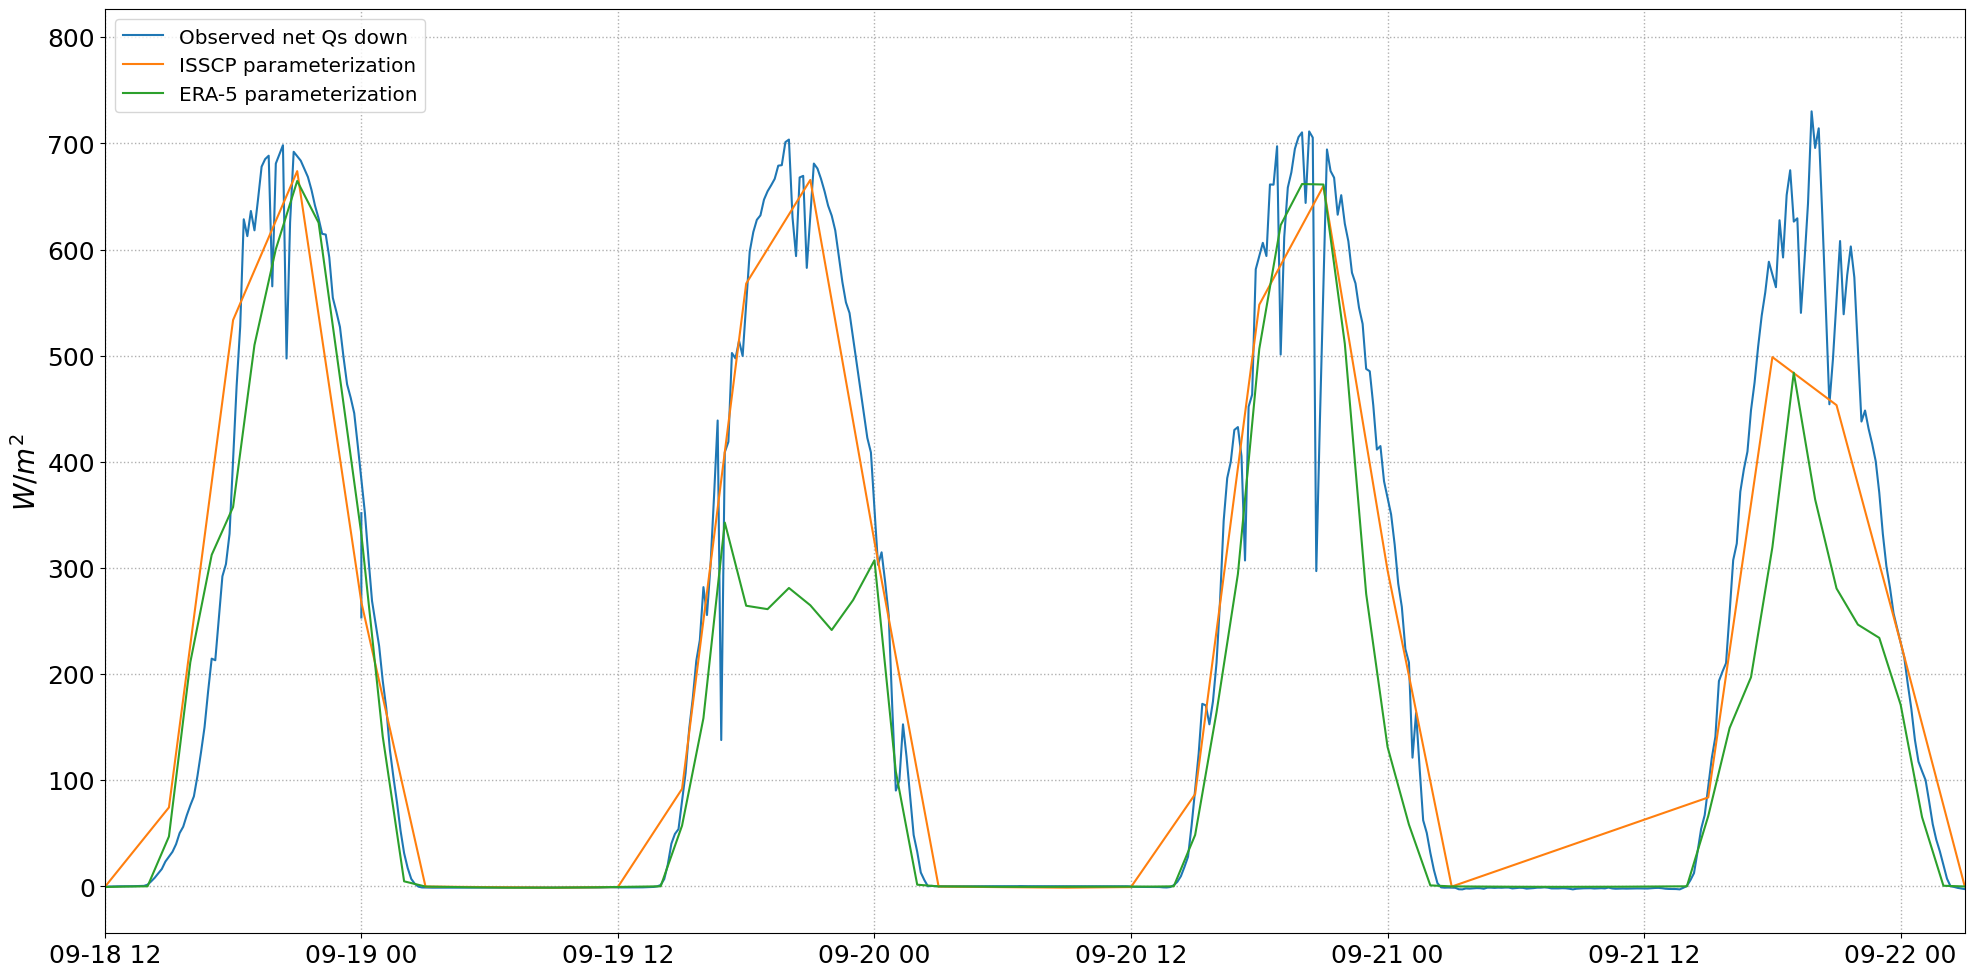

In [38]:
# Make a comparison plot

fig, ax = plt.subplots( nrows = 1, ncols = 1, figsize = ( 24, 12 ) )

ax.plot(df_qnet2['Date'],df_qnet2['Sol flux_down'],label='Observed net Qs down')
ax.plot(df_qnet1['Date'][s1mask],df_qnet1['Fairall_ghi'][s1mask]*(1-0.62*df_qnet1['clouds'][s1mask]),label='ISSCP parameterization')
ax.plot(df_qnet2['Date'],df_qnet2['Fairall_ghi']*(1-0.62*df_qnet2['clouds']),label='ERA-5 parameterization')
ax.set_xlim([datetime.datetime(1995, 9, 18, 12, 0, 0), datetime.datetime(1995, 9, 22, 3, 0, 0)])

ax.set_ylabel('$W/m^2$', fontsize=20)
ax.legend()
ax.grid(linestyle=':', linewidth=1)
ax.legend(fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=18)

[back to the top](#notebook_top)

<a id='ors_comp'></a>

# 5.  Ocean Reference Stations (ORS) and Operational Model (CFSv2)

We now repeat this exercise, but use the mooring-based measurements of $Q_{S}$.  Note that the calculation of clear-sky took a very long time, so it was done once off-line, and the results were saved as a pickle file.

<font color=red>
Notes:
    
 1. $Q_S^{Clear} - Q_S^{Cloud}$ is typically referred to as "downward shortwave heat flux at the surface", $Q_S^{Reflect}$ is "upward shortwave heat flux at the surface", and $Q_S^{Net}$ is the "net surface shortwave heat flux".  
    
 2. The ORS files have $Q_S^{Clear} - Q_S^{Cloud}$ as $SW$ in the MLTS files, whereas $Q_S^{Net}$ is given in the FLTS files as $QS$.
    
 3. The CFS model uses dswsfc for $Q_S^{Clear} - Q_S^{Cloud}$ and uswsfc for $Q_S^{Reflect}$.
 
 2. In C. Fairall's matlab scripts, he uses $rsn$ for $Q_S^{Net}$ and $rs$ for $Q_S^{Clear} - Q_S^{Cloud}$.
</font>

In [39]:
site = 'WHOTS'

if site == 'WHOTS':
    lat = 22.7667
    lon = -157.8983
    tz_offset = -10
if site == 'NTAS':
    lat = 14.75
    lon = -51.25
    tz_offset = -3
if site == 'Stratus':
    lat = -20.00
    lon = -85.25
    tz_offset = -6

In [40]:
# load CFSv2 data; note the model provides both upward and downward Qs
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_dswsfc.dat')
cfs_qs_down = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_uswsfc.dat')
cfs_qs_up = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_prate.dat')
cfs_rain = data[:,1] * 3600.0
cfs_time = pd.to_datetime([i for i in range(len(cfs_qs_up))], unit='h', origin = pd.Timestamp('1979-01-01 00:00:00'))

In [41]:
def matlab2datetime(matlab_datenum):
    day = datetime.datetime.fromordinal(int(matlab_datenum))
    dayfrac = datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days = 366)
    return day + dayfrac

In [42]:
# load ORS obs

# WHOTS
if site == 'WHOTS':
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_met_1hr.mat',squeeze_me=True)
    obs_qs = fin1['Qs']
    obs_rain = fin2['prate']

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[82:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[82:])
    
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[84:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[84:] )

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[60:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[60:] )
    
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs'] 
    obs_qs = np.append ( obs_qs, data[54:] )
    data = fin2['prate'] 
    obs_rain = np.append ( obs_rain, data[54:] )
    
    obs_time = pd.date_range('2004-08-13 04:30:00', '2017-07-31 15:30:00', freq='H')
    
# Stratus
if site == 'Stratus':
    '''
    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str1to10_best_flux_1hr.mat',\
                    squeeze_me=True)
    otime = fin['mday']
    obs_qs = fin['Qs']
    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str11to14_best_flux_1hr.mat',\
                   squeeze_me=True)
    data = fin['mday']
    otime = np.append ( otime, data )
    data = fin['Qs']
    obs_qs = np.append ( obs_qs, data )
    obs_time = [matlab2datetime(tval) for tval in otime]
    obs_time = pd.to_datetime(pd.Series(obs_time))
    '''
    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2000-2010_D_FLTS-1hr.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2000-2010_D_MLTS-1hr.nc', 'r')
    obs_time = np.array(fin1.variables['TIME'])
    obs_rain = np.array(fin2.variables['RAIN'])
    obs_qs = np.array(fin1.variables['QS'])  

    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2011-2015_D_FLTS-1hr_orig.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2011-2015_D_MLTS-1hr.nc', 'r')
    data = np.array(fin1.variables['TIME'])
    obs_time = np.append(obs_time,data)
    data = np.array(fin2.variables['RAIN'])
    obs_rain = np.append(obs_rain,data)
    data = np.array(fin1.variables['QS'])  
    obs_qs = np.append(obs_qs,data)
    
    obs_time = pd.to_datetime(obs_time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))
    
# NTAS
if site == 'NTAS':
    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_NTAS_2001-2012_D_FLTS-1hr.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_NTAS_2001-2012_D_MLTS-1hr.nc', 'r')
    obs_time = np.array(fin1.variables['TIME'])
    obs_rain = np.array(fin2.variables['RAIN'])
    obs_qs = np.array(fin1.variables['QS'])
    
    obs_time = pd.to_datetime(obs_time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))

In [43]:
# Daily files from Bob W. sent on 08-06-2021
'''
# WHOTS
if site == 'WHOTS':
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_flux_1d.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_met_1d.mat',squeeze_me=True)
    obs_qs = fin1['Qs']
    obs_rain = fin2['prate']
    obs_time = pd.date_range('2004-08-14 12:00:00'...
    
# Stratus
if site == 'Stratus':
    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_flux_1d.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_met_1d.mat',squeeze_me=True)
    otime = fin['mday']
    obs_qs = fin['Qs']
    obs_time = pd.date_range('2000-10-09 12:00:00'...

# NTAS
if site == 'NTAS':
    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_flux_1d.mat', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_met_1d.mat', 'r')
    otime = fin['mday']
    obs_qs = fin['Qs']
    obs_time = pd.date_range('2001-03-31 12:00:00'...
'''

"\n# WHOTS\nif site == 'WHOTS':\n    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_flux_1d.mat',squeeze_me=True)\n    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_met_1d.mat',squeeze_me=True)\n    obs_qs = fin1['Qs']\n    obs_rain = fin2['prate']\n    obs_time = pd.date_range('2004-08-14 12:00:00'...\n    \n# Stratus\nif site == 'Stratus':\n    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_flux_1d.mat',squeeze_me=True)\n    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_met_1d.mat',squeeze_me=True)\n    otime = fin['mday']\n    obs_qs = fin['Qs']\n    obs_time = pd.date_range('2000-10-09 12:00:00'...\n\n# NTAS\nif site == 'NTAS':\n    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_flux_1d.mat', 'r')\n    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_met_1d.mat', 'r')\n    otime = fin['mday']\n    obs_qs = fin['Qs']\n    obs_time = pd.date_range('2001-03-31 12:00:00'...\

In [44]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve( interval, window, 'valid' )

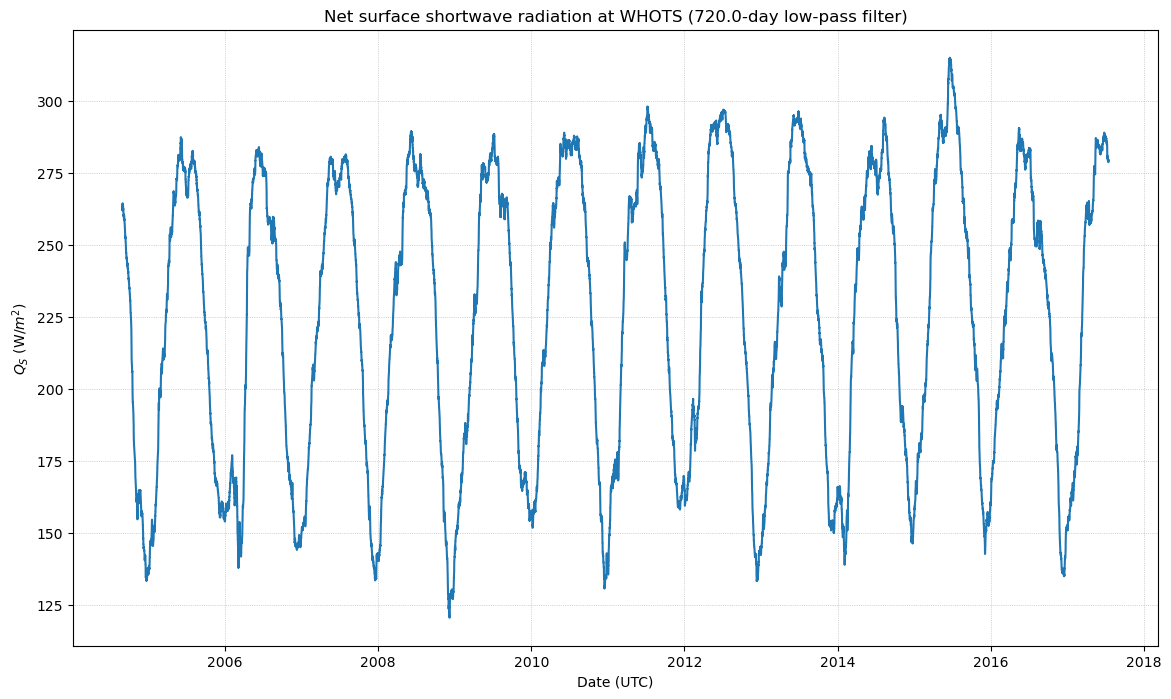

In [45]:
# Plot entire record at 30-day low-pass
lpass = 30.0
lpass = lpass * 24.0
obs_lf = movingaverage(obs_qs,lpass)
obs_lf = np.append(obs_lf,[np.nan]*int(lpass/2))
obs_lf = np.append([np.nan]*(int(lpass/2)-1),obs_lf)

fig, ax = plt.subplots( figsize = ( 14, 8 ) )
ax.plot(obs_time,obs_lf)
ax.set_title('Net surface shortwave radiation at ' + site + ' (' + str(lpass) + '-day low-pass filter)' )
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{S}$ (W/$m^2$)')
ax.grid(linestyle=':', linewidth=0.5)
plt.savefig('./output/' + site + '_CFS_3daycomp.png',format='png',facecolor='white')

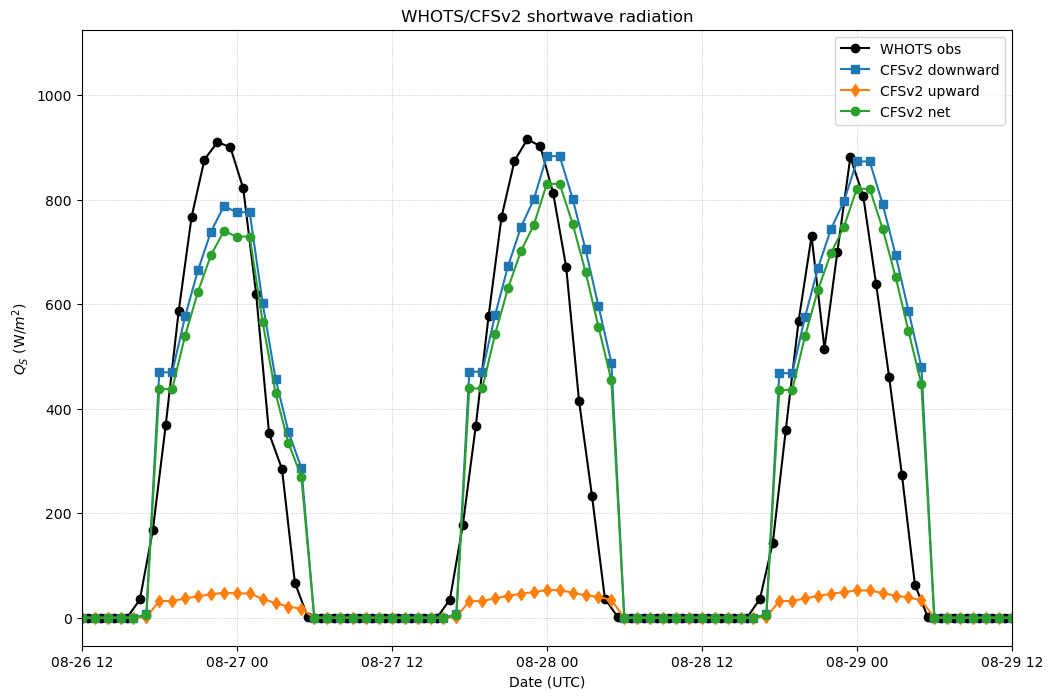

In [46]:
# Plot an arbitrary three-day period

fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(obs_time,obs_qs,'ko-',label=site + ' obs')
ax.plot(cfs_time,cfs_qs_down,'s-',label='CFSv2 downward')
ax.plot(cfs_time,cfs_qs_up,'d-',label='CFSv2 upward')
ax.plot(cfs_time,cfs_qs_down-cfs_qs_up,'o-',label='CFSv2 net')
ax.set_xlim([datetime.datetime(2008, 8, 26, 12), datetime.datetime(2008, 8, 29, 12)])
ax.set_title(site+'/CFSv2 shortwave radiation')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{S}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)
plt.savefig('./output/' + site + '_CFS_3daycomp.png',format='png',facecolor='white')

In [47]:
# convert the model and observation time from UTC to local time to match computed values
#obs_time = obs_time - pd.tseries.offsets.DateOffset(hours=tz_offset)
#cfs_time = cfs_time - pd.tseries.offsets.DateOffset(hours=tz_offset)

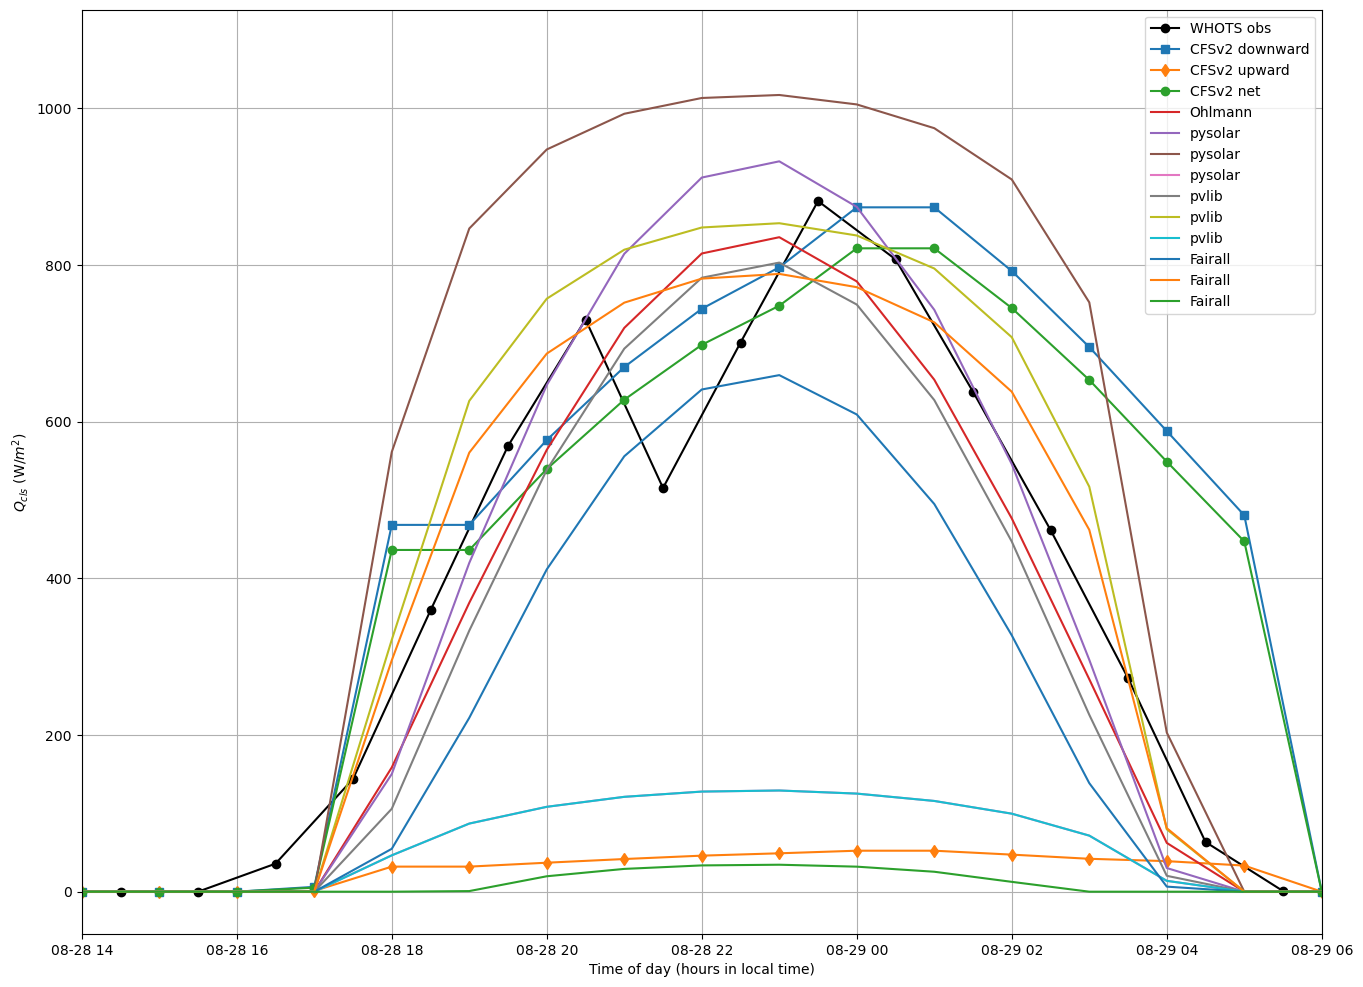

In [48]:
# Specify 3-day period at hourly interval, 3*24 points
initial_time = '2020-02-06 12:00:00'
t_ref = datetime.datetime.strptime(initial_time, '%Y-%m-%d %H:%M:%S')

nmax = 3 * 24
dt = 1
cls1 = [ clear_sky1(i,t_ref,dt*3600,lat,lon) for i in range(nmax) ]
cls2 = [ clear_sky2(i,t_ref,dt*3600,lat,lon) for i in range(nmax) ]
cls3 = [ clear_sky3(i,lat,lon,t_ref) for i in range(nmax) ]
#cls4 = [ clear_sky4(i,lat,lon,t_ref,3.0,1010.0,0.07,0.07,0.1) for i in range(nmax) ]
cls4 = [ clear_sky4(i,lat,lon,t_ref,5.0,1013.0,0.3,0.3,0.3) for i in range(nmax) ]

local_time = pd.to_datetime([i for i in range(72)], unit='h', origin = pd.Timestamp('2008-08-26 12:00:00')).tz_localize('US/Hawaii')
utc_time = pd.to_datetime([i for i in range(72)], unit='h', origin = pd.Timestamp('2008-08-26 12:00:00')).tz_localize('UTC')

fig, ax = plt.subplots( figsize = ( 16, 12 ) )
ax.plot(obs_time,obs_qs,'ko-',label=site+' obs')
ax.plot(cfs_time,cfs_qs_down,'s-',label='CFSv2 downward')
ax.plot(cfs_time,cfs_qs_up,'d-',label='CFSv2 upward')
ax.plot(cfs_time,cfs_qs_down-cfs_qs_up,'o-',label='CFSv2 net')
ax.set_xlim([datetime.datetime(2008, 8, 28, 14), datetime.datetime(2008, 8, 29, 6)])

plt.plot(utc_time,cls1,'-',label='Ohlmann')
plt.plot(utc_time,cls2,'-',label='pysolar')
plt.plot(utc_time,cls3,'-',label='pvlib')
plt.plot(utc_time,cls4,'-',label='Fairall')
#plt.plot(local_time,cls1,'-',label='Ohlmann')
#plt.plot(local_time,cls2,'-',label='pysolar')
#plt.plot(local_time,cls3,'-',label='pvlib')
#plt.plot(local_time,cls4,'-',label='Fairall')
plt.legend()
plt.xlabel('Time of day (hours in local time)')
plt.ylabel('$Q_{cls}$ (W/$m^2$)')
plt.grid()
fig_out = './output/' + site + '_CFS_Qs_comp.png'
plt.savefig(fig_out,facecolor='white',format='png')

In [ ]:
'''
One way to do this is "in-line", but it takes about 4 or 5 hours to run
so instead I've run it "off-line" using make_cls.py and put the results in 
a pickle file, then just read that here
'''
import pickle
file_Name = '../misc/clear_sky_3comp_' + site
fileObject = open(file_Name,'rb')
cls_data = pickle.load(fileObject)
fileObject.close()

In [ ]:
cls_data

In [ ]:
# make a comparison between the different records
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ax.plot(obs_time,obs_qs,label='Observed $Q_{S}^{NET}$')
ax.plot(cfs_time,cfs_qs_down,label='CFS $Q_{S}^{down}$')
ax.plot(cls_data['Time'],cls_data['pysolar'],label='pysolar')
ax.plot(cls_data['Time'],cls_data['ohlmann'],label='Ohlmann')
ax.plot(cls_data['Time'],cls_data['pvlib'],label='pvlib')
plt.legend()

# zoom in to some arbirary two day period
ax.set_xlim([datetime.date(2004, 8, 26), datetime.date(2004, 8, 29)])
ax.grid()
ax.set_title('Shortwave Radiation at '+ site)
fig_out = './output/' + site + '_CFS_Qs_comp2.png'
plt.savefig(fig_out,facecolor='white',format='png')

In [ ]:
# make a single DataFrame
obs_data = pd.DataFrame({'Time':obs_time, 'obs_qs': obs_qs, 'obs_rain': obs_rain})
cfs_data = pd.DataFrame({'Time':cfs_time, 'cfs_down': cfs_qs_down, 'cfs_up': cfs_qs_up, 'cfs_rain': cfs_rain})
temp = pd.merge_asof(obs_data,cfs_data,on='Time', tolerance=pd.Timedelta('60 minute'))
AllData = pd.merge_asof(temp,cls_data,on='Time',tolerance=pd.Timedelta('60 minute')) 

In [ ]:
# Do correlation/scatter plots

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))

lag = 0
# 1. upper left is CFS downward vs. CFS upward
x = AllData['cfs_down']
y = AllData['cfs_up']
ax[0,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation CFS downward to CFS upward: ' + str(C[0]) )
ax[0,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[0,0].set_ylabel('CFS $Q_{S}^{up}$')
ax[0,0].set_title(site)

lag = 3
# 2. upper right is CFS net vs. observations
x = AllData['cfs_down']-AllData['cfs_up']
y = AllData['obs_qs']
ax[0,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[0,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation CFS downward to observations: ' + str(C[0]) )
ax[0,1].set_xlabel('CFS $Q_{S}^{Net}$')
ax[0,1].set_ylabel('Observed $Q_{S}$')
ax[0,1].set_title(site)

lag = 3
# 3. 2nd left is CFS downward vs. Ohlmann clearsky
x = AllData['cfs_down']
y = AllData['ohlmann']
ax[1,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[1,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation CFS downward to Ohlmann clear sky: ' + str(C[0]) )
ax[1,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[1,0].set_ylabel('Ohlmann $Q^{cls}$')

lag = 3
# 4. 3rd left is CFS downward vs. Fairall clearsky
x = AllData['cfs_down']
y = AllData['fairall']
ax[2,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[2,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation CFS downward to Fairall clear sky: ' + str(C[0]) )
ax[2,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[2,0].set_ylabel('Fairall $Q^{cls}$')

lag = 3
# 4. bottom left is CFS downward vs. pvlib
x = AllData['cfs_down']
y = AllData['pvlib']
ax[3,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[3,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation CFS downward to pvlib: ' + str(C[0]) )
ax[3,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[3,0].set_ylabel('pvlib $Q^{cls}$')

lag = 0
# 5. 2nd right is obs vs. Ohlmann clearsky
x = AllData['obs_qs']
y = AllData['ohlmann']
ax[1,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[1,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation Observations to Ohlmann clear sky: ' + str(C[0]) )
ax[1,1].set_xlabel('Obs $Q_{S}$')
ax[1,1].set_ylabel('Ohlmann $Q^{cls}$')

lag = 0
# 6. 3rd right is obs vs. Fairall clear sky
x = AllData['obs_qs']
y = AllData['fairall']
ax[2,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[2,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation Observations to Fairall clear sky: ' + str(C[0]) )
ax[2,1].set_xlabel('Obs $Q_{S}^{down}$')
ax[2,1].set_ylabel('Fairall $Q^{cls}$')

lag = 0
# 6. bottom right is obs vs. pvlib clear sky
x = AllData['obs_qs']
y = AllData['pvlib']
ax[3,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
#ax[3,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
if lag == 0:
    C = np.polyfit(Zx,Zy,1)
elif lag > 0:
    C = np.polyfit(Zx[lag:None],Zy[:-lag],1)
elif lag < 0:
    C = np.polyfit(Zx[:lag],Zy[-lag:None],1)
print('Correlation Observations to pvlib clear sky: ' + str(C[0]) )
ax[3,1].set_xlabel('Obs $Q_{S}^{down}$')
ax[3,1].set_ylabel('pvlib $Q^{cls}$')

for r in range(4):
    for c in range(2):
        if r + c > 0:
            ax[r,c].plot([0,1200],[0,1200],color='red')
            ax[r,c].set_xlim(0,1200)
            ax[r,c].set_ylim(0,1200)
        ax[r,c].grid(linestyle=':', linewidth=0.5)
        ax[r,c]
        
plt.savefig('./output/' + site + '_CFS_correlations.png',format='png',facecolor='white')

Just an example of saving these DataFrames to an ascii CSV

In [ ]:
# Example saving DataFrame to csv file
AllData2 = AllData.drop(['Time'],axis=1)
AllData2.to_csv('mydf.dat', sep=',')

## 5.1  Estimation of Albedo
As noted above, the albedo is a measurement of reflected shortwave to incoming.  Most models, including the calculation of net shortwave for the buoys, use a constant value of about 0.05 for the tropical ocean.  Here we look at the validity of this choice.

First, a ratio of the observed shortwave to the clear-sky should provide one clue.

In [ ]:
# compare CFS up and downward (result should be albedo)
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(14,6))
y = AllData['cfs_up']/AllData['cfs_down']
t = AllData['Time']
ax[0].plot(t,y)
ax[1].plot(t,y)
ax[1].set_xlim([datetime.date(2010, 1, 1), datetime.date(2010, 12, 31)])
ax[1].set_ylim(0,0.35)
print('Mean albedo = ' + str(np.nanmean(y)))
ax[0].grid(linestyle=':', linewidth=0.5)
ax[1].grid(linestyle=':', linewidth=0.5)
ax[0].set_title('CFSv2 estimated albedo ($Q^{up}_{S}/Q^{down}_{S}$) at ' + site)
plt.savefig( './output/' + site + '_CFS_albedo.png',format='png',facecolor='white')

## 5.2 Lower-frequency comparisons

In [ ]:
# Here we do some operations on time, e.g., daily mean, sums, etc.  To do this we need to replace 
# the DataFrame index to be time.  I also add in rainfall
# read precip data from PERSIANN
infile = '/Volumes/JIMP_DATA2/PERSIANN_HOURLY/' + site + '_precip.dat'
r = pd.read_csv(infile, sep=' ', header=None)
rain = r[1]
rain[rain<0.0] = 0.0
rtime = pd.to_datetime([i for i in range(len(r))], unit='h', origin = pd.Timestamp('2003-01-01 00:00:00'))
rain_data = pd.DataFrame({'Time':rtime, 'persiann_rain': rain})
AllData2 = pd.merge_asof(AllData,rain_data,on='Time',tolerance=pd.Timedelta('60 minute')) 
AllData3 = AllData2.set_index(AllData2['Time'])
AllData3 = AllData3.drop(columns='Time')

In [ ]:
# A few examples: 
#  1. compute daily mean (e.g.)
#AllData3.resample('D').mean()
#  2. compute daily/monthly accumulation
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 12, 24 ) )
# annual
ax[0].plot(AllData3['obs_qs'].resample('Y').sum(),label='Buoy obs')
ax[0].plot(AllData3['cfs_down'].resample('Y').sum(),label='CFS')
ax[0].plot(AllData3['ohlmann'].resample('Y').sum(),label='Ohlmann')
ax[0].set_xlim([datetime.date(2002, 1, 1), datetime.date(2014, 12, 31)])
ax[0].set_ylim(1750000,2750000)
ax[0].set_title('Annual accumulated $Q_{S}^{NET}$ at ' + site)
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('Y').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('Y').sum())))
print('Mean Ohlmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('Y').sum())))

# monthy
ax[1].plot(AllData3['obs_qs'].resample('M').sum(),label='Buoy obs')
ax[1].plot(AllData3['cfs_down'].resample('M').sum(),label='CFS')
ax[1].plot(AllData3['ohlmann'].resample('M').sum(),label='Ohlmann')
ax[1].set_xlim([datetime.date(2002, 1, 1), datetime.date(2014, 12, 31)])
#ax[1].set_ylim(0,10000)
ax[1].set_title('Monthly accumulated $Q_{S}^{NET}$ at ' + site)
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('M').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('M').sum())))
print('Mean Ohlmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('M').sum())))

# daily
ax[2].plot(AllData3['obs_qs'].resample('D').sum(),label='Buoy obs')
ax[2].plot(AllData3['cfs_down'].resample('D').sum(),label='CFS')
ax[2].plot(AllData3['ohlmann'].resample('D').sum(),label='Ohlmann')
ax[2].set_xlim([datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)])
ax[2].set_ylim(0,10000)
ax[2].set_title('Daily accumulated $Q_{S}^{NET}$ at ' + site)
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('D').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('D').sum())))
print('Mean Olhmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('D').sum())))

# save figure
plt.savefig( './output/' + site + '_qs_accum.png',format='png',facecolor='white')
#plt.savefig('WHOTS_qs_accum.pdf',format='pdf',dpi=300)

In [ ]:
# try comparison of daily max Qs
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 12, 24 ) )

# annual
grouped = AllData3.groupby(pd.Grouper(freq='Y'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[0].plot(x,label='Buoy obs')
ax[0].plot(y,label='CFS')
ax[0].plot(z,label='Ohlmann')
ax[0].set_xlim([datetime.date(2002, 1, 1), datetime.date(2014, 12, 31)])
#ax[0].set_ylim(1750000,2750000)
ax[0].set_title('Annual maximum $Q_{S}^{NET}$ at ' + site)
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Ohlmann: ' + str(np.nanmean(z)))

# monthy
grouped = AllData3.groupby(pd.Grouper(freq='M'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[1].plot(x,label='Buoy obs')
ax[1].plot(y,label='CFS')
ax[1].plot(z,label='Ohlmann')
ax[1].set_xlim([datetime.date(2002, 1, 1), datetime.date(2014, 12, 31)])
#ax[1].set_ylim(0,10000)
ax[1].set_title('Monthly maximum $Q_{S}^{NET}$ at ' + site)
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Ohlmann: ' + str(np.nanmean(z)))

# daily
grouped = AllData3.groupby(pd.Grouper(freq='D'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[2].plot(x,label='Buoy obs')
ax[2].plot(y,label='CFS')
ax[2].plot(z,label='Ohlmann')
ax[2].set_xlim([datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)])
ax[2].set_ylim(0,1200)
ax[2].set_title('Daily max $Q_{S}^{NET}$ at ' + site)
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Olhmann: ' + str(np.nanmean(z)))

# save figure
plt.savefig( './output/' + site + '_qs_max.png', format='png', facecolor='white')
#plt.savefig('WHOTS_qs_max.pdf', format='pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

ax[0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily obs to CFS: ' + str(C[0]) )
ax[0].set_xlabel('Buoy $Q_{S}^{NET}$')
ax[0].set_ylabel('CFS $Q_{S}^{down}$')
ax[0].set_title(site)
ax[0].set_xlim(600, 1200)
ax[0].set_ylim(600, 1200)
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].scatter(x,z,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(z)
B = np.polyfit(x[idx],z[idx],1)
A = np.polyval(B,x)
ax[1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily obs to Ohlmann: ' + str(C[0]) )
ax[1].set_xlabel('Buoy $Q_{S}^{NET}$')
ax[1].set_ylabel('Olhmann $Q_{S}^{clear}$')
ax[1].set_title(site)
ax[1].set_xlim(600, 1200)
ax[1].set_ylim(600, 1200)
ax[1].grid(linestyle=':', linewidth=0.5)

ax[2].scatter(y,z,s=1,rasterized=True)
idx = np.isfinite(y) & np.isfinite(z)
B = np.polyfit(y[idx],z[idx],1)
A = np.polyval(B,y)
ax[2].plot(y,A,color='red')
Zx = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
Zy = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily CFS to Ohlmann: ' + str(C[0]) )
ax[2].set_xlabel('CFS $Q_{S}^{down}$')
ax[2].set_ylabel('Olhmann $Q_{S}^{clear}$')
ax[2].set_title(site)
ax[2].set_xlim(600, 1200)
ax[2].set_ylim(600, 1200)
ax[2].grid(linestyle=':', linewidth=0.5)

The best correlation is Ohlmann clear-sky to the observations.  The CFS up and down shortwave are very highly correlated, thus suggesting a constant albedo is appropriate.

To next investigate clouds, we try to look at the correlation of shortwave to rainfall.  To do this we read rain from PERSIANN (satellite-derived) and compare to the CFS and buoy rainfall estimates

# 6.  Rainfall as proxy for clouds?

In [ ]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(rtime,rain)
plt.grid()

In [ ]:
# make some correlation plots
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,12))

# 1. Upper left observed vs. CFS rain
x = AllData2['obs_rain']
y = AllData2['cfs_rain']
ax[0,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation Observed to CFS rainfaill: ' + str(C[0]) )
ax[0,0].set_xlabel('observed rainfall')
ax[0,0].set_ylabel('CFS rainfall')
ax[0,0].set_title(site)
ax[0,0].grid(linestyle=':', linewidth=0.5)

# 2. Upper right observed vs. PERSIANN rain
x = AllData2['obs_rain']
y = AllData2['persiann_rain']
ax[0,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation Observed to PERSIANN rainfaill: ' + str(C[0]) )
ax[0,1].set_xlabel('observed rainfall')
ax[0,1].set_ylabel('PERSIANN rainfall')
ax[0,1].set_title(site)
ax[0,1].grid(linestyle=':', linewidth=0.5)

# 3. Lower left CFS vs. PERSIANN rain
x = AllData2['cfs_rain']
y = AllData2['persiann_rain']
ax[1,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS to PERSIANN rainfaill: ' + str(C[0]) )
ax[1,0].set_xlabel('CFS rainfall')
ax[1,0].set_ylabel('PERSIANN rainfall')
ax[1,0].set_title(site)
ax[1,0].grid(linestyle=':', linewidth=0.5)

# 3. Lower right estimated clouds vs. PERSIANN rain
x = AllData2['ohlmann'] - AllData2['obs_qs']
y = AllData2['persiann_rain']
ax[1,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation clouds to PERSIANN rainfaill: ' + str(C[0]) )
ax[1,1].set_xlabel('Estimated rainfall')
ax[1,1].set_ylabel('PERSIANN rainfall')
ax[1,1].set_title(site)
ax[1,1].grid(linestyle=':', linewidth=0.5)

There does not seem to be any correlation between rainfall and $Q_{S}$-derived clouds.  There is also no correlation between the PERSIANN, CFS and observed rainfall.

In [ ]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )

obs_lf = movingaverage(AllData2['obs_rain'],2400)
cfs_lf = movingaverage(AllData2['cfs_rain'],2400)
per_lf = movingaverage(AllData2['persiann_rain'],2400)
obs_lf = np.append(obs_lf,[np.nan]*1200)
obs_lf = np.append([np.nan]*1199,obs_lf)
cfs_lf = np.append(cfs_lf,[np.nan]*1200)
cfs_lf = np.append([np.nan]*1199,cfs_lf)
per_lf = np.append(per_lf,[np.nan]*1200)
per_lf = np.append([np.nan]*1199,per_lf)

ax.plot(AllData2['Time'],obs_lf,label='Buoy obs')
ax.plot(AllData2['Time'],cfs_lf,label='CFS')
ax.plot(AllData2['Time'],per_lf,label='PERSIANN')
ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 12, 31)])
plt.legend()
plt.grid()
plt.title( site + ' 100-day low-pass rainfall')
plt.savefig( './output/' + site + '_lp_rainfall.png', format='png', facecolor='white')

In [ ]:
x = obs_lf
y = cfs_lf
z = per_lf

idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation low-pass buoy to CFS rainfaill: ' + str(C[0]) )

idx = np.isfinite(x) & np.isfinite(z)
B = np.polyfit(x[idx],z[idx],1)
A = np.polyval(B,x)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zz = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zz,1)
print('Correlation low-pass buoy to PERSIANN rainfaill: ' + str(C[0]) )

idx = np.isfinite(y) & np.isfinite(z)
B = np.polyfit(y[idx],z[idx],1)
A = np.polyval(B,y)
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
Zz = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zy,Zz,1)
print('Correlation low-pass CFS to PERSIANN rainfaill: ' + str(C[0]) )

In [ ]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )

# rolling sum (like a running mean)
#plt.plot(AllData3['obs_rain'].rolling(2400).sum())

# cummulative
#plt.plot(AllData3.obs_rain.cumsum())
#plt.plot(AllData3['persiann_rain'].cumsum())
#plt.plot(AllData3['cfs_rain'].cumsum())

# cummulative over certain time range (annual, 'y')
df = AllData3.groupby('Time').obs_rain.sum()
df = df.groupby(df.index.to_period('M')).cumsum().reset_index()
df2 = AllData3.groupby('Time').cfs_rain.sum()
df2 = df2.groupby(df2.index.to_period('M')).cumsum().reset_index()

ax.plot(df['Time'],df['obs_rain'],label='Buoy')
ax.plot(df['Time'],df2['cfs_rain'],label='CFS')
ax.set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12,31)])
ax.set_ylim([0, 120])
plt.legend()
plt.grid()

plt.title( site + ' Annual accumulated rainfall')
plt.savefig( './output/' + site + '_accum_rainfall.png', format='png', facecolor='white')

In [ ]:
# compare clearsky to measured
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
t = AllData['Time']
y = AllData['obs_qs']/AllData['ohlmann']
ax[0].plot(t,y)
ax[1].plot(t,y)
ax[1].set_xlim([datetime.date(2004, 1, 1), datetime.date(2018, 12, 31)])
ax[1].set_ylim(0,5)
print('Mean albedo = ' + str(np.nanmean(y)))